# Introduction 

---

## 🎯 Objectif du projet 

Ce projet a pour objectif de **prédire l’issue des matchs de Ligue 1** (victoire, nul ou défaite) à partir de données historiques et de caractéristiques extraites des **clubs**, **joueurs**, **compositions d’équipes** et **événements de jeu**.

Nous utilisons plusieurs sources de données (`matchs.csv`, `clubs.csv`, `appearances.csv`, `lineups.csv`, `events.csv`, `valuations.csv`, etc.) pour identifier des patterns significatifs et créer des variables explicatives robustes.

---

## 🧱 Structure du projet 

Le projet se découpe en deux grandes parties :

- 🧪 **Exploration des données**  
  Analyse qualitative des fichiers fournis pour :
  - Comprendre la structure et la distribution des données,
  - Identifier les variables pertinentes pour la modélisation,
  - Détecter les anomalies ou valeurs manquantes à corriger.

- 🤖 **Modélisation prédictive**  
  Construction d’un pipeline de machine learning visant à :
  - Créer des **features explicatives** en respectant la chronologie,
  - Tester plusieurs modèles supervisés (forêts aléatoires, boosting, etc.),
  - Évaluer et comparer leurs performances,
  - Prédire les résultats des matchs de la saison 2023–2024.

---

# 1. Import des librairies

Dans cette section, nous importons toutes les bibliothèques nécessaires à l’analyse, la visualisation et la modélisation.

- `pandas`, `numpy` : manipulation de données
- `matplotlib`, `seaborn` : visualisation
- `scikit-learn` : séparation des données, modèles, évaluation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


# 2. Chargement des données

Nous chargeons ici les différents fichiers `.csv` fournis :  
- matchs passés (2013–2022)  
- matchs à prédire (2023)  
- informations sur les clubs, joueurs, compositions, etc.

In [7]:
# Chargement des fichiers CSV disponibles
matchs = pd.read_csv("C:/Users/lil16/Desktop/Projet ADD/matchs_2013_2022.csv")
matchs_test = pd.read_csv("C:/Users/lil16/Desktop/Projet ADD/match_2023.csv")
clubs = pd.read_csv("C:/Users/lil16/Desktop/Projet ADD/clubs_fr.csv")
appearances = pd.read_csv("C:/Users/lil16/Desktop/Projet ADD/player_appearance.csv")
valuations = pd.read_csv("C:/Users/lil16/Desktop/Projet ADD/player_valuation_before_season.csv")
lineups = pd.read_csv("C:/Users/lil16/Desktop/Projet ADD/game_lineups.csv", low_memory=False)
events = pd.read_csv("C:/Users/lil16/Desktop/Projet ADD/game_events.csv")

# 3. Exploration des Données

Cette section a pour objectif d’explorer les différentes sources de données disponibles dans le projet afin de mieux comprendre les éléments qui influencent les résultats des matchs.

Chaque sous-section se concentre sur un fichier de données spécifique, permettant d'analyser aussi bien les caractéristiques des matchs que les informations relatives aux clubs, aux joueurs, aux compositions d’équipes, ou encore aux événements de jeu.

Cette phase d’exploration permettra de :
- Repérer les variables pertinentes à utiliser pour la modélisation,
- Identifier des tendances ou corrélations intéressantes,
- Détecter des valeurs manquantes ou incohérences potentielles,
- Préparer un socle solide pour la création des futures features.

Les points suivants seront abordés :

- **3.1** : Exploration de `matchs.csv` (scores, résultats, calendrier, etc.)
- **3.2** : Exploration de `clubs.csv` (infrastructures, managers, géographie)
- **3.3** : Exploration de `appearances.csv` (temps de jeu, âge, poste des joueurs)
- **3.4** : Exploration de `lineups.csv` (compositions, rotations, stabilité)
- **3.5** : Exploration de `events.csv` (événements en match : buts, fautes, cartons)
- **3.6** : Exploration de `valuations.csv` (valeurs individuelles et collectives)
- **3.7** : Synthèse graphique et croisements statistiques

L’ensemble de cette exploration servira de base à la phase suivante de feature engineering et à la construction du modèle de prédiction.


## 3.1 Exploration de `matchs.csv`

Le fichier `matchs.csv` constitue le cœur du projet, car il contient les informations principales sur les matchs joués : identifiants des équipes, scores, dates, lieux, présences, résultats, etc.

Dans cette sous-section, nous allons analyser en détail les colonnes de ce fichier afin de mieux comprendre les dynamiques de match. Cela inclut une vue générale du jeu de données, des statistiques descriptives, une analyse des résultats, des scores, de la fréquentation, et des éventuelles incohérences.

Les points suivants seront abordés :
- **3.1.1** : Types de colonnes, aperçu des données et statistiques descriptives
- **3.1.2** : Distribution des buts marqués à domicile et à l'extérieur
- **3.1.3** : Répartition des résultats
- **3.1.4** : Analyse des scores et différences de buts
- **3.1.5** : Présence des spectateurs
- **3.1.6** : Analyse temporelle
- **3.1.7** : Vérification des incohérences ou anomalies

Cette analyse nous permettra de poser les premières hypothèses et de préparer les futures transformations pour la phase de modélisation.


### 3.1.1 Types de colonnes, aperçu des données et statistiques descriptives

Nous commençons par un aperçu général du fichier `matchs.csv`. Cette étape permet de vérifier la structure des colonnes, les types de données, et de détecter d’éventuelles valeurs manquantes.

In [11]:
# === Suppression de la colonne 'Unnamed: 0' si elle existe (résidu de l'index du CSV) ===
if 'Unnamed: 0' in matchs.columns:
    matchs.drop(columns='Unnamed: 0', inplace=True)
    print("\n✅ Colonne 'Unnamed: 0' supprimée.")

# === Aperçu rapide des premières lignes du DataFrame ===
print("📄 Aperçu des premières lignes du fichier 'matchs.csv' :")
display(matchs.head())

# === Informations générales sur la structure du dataset ===
print("\n📊 Informations générales sur les colonnes :")
matchs.info()

# Colonnes à exclure de l'analyse descriptive
colonnes_a_exclure = ['game_id', 'season', 'home_club_id', 'away_club_id']

# Colonnes numériques à inclure
colonnes_numeriques = matchs.select_dtypes(include=['number']).drop(columns=colonnes_a_exclure)

# Statistiques descriptives sur les colonnes pertinentes
print("📊 Statistiques descriptives (hors colonnes techniques) :")
display(colonnes_numeriques.describe())


# === Nombre de valeurs uniques dans les colonnes clés (exemple) ===
print("\n🔢 Nombre de clubs différents (home) :", matchs['home_club_name'].nunique())
print("🔢 Nombre de clubs différents (away) :", matchs['away_club_name'].nunique())

# === Conversion des colonnes catégorielles en type 'category' (pour optimisation et futurs encodages) ===
colonnes_a_convertir = ['home_club_id', 'away_club_id', 'stadium', 'referee', 'round']
for col in colonnes_a_convertir:
    if col in matchs.columns:
        matchs[col] = matchs[col].astype('category')
        print(f"📦 Colonne '{col}' convertie en 'category'.")

# === Vérification des valeurs manquantes ===
print("\n🔍 Valeurs manquantes par colonne :")
missing_values = matchs.isnull().sum()
missing_percent = (missing_values / len(matchs)) * 100
missing_df = pd.DataFrame({
    'Nombre de valeurs manquantes': missing_values,
    'Pourcentage (%)': missing_percent
})
display(missing_df[missing_df['Nombre de valeurs manquantes'] > 0].sort_values(by='Pourcentage (%)', ascending=False))




✅ Colonne 'Unnamed: 0' supprimée.
📄 Aperçu des premières lignes du fichier 'matchs.csv' :


,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,...,stadium,attendance,referee,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,results
0,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,8.0,...,Stade Geoffroy-Guichard,31952.0,Antony Gautier,4-3-3 Attacking,4-2-3-1,AS Saint-Étienne,SC Bastia,2:2,domestic_league,0
1,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,10.0,...,Parc des Sports d’Annecy,8620.0,Philippe Kalt,4-4-2 double 6,4-4-2 double 6,Thonon Évian Grand Genève FC,EA Guingamp,1:2,domestic_league,-1
2,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,2.0,...,Stade du Hainaut,14874.0,Bartolomeu Varela,4-4-2 double 6,4-3-1-2,Valenciennes FC,Lille Olympique Sporting Club Lille Métropole,0:1,domestic_league,-1
3,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,17.0,...,Roazhon Park,13391.0,Benoît Millot,4-3-3 Attacking,4-2-3-1,Stade Rennais Football Club,Thonon Évian Grand Genève FC,0:0,domestic_league,0
4,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,15.0,...,Stade François-Coty,5981.0,Benoît Bastien,4-1-4-1,4-3-3 Defending,AC Ajaccio,Stade Rennais Football Club,3:1,domestic_league,1



📊 Informations générales sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4078 entries, 0 to 4077
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   game_id                 4078 non-null   int64  
 1   season                  4078 non-null   int64  
 2   round                   4078 non-null   object 
 3   date                    4078 non-null   object 
 4   home_club_id            4078 non-null   int64  
 5   away_club_id            4078 non-null   int64  
 6   home_club_goals         4078 non-null   int64  
 7   away_club_goals         4078 non-null   int64  
 8   home_club_position      4078 non-null   float64
 9   away_club_position      4078 non-null   float64
 10  home_club_manager_name  4078 non-null   object 
 11  away_club_manager_name  4078 non-null   object 
 12  stadium                 4078 non-null   object 
 13  attendance              3741 non-null   float64


,home_club_goals,away_club_goals,home_club_position,away_club_position,attendance,results
count,4078.000000,4078.000000,4078.000000,4078.000000,3741.000000,4078.000000
mean,1.475969,1.143698,10.374448,10.630701,21444.918204,0.146886
std,1.267037,1.116886,5.760769,5.769632,13117.601011,0.845861
min,0.000000,0.000000,1.000000,1.000000,500.000000,-1.000000
25%,1.000000,0.000000,5.000000,6.000000,12125.000000,-1.000000
50%,1.000000,1.000000,10.000000,11.000000,16782.000000,0.000000
75%,2.000000,2.000000,15.000000,16.000000,28324.000000,1.000000
max,9.000000,9.000000,20.000000,20.000000,70785.000000,1.000000



🔢 Nombre de clubs différents (home) : 34
🔢 Nombre de clubs différents (away) : 34
📦 Colonne 'home_club_id' convertie en 'category'.
📦 Colonne 'away_club_id' convertie en 'category'.
📦 Colonne 'stadium' convertie en 'category'.
📦 Colonne 'referee' convertie en 'category'.
📦 Colonne 'round' convertie en 'category'.

🔍 Valeurs manquantes par colonne :


,Nombre de valeurs manquantes,Pourcentage (%)
home_club_formation,382,9.367337
away_club_formation,382,9.367337
attendance,337,8.263855


### 3.1.2 Distribution des buts marqués à domicile et à l'extérieur

Dans cette sous-section, nous analysons la répartition des buts marqués à domicile et à l'extérieur à l’aide d’une visualisation.

Cela permet de mettre en évidence certains faits intéressants :
- Les scores les plus fréquents sont faibles (0 à 2 buts),
- Les équipes ont tendance à marquer légèrement plus à domicile qu’à l’extérieur,
- Les scores élevés restent rares, ce qui est typique dans le football.

Cette analyse visuelle permettra d’envisager des variables comme la différence de buts, ou encore de mesurer l’impact du fait de jouer à domicile sur le résultat du match.


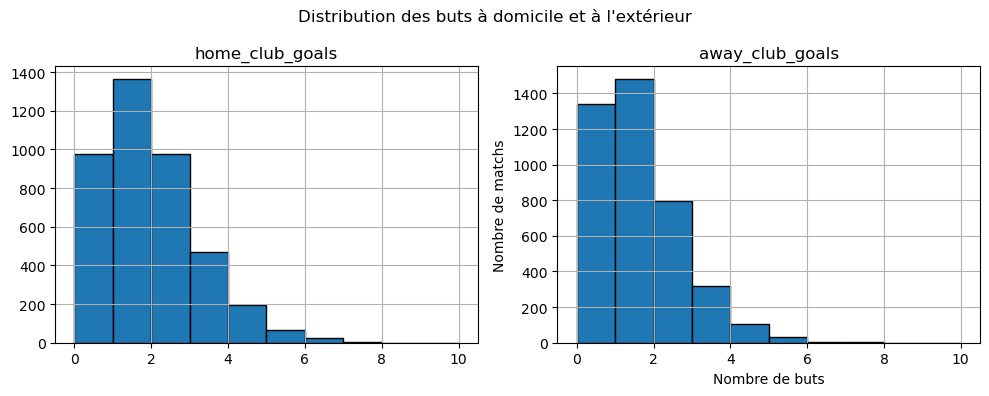

In [13]:
import matplotlib.pyplot as plt

# On s'assure que les colonnes ne contiennent pas de NaN ou de valeurs négatives
df_buts = matchs[['home_club_goals', 'away_club_goals']].copy()
df_buts = df_buts[(df_buts['home_club_goals'] >= 0) & (df_buts['away_club_goals'] >= 0)]

# Crée un histogramme avec des bornes entières
max_but = int(df_buts.max().max())  # On force ici la conversion
df_buts.hist(bins=range(0, max_but + 2), figsize=(10, 4), edgecolor='black')
plt.suptitle("Distribution des buts à domicile et à l'extérieur")
plt.xlabel("Nombre de buts")
plt.ylabel("Nombre de matchs")
plt.tight_layout()
plt.show()


### 3.1.3 Répartition des résultats

Dans cette sous-section, nous analysons la distribution de la variable `results`, qui indique le résultat du match du point de vue de l’équipe à domicile :

- `1` : victoire de l’équipe à domicile,
- `0` : match nul,
- `-1` : défaite de l’équipe à domicile.

Cette variable constitue la cible (`target`) pour notre modèle de machine learning. Il est donc essentiel d’en comprendre la répartition afin de détecter un éventuel déséquilibre entre les classes, ce qui pourrait influencer les performances du modèle.

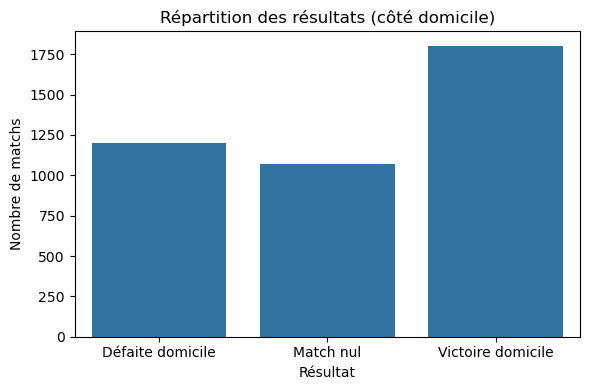

📊 Répartition des résultats (en %):
results
-1    29.50
 0    26.31
 1    44.19
Name: count, dtype: float64


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Répartition des résultats (valeurs et libellés)
resultats_counts = matchs['results'].value_counts().sort_index()
labels = {-1: "Défaite domicile", 0: "Match nul", 1: "Victoire domicile"}

# Graphe sans warning
plt.figure(figsize=(6, 4))
sns.barplot(x=list(labels.values()), y=resultats_counts.values)
plt.title("Répartition des résultats (côté domicile)")
plt.xlabel("Résultat")
plt.ylabel("Nombre de matchs")
plt.tight_layout()
plt.show()

# Affichage des pourcentages
print("📊 Répartition des résultats (en %):")
print((resultats_counts / resultats_counts.sum() * 100).round(2))


### 3.1.4 Analyse des différences et du total de buts

Dans cette sous-section, nous étudions deux indicateurs simples mais très informatifs :

- **Différence de buts (`goal_difference`)** : différence entre les buts marqués par l'équipe à domicile et ceux marqués par l'équipe à l'extérieur,
- **Total de buts (`total_goals`)** : somme des buts marqués par les deux équipes pendant un match.

Ces deux variables peuvent s'avérer utiles dans la modélisation, car elles capturent à la fois le niveau de domination d'une équipe et le caractère offensif du match.

📈 Statistiques sur la différence de buts :


count    4078.000000
mean        0.332271
std         1.760269
min        -9.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         9.000000
Name: goal_difference, dtype: float64


📈 Statistiques sur le total de buts :


count    4078.000000
mean        2.619667
std         1.614648
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: total_goals, dtype: float64

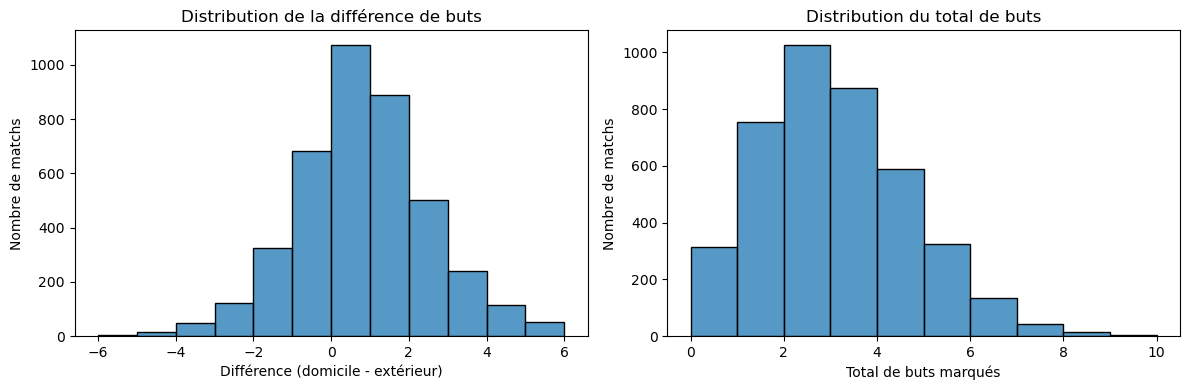

In [17]:
# Création des deux nouvelles variables
matchs['goal_difference'] = matchs['home_club_goals'] - matchs['away_club_goals']
matchs['total_goals'] = matchs['home_club_goals'] + matchs['away_club_goals']

# Statistiques descriptives rapides
print("📈 Statistiques sur la différence de buts :")
display(matchs['goal_difference'].describe())

print("\n📈 Statistiques sur le total de buts :")
display(matchs['total_goals'].describe())

# Visualisation des distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Différence de buts
sns.histplot(matchs['goal_difference'], bins=range(-6, 7), ax=axes[0], kde=False)
axes[0].set_title("Distribution de la différence de buts")
axes[0].set_xlabel("Différence (domicile - extérieur)")
axes[0].set_ylabel("Nombre de matchs")

# Total de buts
sns.histplot(matchs['total_goals'], bins=range(0, matchs['total_goals'].max() + 2), ax=axes[1], kde=False)
axes[1].set_title("Distribution du total de buts")
axes[1].set_xlabel("Total de buts marqués")
axes[1].set_ylabel("Nombre de matchs")

plt.tight_layout()
plt.show()


### 3.1.5 Analyse de la présence des spectateurs

La colonne `attendance` indique le nombre de spectateurs présents lors de chaque match. Cette variable peut avoir une importance indirecte dans la performance d’une équipe, notamment pour les matchs à domicile.

Nous allons ici analyser sa distribution, détecter d’éventuelles valeurs extrêmes ou manquantes, et voir si elle présente des tendances intéressantes.

🔍 Valeurs manquantes dans 'attendance' : 337 / 4078

📊 Statistiques sur la fréquentation des stades :


count     3741.000000
mean     21444.918204
std      13117.601011
min        500.000000
25%      12125.000000
50%      16782.000000
75%      28324.000000
max      70785.000000
Name: attendance, dtype: float64

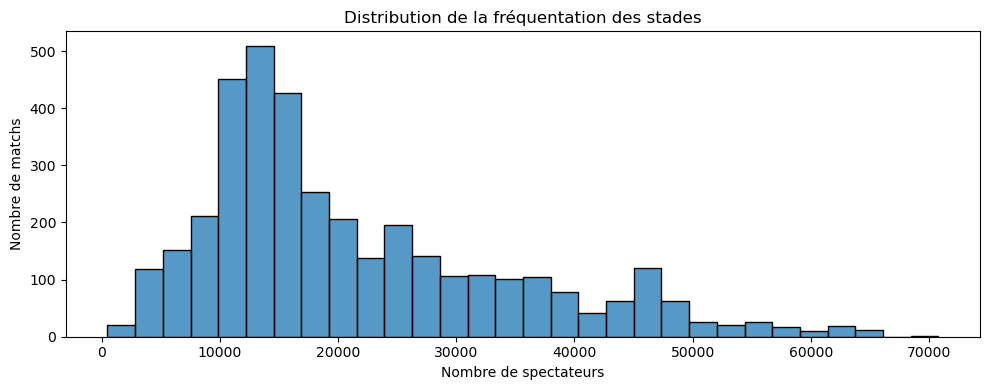

In [19]:
# Nombre de valeurs manquantes
missing_attendance = matchs['attendance'].isnull().sum()
print(f"🔍 Valeurs manquantes dans 'attendance' : {missing_attendance} / {len(matchs)}")

# Statistiques descriptives de la fréquentation
print("\n📊 Statistiques sur la fréquentation des stades :")
display(matchs['attendance'].describe())

# Distribution (on enlève les NaN pour l'affichage)
plt.figure(figsize=(10, 4))
sns.histplot(matchs['attendance'].dropna(), bins=30, kde=False)
plt.title("Distribution de la fréquentation des stades")
plt.xlabel("Nombre de spectateurs")
plt.ylabel("Nombre de matchs")
plt.tight_layout()
plt.show()


### 3.1.6 Analyse temporelle

Dans cette partie, nous analysons la dimension temporelle des matchs : répartition par saison, par mois ou par jour de la semaine.

Cela permet d’identifier des patterns de calendrier (pics d’activité, pause hivernale, etc.) ou d’évaluer si certaines périodes influencent les résultats (effet de saisonnalité, affluence, etc.).

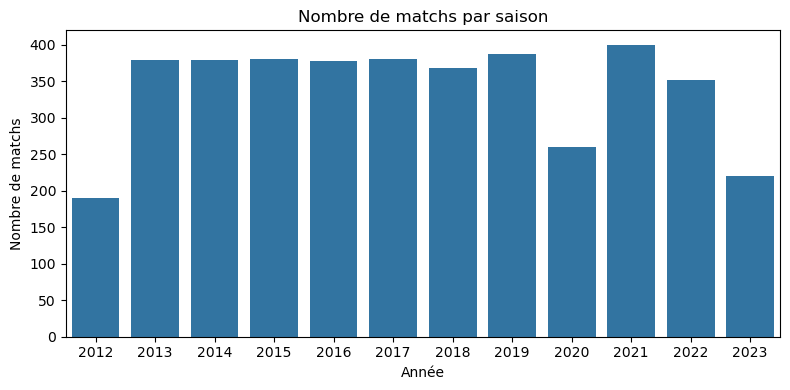

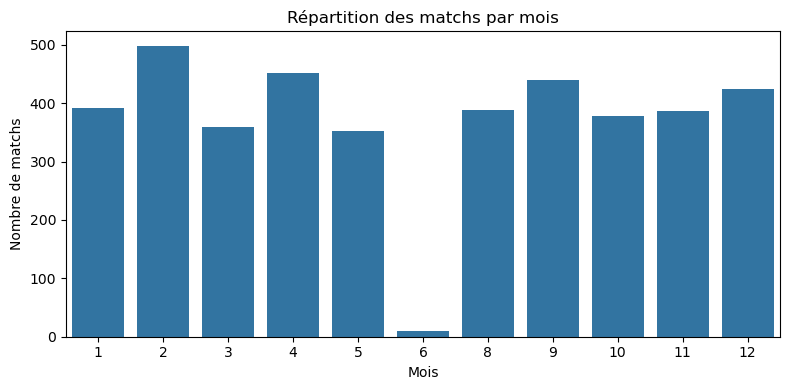

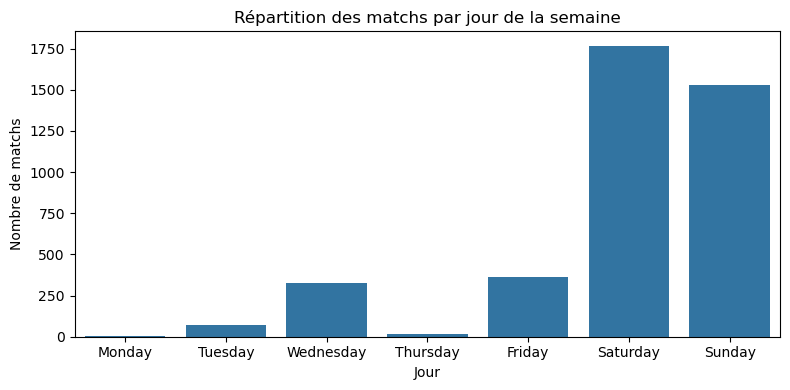

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Conversion au format datetime (sécurité)
matchs['date'] = pd.to_datetime(matchs['date'], errors='coerce')

# Création des colonnes temporelles
matchs['year'] = matchs['date'].dt.year
matchs['month'] = matchs['date'].dt.month
matchs['weekday'] = matchs['date'].dt.day_name()

# Répartition des matchs par saison (année)
plt.figure(figsize=(8, 4))
sns.countplot(x='year', data=matchs)
plt.title("Nombre de matchs par saison")
plt.xlabel("Année")
plt.ylabel("Nombre de matchs")
plt.tight_layout()
plt.show()

# Répartition des matchs par mois
plt.figure(figsize=(8, 4))
sns.countplot(x='month', data=matchs)
plt.title("Répartition des matchs par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de matchs")
plt.tight_layout()
plt.show()

# Répartition des matchs par jour de la semaine
plt.figure(figsize=(8, 4))
sns.countplot(x='weekday', data=matchs,
              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Répartition des matchs par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Nombre de matchs")
plt.tight_layout()
plt.show()


### 3.1.7 Vérification des incohérences ou anomalies

Avant de passer à l’analyse des autres fichiers, il est essentiel de vérifier la qualité des données dans `matchs.csv`.

Cette étape permet d’identifier :
- Des doublons éventuels,
- Des valeurs aberrantes (scores impossibles, positions hors limite),
- Des valeurs manquantes critiques,
- Des dates invalides.

Cela permettra d’anticiper d’éventuelles corrections à appliquer pendant le nettoyage ou le feature engineering.

In [23]:
# 🔁 Doublons exacts
print("🔁 Nombre de lignes dupliquées :", matchs.duplicated().sum())

# 🚫 Buts négatifs ou improbables
print("\n🚫 Matchs avec buts négatifs ou très élevés :")
buts_anormaux = matchs[
    (matchs['home_club_goals'] < 0) | (matchs['away_club_goals'] < 0) |
    (matchs['home_club_goals'] > 10) | (matchs['away_club_goals'] > 10)
]
display(buts_anormaux)

# 🚫 Positions hors limites (1 à 20 normalement)
print("\n📉 Positions hors bornes autorisées (1 à 20) :")
positions_anormales = matchs[
    (matchs['home_club_position'] < 1) | (matchs['home_club_position'] > 20) |
    (matchs['away_club_position'] < 1) | (matchs['away_club_position'] > 20)
]
display(positions_anormales)

# 📆 Dates invalides
print("\n📆 Valeurs manquantes ou incorrectes dans 'date' :")
print("Nombre de valeurs manquantes :", matchs['date'].isnull().sum())


🔁 Nombre de lignes dupliquées : 0

🚫 Matchs avec buts négatifs ou très élevés :


,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,...,home_club_name,away_club_name,aggregate,competition_type,results,goal_difference,total_goals,year,month,weekday



📉 Positions hors bornes autorisées (1 à 20) :


,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,...,home_club_name,away_club_name,aggregate,competition_type,results,goal_difference,total_goals,year,month,weekday



📆 Valeurs manquantes ou incorrectes dans 'date' :
Nombre de valeurs manquantes : 0


### 3.1.8 Matrice de corrélation

Nous terminons cette exploration avec une matrice de corrélation entre les principales variables numériques.

Cela permet d’identifier les relations linéaires entre les variables, de repérer d’éventuelles redondances ou variables fortement liées à la cible (`results`). Ces insights seront utiles pour orienter la sélection des features dans la modélisation.


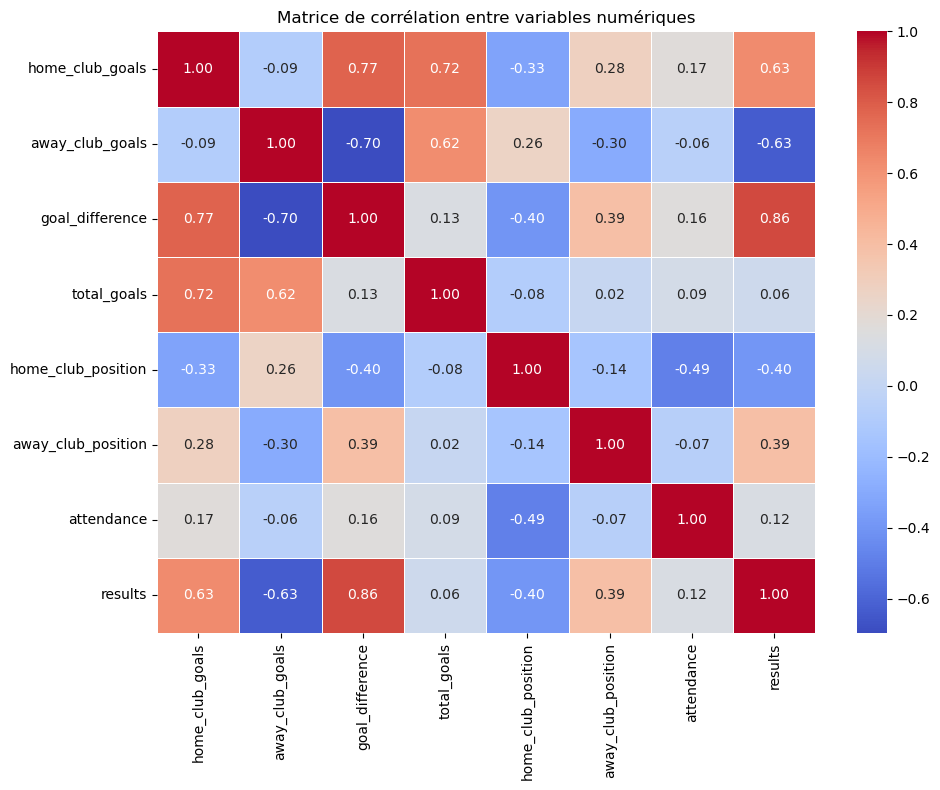

In [25]:
# Liste des variables numériques pertinentes pour la corrélation
cols_corr = ['home_club_goals', 'away_club_goals', 'goal_difference', 'total_goals',
             'home_club_position', 'away_club_position', 'attendance', 'results']

# Matrice de corrélation
plt.figure(figsize=(10, 8))
corr_matrix = matchs[cols_corr].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de corrélation entre variables numériques")
plt.tight_layout()
plt.show()


- La variable `goal_difference` est fortement corrélée avec `results` (~0.75+), ce qui est logique puisque plus l'écart de buts est élevé, plus la victoire est probable.
- `home_club_goals` est aussi bien corrélé à `results`, davantage que `away_club_goals`, ce qui reflète l’avantage à domicile.
- `total_goals` a une corrélation plus modérée avec `results`, car un match avec beaucoup de buts ne garantit pas forcément une victoire.
- `home_club_position` et `away_club_position` montrent une corrélation modérée entre elles, mais peuvent être combinées dans une nouvelle feature (écart de classement).


## 3.2 Exploration de `clubs.csv`

Le fichier `clubs.csv` contient des informations structurées sur les clubs de football présents dans notre base de données. Ces données sont précieuses pour enrichir notre compréhension du contexte des matchs et pour créer des variables explicatives pertinentes lors de la modélisation.

Dans cette section, nous allons explorer différentes dimensions associées aux clubs, notamment :

- La structure générale du fichier (`club_id`, `name`, etc.),
- Les stades et leurs capacités,
- La composition des effectifs des clubs (taille, âge, internationalité...),
- Le poids économique des clubs à travers leur solde de transferts.

Cette analyse est découpée en sous-sections pour en faciliter la lecture :

- **3.2.1** : Vue générale et structure du fichier
- **3.2.2** : Analyse des stades et de leur capacité
- **3.2.3** : Analyse de la composition des effectifs
- **3.2.4** : Analyse financière des clubs
- **3.2.5** : Vérifications et nettoyage

L’objectif est d’identifier des variables intéressantes à intégrer dans notre modèle de prédiction, à partir des caractéristiques des clubs.


### 3.2.1 Vue générale et structure du fichier

Cette première sous-section vise à explorer la structure du fichier `clubs.csv` afin de comprendre quelles informations sont disponibles pour chaque club.

Nous allons notamment :
- Afficher les premières lignes du fichier,
- Examiner les types de colonnes,
- Identifier les colonnes avec des valeurs manquantes,
- Compter les valeurs uniques par colonne.

Cela nous permettra de repérer les variables potentiellement exploitables dans les prochaines étapes.

In [29]:
# Aperçu des premières lignes
print("📄 Aperçu du fichier clubs.csv :")
display(clubs.head())

# Informations générales sur la structure
print("\n🧱 Structure des données :")
clubs.info()

# Valeurs uniques par colonne
print("\n🔢 Nombre de valeurs uniques par colonne :")
display(clubs.nunique().sort_values(ascending=False))

# Valeurs manquantes par colonne
print("\n🚫 Valeurs manquantes :")
missing_clubs = clubs.isnull().sum()
missing_percent = (missing_clubs / len(clubs)) * 100
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing_clubs,
    'Pourcentage (%)': missing_percent.round(2)
})
display(missing_df[missing_df['Valeurs manquantes'] > 0].sort_values(by='Pourcentage (%)', ascending=False))


📄 Aperçu du fichier clubs.csv :


,club_id,club_code,name,domestic_competition_id,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name
0,969,montpellier-hsc,Montpellier Hérault Sport Club,FR1,25,25.7,12,48.0,8,Stade de la Mosson,32939,+€28.60m,NaN
1,1082,losc-lille,Lille Olympique Sporting Club Lille Métropole,FR1,25,25.4,18,72.0,7,Decathlon Arena-Stade Pierre-Mauroy,50186,+€3.65m,NaN
2,1160,nimes-olympique,Nîmes Olympique,FR1,26,25.4,12,46.2,3,Stade des Antonins,8033,+€2.50m,NaN
3,3911,stade-brest-29,Stade brestois 29,FR1,24,26.0,6,25.0,3,Stade Francis-Le Blé,15220,+€5.10m,NaN
4,595,sc-bastia,SC Bastia,FR1,25,27.6,8,32.0,6,Stade Armand-Cesari,16480,+€480k,NaN



🧱 Structure des données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   club_id                  35 non-null     int64  
 1   club_code                35 non-null     object 
 2   name                     35 non-null     object 
 3   domestic_competition_id  35 non-null     object 
 4   squad_size               35 non-null     int64  
 5   average_age              35 non-null     float64
 6   foreigners_number        35 non-null     int64  
 7   foreigners_percentage    35 non-null     float64
 8   national_team_players    35 non-null     int64  
 9   stadium_name             35 non-null     object 
 10  stadium_seats            35 non-null     int64  
 11  net_transfer_record      35 non-null     object 
 12  coach_name               0 non-null      float64
dtypes: float64(3), int64(5), object(5)
memory usage: 3.7+ K

club_id                    35
club_code                  35
name                       35
stadium_name               35
stadium_seats              35
foreigners_percentage      30
net_transfer_record        30
average_age                25
foreigners_number          18
national_team_players      14
squad_size                  8
domestic_competition_id     1
coach_name                  0
dtype: int64


🚫 Valeurs manquantes :


,Valeurs manquantes,Pourcentage (%)
coach_name,35,100.0


### 3.2.2 Analyse des stades et de leur capacité

Cette sous-section se concentre sur les stades associés aux clubs. L’objectif est d’analyser la capacité des stades, de détecter d’éventuelles valeurs extrêmes, et d’évaluer si certaines équipes bénéficient d’infrastructures nettement plus grandes.

Cela peut servir à construire des variables de prestige, d’attractivité ou à interpréter certains effets d’ambiance dans les matchs.

🏟️ Top 10 des plus grandes capacités de stade :


,name,stadium_name,stadium_seats
21,Olympique de Marseille,Orange Vélodrome,67394
16,Olympique Lyonnais,Groupama Stadium,59186
1,Lille Olympique Sporting Club Lille Métropole,Decathlon Arena-Stade Pierre-Mauroy,50186
22,Paris Saint-Germain Football Club,Parc des Princes,49691
9,FC Girondins Bordeaux,Matmut Atlantique,42115
24,AS Saint-Étienne,Stade Geoffroy-Guichard,42000
30,Racing Club de Lens,Stade Bollaert-Delelis,38223
7,Football Club de Nantes,Stade de la Beaujoire,37463
32,Olympique Gymnaste Club Nice Côte d'Azur,Allianz Riviera,36178
31,Toulouse Football Club,Stadium Municipal,33150


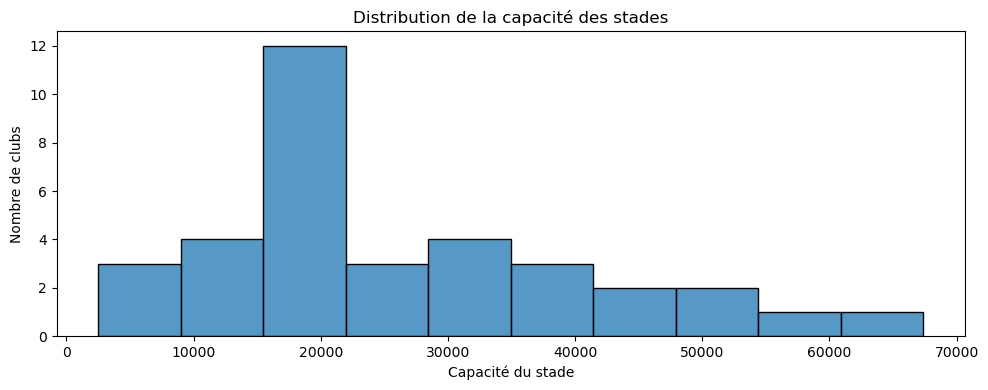


📈 Statistiques descriptives sur la capacité des stades :


count       35.000000
mean     26239.314286
std      15002.331638
min       2500.000000
25%      16740.000000
50%      21684.000000
75%      34664.000000
max      67394.000000
Name: stadium_seats, dtype: float64

In [31]:
# Top 10 des clubs avec les plus grands stades
print("🏟️ Top 10 des plus grandes capacités de stade :")
display(clubs[['name', 'stadium_name', 'stadium_seats']].sort_values(by='stadium_seats', ascending=False).head(10))

# Histogramme de la capacité des stades
plt.figure(figsize=(10, 4))
sns.histplot(clubs['stadium_seats'].dropna(), bins=10, kde=False)
plt.title("Distribution de la capacité des stades")
plt.xlabel("Capacité du stade")
plt.ylabel("Nombre de clubs")
plt.tight_layout()
plt.show()

# Statistiques descriptives
print("\n📈 Statistiques descriptives sur la capacité des stades :")
display(clubs['stadium_seats'].describe())


### 3.2.3 Analyse de la composition des effectifs

Cette sous-section analyse les effectifs des clubs en se basant sur plusieurs variables disponibles :

- La taille de l’effectif (`squad_size`),
- L’âge moyen des joueurs (`average_age`),
- Le nombre de joueurs étrangers (`foreigners_number`) et leur pourcentage (`foreigners_percentage`),
- Le nombre de joueurs internationaux sélectionnés en équipe nationale (`national_team_players`).

Ces informations permettent de dresser un profil des clubs selon leur structure d’équipe et leur niveau de professionnalisation.

📈 Statistiques descriptives sur la composition des effectifs :


,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players
count,35.000000,35.000000,35.000000,35.000000,35.000000
mean,25.800000,25.208571,13.028571,49.968571,6.742857
std,4.085844,1.260572,5.043841,18.514696,4.320559
min,5.000000,22.700000,1.000000,18.500000,0.000000
25%,24.500000,24.300000,10.500000,42.300000,4.000000
50%,26.000000,25.400000,13.000000,50.000000,6.000000
75%,28.000000,26.000000,16.000000,57.100000,9.000000
max,30.000000,27.600000,24.000000,100.000000,19.000000


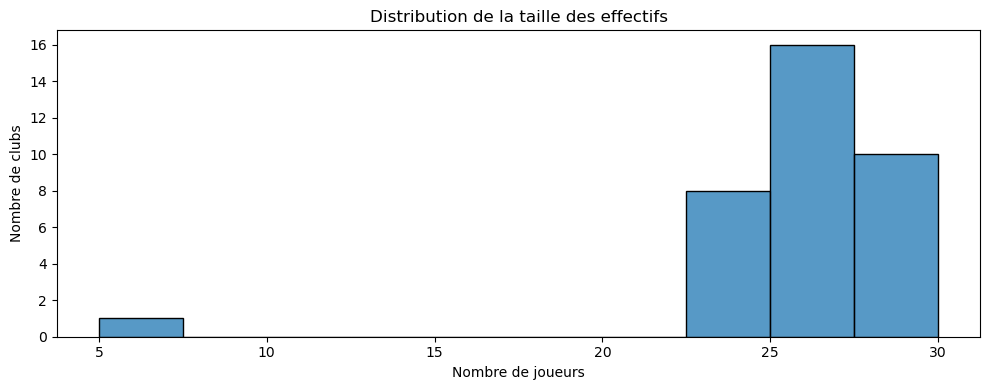

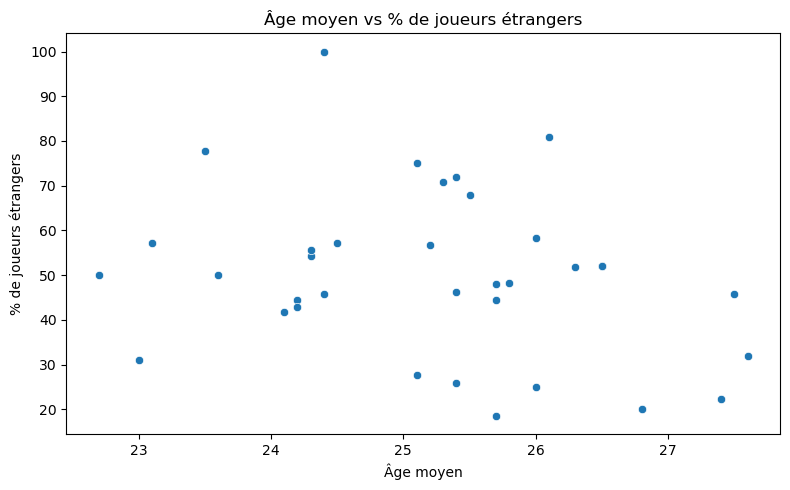

In [33]:
# Statistiques descriptives des colonnes clés
colonnes_effectif = ['squad_size', 'average_age', 'foreigners_number',
                     'foreigners_percentage', 'national_team_players']

print("📈 Statistiques descriptives sur la composition des effectifs :")
display(clubs[colonnes_effectif].describe())

# Visualisation de la taille des effectifs
plt.figure(figsize=(10, 4))
sns.histplot(clubs['squad_size'], bins=10, kde=False)
plt.title("Distribution de la taille des effectifs")
plt.xlabel("Nombre de joueurs")
plt.ylabel("Nombre de clubs")
plt.tight_layout()
plt.show()

# Scatter : âge moyen vs % de joueurs étrangers
plt.figure(figsize=(8, 5))
sns.scatterplot(x='average_age', y='foreigners_percentage', data=clubs)
plt.title("Âge moyen vs % de joueurs étrangers")
plt.xlabel("Âge moyen")
plt.ylabel("% de joueurs étrangers")
plt.tight_layout()
plt.show()


### 3.2.4 Analyse financière des clubs

Le fichier `clubs.csv` contient une colonne `net_transfer_record`, qui représente le solde des transferts réalisés par chaque club (en millions d’euros, ou dans l’unité choisie par la base). Cette donnée permet d’évaluer l’investissement financier relatif des clubs.

Une analyse de cette variable peut révéler des tendances intéressantes :
- Quels clubs ont des politiques de dépense ou de revente marquées ?
- Existe-t-il des clubs très dépensiers ou très excédentaires ?
- Ces données pourraient être croisées plus tard avec la performance sportive.


📊 Statistiques sur les soldes de transferts (en euros) :


count    2.900000e+01
mean    -2.619310e+06
std      5.070406e+07
min     -2.470000e+08
25%      4.800000e+05
50%      3.640000e+06
75%      1.270000e+07
max      6.210000e+07
Name: net_transfer_record_clean, dtype: float64

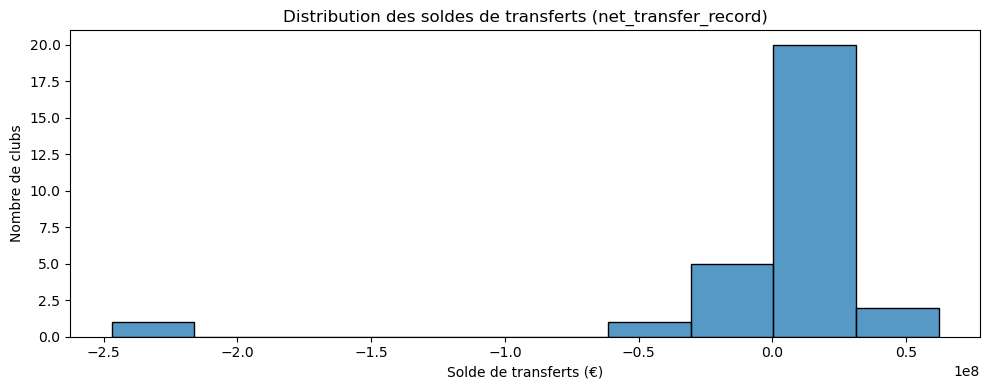


💸 Top clubs les plus dépensiers (soldes négatifs) :


,name,net_transfer_record_clean
22,Paris Saint-Germain Football Club,-247000000.0
32,Olympique Gymnaste Club Nice Côte d'Azur,-33690000.0
21,Olympique de Marseille,-30200000.0
14,Association sportive de Monaco Football Club,-22600000.0
19,Racing Club de Strasbourg Alsace,-16200000.0



📈 Top clubs avec les plus gros excédents (soldes positifs) :


,name,net_transfer_record_clean
6,Stade Rennais Football Club,62100000.0
16,Olympique Lyonnais,31990000.0
5,Football Club Lorient-Bretagne Sud,30300000.0
0,Montpellier Hérault Sport Club,28600000.0
34,Football Club de Metz,23700000.0


In [35]:
def parse_transfer_value(val):
    """Convertit un string comme '+480k' ou '-12.5m' en float (en euros)."""
    if pd.isna(val):
        return np.nan
    val = str(val).strip().lower().replace('€', '')
    
    if val.endswith('m'):
        return float(val.replace('m', '')) * 1_000_000
    elif val.endswith('k'):
        return float(val.replace('k', '')) * 1_000
    else:
        try:
            return float(val)
        except ValueError:
            return np.nan

# Application du nettoyage
clubs['net_transfer_record_clean'] = clubs['net_transfer_record'].apply(parse_transfer_value)

# 📊 Statistiques de base
print("📊 Statistiques sur les soldes de transferts (en euros) :")
display(clubs['net_transfer_record_clean'].describe())

# 📈 Histogramme propre
plt.figure(figsize=(10, 4))
sns.histplot(clubs['net_transfer_record_clean'].dropna(), bins=10, kde=False)
plt.title("Distribution des soldes de transferts (net_transfer_record)")
plt.xlabel("Solde de transferts (€)")
plt.ylabel("Nombre de clubs")
plt.tight_layout()
plt.show()

# 💸 Clubs les plus dépensiers
print("\n💸 Top clubs les plus dépensiers (soldes négatifs) :")
display(clubs[['name', 'net_transfer_record_clean']].sort_values(by='net_transfer_record_clean').head(5))

# 📈 Clubs avec les plus gros excédents
print("\n📈 Top clubs avec les plus gros excédents (soldes positifs) :")
display(clubs[['name', 'net_transfer_record_clean']].sort_values(by='net_transfer_record_clean', ascending=False).head(5))


### 3.2.5 Vérifications et nettoyage

Avant de conclure l’analyse de `clubs.csv`, il est important de s’assurer que les données sont cohérentes et propres :

- Vérification de l’unicité des identifiants (`club_id`),
- Recherche d’éventuels doublons dans les lignes,
- Détection de valeurs aberrantes dans les variables numériques,
- Contrôle de la présence de valeurs manquantes encore non traitées.

Ces étapes garantissent que les informations extraites pourront être utilisées en toute confiance dans la suite du projet.

🔁 Nombre de lignes dupliquées : 0

🆔 Le champ 'club_id' est-il unique ? True

🚫 Valeurs manquantes restantes par colonne :


coach_name                   35
net_transfer_record_clean     6
dtype: int64

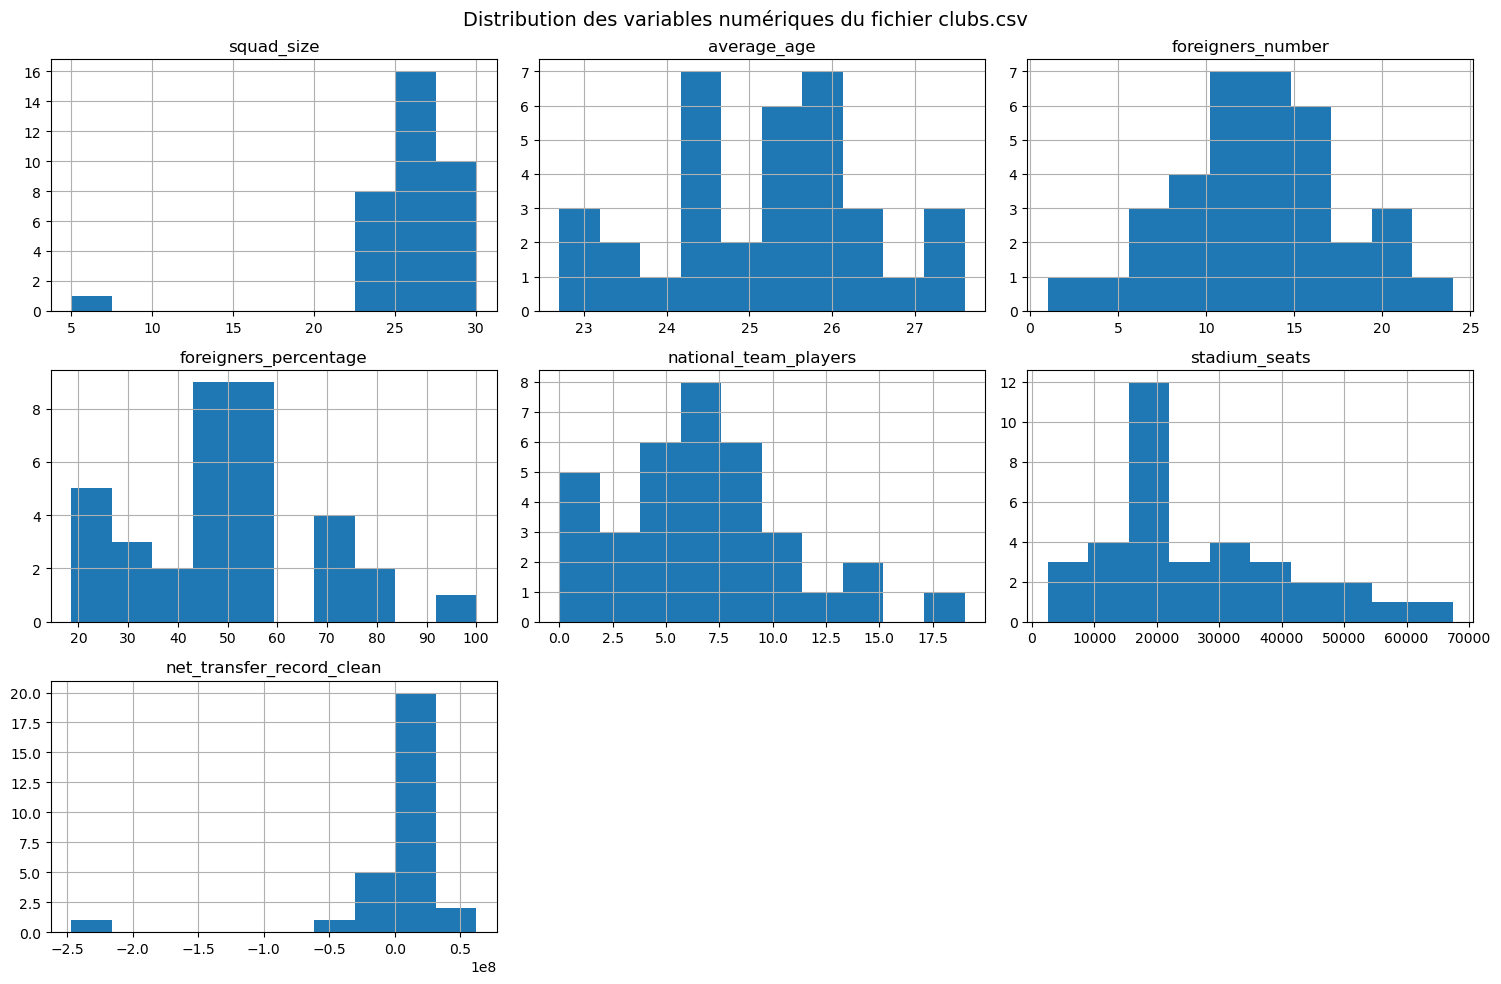

In [37]:
# 🔁 Doublons exacts
print("🔁 Nombre de lignes dupliquées :", clubs.duplicated().sum())

# 🆔 Vérification de l’unicité des clubs
print("\n🆔 Le champ 'club_id' est-il unique ?", clubs['club_id'].is_unique)

# 🔎 Valeurs manquantes restantes
print("\n🚫 Valeurs manquantes restantes par colonne :")
missing = clubs.isnull().sum()
missing = missing[missing > 0]
display(missing)

# 🧮 Contrôle rapide des colonnes numériques (recherche d’outliers visuels)
colonnes_numeriques = ['squad_size', 'average_age', 'foreigners_number',
                       'foreigners_percentage', 'national_team_players', 'stadium_seats',
                       'net_transfer_record_clean']

clubs[colonnes_numeriques].hist(figsize=(15, 10), bins=10)
plt.suptitle("Distribution des variables numériques du fichier clubs.csv", fontsize=14)
plt.tight_layout()
plt.show()


## 3.3 Exploration de `appearances.csv`

Le fichier `appearances.csv` contient des informations détaillées sur les performances des joueurs lors de chaque match. Chaque ligne correspond à un joueur dans un match donné, ce qui permet une analyse fine des compositions d’équipes et des performances individuelles.

Ce fichier est une source précieuse pour :
- Calculer des statistiques agrégées par équipe et par match,
- Estimer la qualité de l’effectif aligné (expérience, temps de jeu, constance),
- Identifier des indicateurs de forme, de régularité ou d’impact disciplinaire.

Nous allons analyser ce fichier en plusieurs sous-sections :

- **3.3.1** : Vue générale et structure du fichier
- **3.3.2** : Analyse des temps de jeu
- **3.3.3** : Analyse de l’expérience des joueurs (via minutes jouées)
- **3.3.4** : Analyse des avertissements (cartons)
- **3.3.5** : Vérifications et nettoyage


### 3.3.1 Vue générale et structure du fichier

Le fichier `appearances.csv` contient une ligne par joueur et par match, ce qui en fait un fichier de type "long format". Il détaille les performances individuelles : temps de jeu, titularisation, âge, etc.

Dans cette première sous-section, nous allons :
- Afficher les premières lignes du fichier,
- Examiner les colonnes disponibles et leur type,
- Relever les éventuelles valeurs manquantes,
- Identifier les variables les plus prometteuses pour la suite du projet.

In [40]:
# Aperçu des données
print("📄 Aperçu des premières lignes de appearances.csv :")
display(appearances.head())

# Structure du DataFrame
print("\n🧱 Informations sur les colonnes :")
appearances.info()

# Nombre de valeurs uniques par colonne
print("\n🔢 Nombre de valeurs uniques par colonne :")
display(appearances.nunique().sort_values(ascending=False))

# Valeurs manquantes
print("\n🚫 Valeurs manquantes par colonne :")
missing = appearances.isnull().sum()
missing = missing[missing > 0]
missing_percent = (missing / len(appearances) * 100).round(2)
display(pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage (%)': missing_percent
}).sort_values(by='Pourcentage (%)', ascending=False))


📄 Aperçu des premières lignes de appearances.csv :


,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2229837_108830,2229837,108830,415,3205,2012-08-10,Aymen Abdennour,FR1,1,0,0,0,90
1,2229837_113707,2229837,113707,969,1082,2012-08-10,Rémy Cabella,FR1,1,0,0,0,42
2,2229837_126767,2229837,126767,415,3205,2012-08-10,Ali Ahamada,FR1,0,0,0,0,90
3,2229837_126796,2229837,126796,415,60949,2012-08-10,Adrien Regattin,FR1,0,1,0,0,11
4,2229837_127032,2229837,127032,415,141,2012-08-10,Serge Aurier,FR1,0,1,0,1,84



🧱 Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115182 entries, 0 to 115181
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   appearance_id           115182 non-null  object
 1   game_id                 115182 non-null  int64 
 2   player_id               115182 non-null  int64 
 3   player_club_id          115182 non-null  int64 
 4   player_current_club_id  115182 non-null  int64 
 5   date                    115182 non-null  object
 6   player_name             115182 non-null  object
 7   competition_id          115182 non-null  object
 8   yellow_cards            115182 non-null  int64 
 9   red_cards               115182 non-null  int64 
 10  goals                   115182 non-null  int64 
 11  assists                 115182 non-null  int64 
 12  minutes_played          115182 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 11.4+ MB

🔢 Nombr

appearance_id             115182
game_id                     4078
player_id                   2330
player_name                 2324
date                        1176
player_current_club_id       288
minutes_played                90
player_club_id                34
goals                          6
assists                        5
yellow_cards                   3
red_cards                      2
competition_id                 1
dtype: int64


🚫 Valeurs manquantes par colonne :


,Valeurs manquantes,Pourcentage (%)


### 3.3.2 Analyse des temps de jeu

Le temps de jeu est un indicateur fondamental de l’implication des joueurs. En analysant cette variable, on peut :

- Repérer les titulaires réguliers,
- Comparer l’investissement en minutes entre les clubs,
- Dériver des features comme le temps de jeu moyen par match ou par joueur.

Nous allons explorer la distribution des temps de jeu, et réaliser quelques agrégations globales pour anticiper des features utiles.

📊 Statistiques descriptives sur les minutes jouées :


count    115182.000000
mean         69.538053
std          29.745996
min           1.000000
25%          55.000000
50%          90.000000
75%          90.000000
max          90.000000
Name: minutes_played, dtype: float64

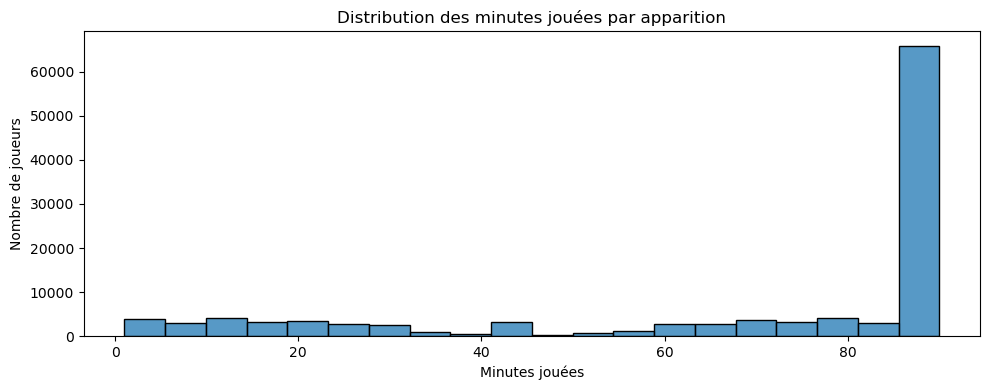

✅ Nombre d'apparitions de titulaires (≥ 60 min) : 84871
🔁 Proportion de titulaires sur l’ensemble : 73.68 %

⏱️ Top 5 joueurs au plus fort temps de jeu moyen :


player_id
496706    90.0
395602    90.0
5667      90.0
195778    90.0
342212    90.0
Name: minutes_played, dtype: float64


🏟️ Total des minutes jouées par club :


player_club_id
244     402996
1082    402748
273     402648
969     401778
583     401736
Name: minutes_played, dtype: int64

In [42]:
# ✅ Statistiques globales
print("📊 Statistiques descriptives sur les minutes jouées :")
display(appearances['minutes_played'].describe())

# 📈 Histogramme de la distribution des minutes jouées
plt.figure(figsize=(10, 4))
sns.histplot(appearances['minutes_played'], bins=20, kde=False)
plt.title("Distribution des minutes jouées par apparition")
plt.xlabel("Minutes jouées")
plt.ylabel("Nombre de joueurs")
plt.tight_layout()
plt.show()

# 💡 Nombre d'apparitions de titulaires (ex: >= 60 min)
titulaires = appearances[appearances['minutes_played'] >= 60]
print(f"✅ Nombre d'apparitions de titulaires (≥ 60 min) : {len(titulaires)}")
print(f"🔁 Proportion de titulaires sur l’ensemble : {round(len(titulaires) / len(appearances) * 100, 2)} %")

# ⏱️ Temps de jeu moyen par joueur
moyenne_minutes = appearances.groupby('player_id')['minutes_played'].mean().sort_values(ascending=False)
print("\n⏱️ Top 5 joueurs au plus fort temps de jeu moyen :")
display(moyenne_minutes.head(5))

# 🧮 Total des minutes jouées par club (player_club_id)
minutes_par_club = appearances.groupby('player_club_id')['minutes_played'].sum().sort_values(ascending=False)
print("\n🏟️ Total des minutes jouées par club :")
display(minutes_par_club.head(5))


### 3.3.3 Analyse de l’expérience des joueurs (via temps de jeu cumulé)

En l’absence d’information directe sur l’âge des joueurs, nous pouvons approximer leur expérience en observant leur présence récurrente dans les matchs, ainsi que le volume total de minutes jouées.

Cette approche permet de :
- Repérer les joueurs les plus utilisés sur l’ensemble de la base,
- Évaluer la profondeur ou la dépendance des clubs vis-à-vis de certains profils,
- Anticiper des indicateurs de stabilité ou de rotation dans les effectifs.

🎖️ Top 10 des joueurs les plus expérimentés (minutes jouées cumulées) :


player_id  player_name     
60561      Anthony Lopes       30898
23951      Steve Mandanda      28379
84301      Benjamin André      28146
22628      Benoît Costil       25135
4811       Hilton              24917
39910      Stéphane Ruffier    24803
22386      Daniel Congré       24309
37647      Dimitri Payet       22098
181767     Marquinhos          22091
357117     Alban Lafont        21405
Name: minutes_played, dtype: int64


📊 Top 10 des joueurs avec le plus grand nombre de matchs joués :


player_id  player_name   
60561      Anthony Lopes     346
84301      Benjamin André    345
23951      Steve Mandanda    319
60540      Valère Germain    311
118284     Jordan Ferri      302
37647      Dimitri Payet     297
22386      Daniel Congré     289
4811       Hilton            285
18934      Thomas Mangani    283
98349      Romain Hamouma    283
Name: game_id, dtype: int64

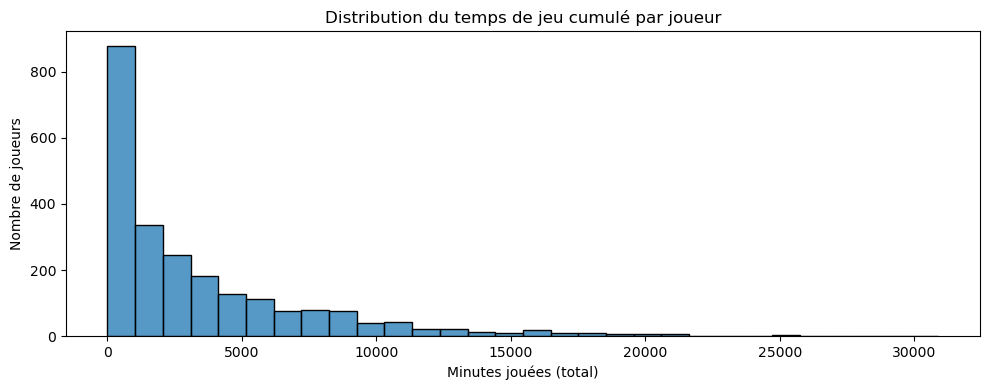

In [44]:
# ⏱️ Temps de jeu cumulé par joueur
total_minutes_by_player = appearances.groupby(['player_id', 'player_name'])['minutes_played'].sum().sort_values(ascending=False)

print("🎖️ Top 10 des joueurs les plus expérimentés (minutes jouées cumulées) :")
display(total_minutes_by_player.head(10))

# 📅 Nombre d'apparitions par joueur
appearances_count = appearances.groupby(['player_id', 'player_name'])['game_id'].count().sort_values(ascending=False)

print("\n📊 Top 10 des joueurs avec le plus grand nombre de matchs joués :")
display(appearances_count.head(10))

# 🧮 Répartition de l'expérience (minutes cumulées)
plt.figure(figsize=(10, 4))
sns.histplot(total_minutes_by_player.values, bins=30, kde=False)
plt.title("Distribution du temps de jeu cumulé par joueur")
plt.xlabel("Minutes jouées (total)")
plt.ylabel("Nombre de joueurs")
plt.tight_layout()
plt.show()


### 3.3.4 Analyse des avertissements (cartons)

Dans cette sous-section, nous analysons les avertissements reçus par les joueurs : cartons jaunes et rouges.

Ces événements disciplinaires peuvent affecter les résultats des matchs, la disponibilité des joueurs, ou révéler des tendances de jeu plus agressif chez certaines équipes.

Nous allons visualiser :
- La distribution des cartons jaunes et rouges,
- Les joueurs et clubs les plus sanctionnés.


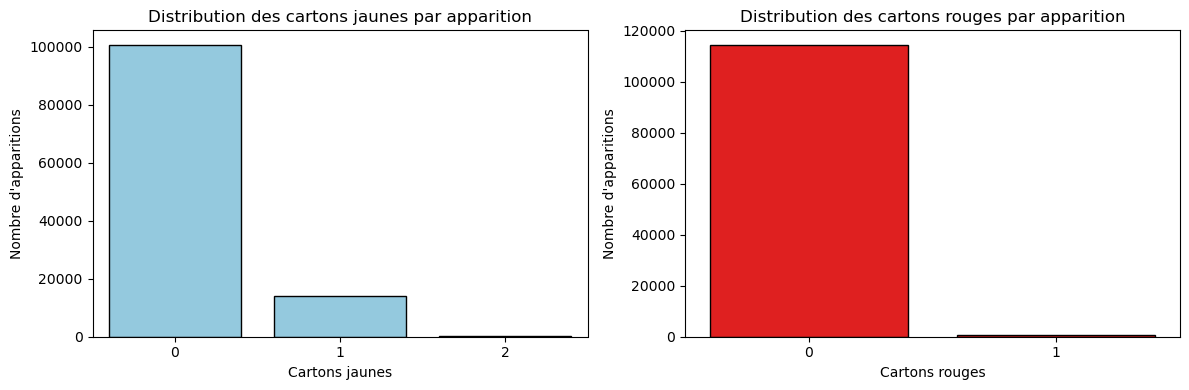

🟥🟨 Joueurs les plus sanctionnés :


,,yellow_cards,red_cards,total_cartons
player_id,player_name,,,
102558,Marco Verratti,94,1,95
84301,Benjamin André,83,1,84
44686,Yannick Cahuzac,75,4,79
103565,Wahbi Khazri,67,3,70
139279,Nicolas Pallois,64,3,67
250844,Alexander Djiku,59,5,64
118284,Jordan Ferri,60,2,62
41063,Mustapha Diallo,49,3,52
16136,Dante,49,2,51



🏟️ Clubs les plus sanctionnés :


,yellow_cards,red_cards,total_cartons
player_club_id,,,
244,782,40,822
1082,765,30,795
417,743,35,778
969,696,50,746
162,708,31,739
40,701,30,731
583,702,27,729
1041,694,30,724
995,701,19,720


In [46]:
# 📊 Diagramme en barres propre pour les cartons jaunes et rouges
plt.figure(figsize=(12, 4))

# 📦 Regrouper les valeurs
yellow_counts = appearances['yellow_cards'].value_counts().sort_index()
red_counts = appearances['red_cards'].value_counts().sort_index()

# 🟨 Cartons jaunes
plt.subplot(1, 2, 1)
sns.barplot(x=yellow_counts.index, y=yellow_counts.values, color='skyblue', edgecolor='black')
plt.title("Distribution des cartons jaunes par apparition")
plt.xlabel("Cartons jaunes")
plt.ylabel("Nombre d'apparitions")

# 🟥 Cartons rouges
plt.subplot(1, 2, 2)
sns.barplot(x=red_counts.index, y=red_counts.values, color='red', edgecolor='black')
plt.title("Distribution des cartons rouges par apparition")
plt.xlabel("Cartons rouges")
plt.ylabel("Nombre d'apparitions")

plt.tight_layout()
plt.show()


# 🧑‍🏫 Joueurs les plus sanctionnés
cartons_par_joueur = appearances.groupby(['player_id', 'player_name'])[['yellow_cards', 'red_cards']].sum()
cartons_par_joueur['total_cartons'] = cartons_par_joueur['yellow_cards'] + cartons_par_joueur['red_cards']

print("🟥🟨 Joueurs les plus sanctionnés :")
display(cartons_par_joueur.sort_values(by='total_cartons', ascending=False).head(10))

# 🏟️ Clubs les plus sanctionnés
cartons_par_club = appearances.groupby('player_club_id')[['yellow_cards', 'red_cards']].sum()
cartons_par_club['total_cartons'] = cartons_par_club['yellow_cards'] + cartons_par_club['red_cards']

print("\n🏟️ Clubs les plus sanctionnés :")
display(cartons_par_club.sort_values(by='total_cartons', ascending=False).head(10))


### 3.3.5 Vérifications et nettoyage

Avant de conclure l'analyse du fichier `appearances.csv`, nous effectuons quelques vérifications essentielles :

- Recherche de doublons dans les enregistrements,
- Vérification de la cohérence des identifiants (`game_id`, `player_id`),
- Contrôle de la présence de valeurs manquantes critiques,
- Analyse rapide des distributions pour détecter d’éventuelles anomalies.

Cela permet de garantir la qualité des données pour les futures étapes de feature engineering.

In [48]:
# 🔁 Doublons exacts
print("🔁 Nombre de lignes dupliquées :", appearances.duplicated().sum())

# 🆔 Vérification que chaque (game_id, player_id) est unique
is_unique = appearances[['game_id', 'player_id']].duplicated().sum() == 0
print("\n🆔 Le couple (game_id, player_id) est-il unique ?", is_unique)

# 🚫 Valeurs manquantes restantes
print("\n🚫 Valeurs manquantes par colonne :")
missing = appearances.isnull().sum()
missing = missing[missing > 0]
missing_percent = (missing / len(appearances) * 100).round(2)
display(pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage (%)': missing_percent
}).sort_values(by='Pourcentage (%)', ascending=False))





🔁 Nombre de lignes dupliquées : 0

🆔 Le couple (game_id, player_id) est-il unique ? True

🚫 Valeurs manquantes par colonne :


,Valeurs manquantes,Pourcentage (%)


## 3.4 Exploration de `lineups.csv`

Le fichier `lineups.csv` contient les compositions officielles des équipes pour chaque match. Chaque ligne correspond à un joueur aligné dans un match donné, avec son rôle (titulaire ou remplaçant), sa position, son club et son statut de capitaine.

Ce fichier est essentiel pour :
- Reconstituer les compositions d’équipes,
- Distinguer les titulaires des remplaçants,
- Étudier la répartition des postes,
- Identifier les joueurs-clés (ex. : capitaines récurrents).

Nous allons l’analyser à travers plusieurs sous-sections adaptées aux colonnes disponibles :

- **3.4.1** : Vue générale et structure du fichier
- **3.4.2** : Analyse des statuts (titulaires vs remplaçants)
- **3.4.3** : Répartition des postes et analyse des positions
- **3.4.4** : Analyse des capitaines d’équipe



### 3.4.1 Vue générale et structure du fichier

Cette première sous-section a pour objectif d’examiner la structure du fichier `lineups.csv`. Nous allons identifier les colonnes disponibles, leur type, la présence éventuelle de valeurs manquantes, et les variables intéressantes pour la suite.

Ce fichier jouera un rôle clé dans la reconstitution des équipes par match et l’étude des choix tactiques.

In [51]:
# 📄 Aperçu des premières lignes
print("📄 Aperçu des données de lineups.csv :")
display(lineups.head())

# 🧱 Informations générales
print("\n🧱 Structure du DataFrame :")
lineups.info()

# 🔢 Nombre de valeurs uniques par colonne
print("\n🔢 Nombre de valeurs uniques par colonne :")
display(lineups.nunique().sort_values(ascending=False))

# 🚫 Valeurs manquantes par colonne
print("\n🚫 Valeurs manquantes par colonne :")
missing = lineups.isnull().sum()
missing_percent = (missing / len(lineups) * 100).round(2)
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage (%)': missing_percent
})
display(missing_df[missing_df['Valeurs manquantes'] > 0].sort_values(by='Pourcentage (%)', ascending=False))


📄 Aperçu des données de lineups.csv :


,Unnamed: 0,game_lineups_id,date,game_id,player_id,club_id,player_name,type,position,number,team_captain
0,34475,be6532aeff4c40b06e6e0da142da7dd8,2013-08-24,2330825,4811,969,Hilton,starting_lineup,Centre-Back,4,1
1,34476,4b10516c5bf9b2dfac0435c7c2bbf872,2013-08-24,2330825,5303,969,Souleymane Camara,starting_lineup,Left Winger,19,0
2,34477,46552e9ff9777efa2e2d0df3a8147d87,2013-08-24,2330825,5614,750,Cédric Kanté,starting_lineup,Centre-Back,6,1
3,34478,9c10d07e15ca9a537576aa4c04511562,2013-08-24,2330825,5686,969,Laurent Pionnier,starting_lineup,Goalkeeper,1,0
4,34479,d6592bfd4c2c2f06a388086f8b0b714e,2013-08-24,2330825,17693,750,Sébastien Roudet,starting_lineup,Left Winger,18,0



🧱 Structure du DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137132 entries, 0 to 137131
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Unnamed: 0       137132 non-null  int64 
 1   game_lineups_id  137132 non-null  object
 2   date             137132 non-null  object
 3   game_id          137132 non-null  int64 
 4   player_id        137132 non-null  int64 
 5   club_id          137132 non-null  int64 
 6   player_name      137132 non-null  object
 7   type             137132 non-null  object
 8   position         137132 non-null  object
 9   number           137132 non-null  object
 10  team_captain     137132 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 11.5+ MB

🔢 Nombre de valeurs uniques par colonne :


Unnamed: 0         137132
game_lineups_id    137132
game_id              3696
player_id            2606
player_name          2600
date                 1062
number                 74
club_id                34
position               16
type                    2
team_captain            2
dtype: int64


🚫 Valeurs manquantes par colonne :


,Valeurs manquantes,Pourcentage (%)


### 3.4.2 Analyse des statuts (titulaires vs remplaçants)

La colonne `type` du fichier `lineups.csv` permet d’identifier si un joueur a débuté le match en tant que **titulaire** (`"starting"`) ou **remplaçant** (`"sub"`).

Cette information est précieuse pour :
- Estimer la fréquence d'utilisation des titulaires vs remplaçants,
- Repérer les clubs qui utilisent beaucoup leur banc ou non,
- Préparer des agrégations d'équipe plus précises dans les futures étapes.

Nous allons ici explorer la répartition globale et par club de ces statuts.

📊 Répartition globale des statuts :


,type,count
0,starting_lineup,81312
1,substitutes,55820


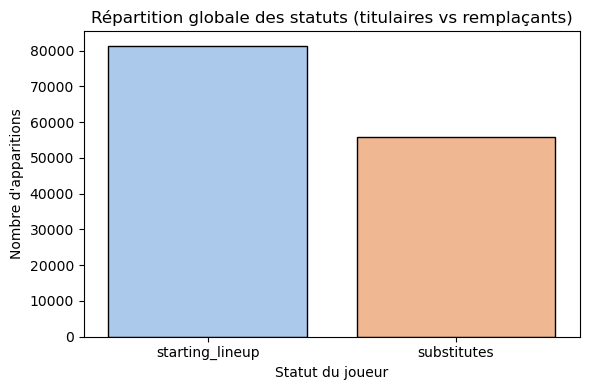

📊 Clubs avec la plus forte proportion de titulaires :


type,starting_lineup,substitutes,proportion_titulaires
club_id,,,
14171,836,532,0.61
750,418,264,0.61
3558,418,264,0.61
1423,418,263,0.61
1416,1144,727,0.61
1162,2090,1327,0.61
1159,418,266,0.61
595,1672,1058,0.61
855,2508,1590,0.61


In [53]:
# 📊 Comptage global des statuts
type_counts = lineups['type'].value_counts().reset_index()
type_counts.columns = ['type', 'count']

print("📊 Répartition globale des statuts :")
display(type_counts)

# 📉 Barplot sans warning seaborn
plt.figure(figsize=(6, 4))
sns.barplot(
    data=type_counts,
    x='type',
    y='count',
    hue='type',          # Obligatoire pour éviter le FutureWarning
    palette="pastel",
    edgecolor='black',
    legend=False         # On cache la légende car x = hue
)
plt.title("Répartition globale des statuts (titulaires vs remplaçants)")
plt.xlabel("Statut du joueur")
plt.ylabel("Nombre d'apparitions")
plt.tight_layout()
plt.show()

# 🔍 Répartition par club
type_by_club = lineups.groupby(['club_id', 'type']).size().unstack().fillna(0)

# ✅ Utilisation exacte des vrais noms 'starting_lineup' et 'substitutes'
if 'starting_lineup' in type_by_club.columns and 'substitutes' in type_by_club.columns:
    type_by_club['proportion_titulaires'] = (
        type_by_club['starting_lineup'] / (type_by_club['starting_lineup'] + type_by_club['substitutes'])
    ).round(2)

    print("📊 Clubs avec la plus forte proportion de titulaires :")
    display(type_by_club.sort_values(by='proportion_titulaires', ascending=False).head(10))
else:
    print("❌ Les colonnes 'starting_lineup' et/ou 'substitutes' sont absentes.")


### 3.4.3 Répartition des postes et analyse des positions

Le fichier `lineups.csv` contient une colonne `position` indiquant le poste assigné à chaque joueur lors du match.

L’analyse de cette variable permet de :
- Comprendre la composition type des équipes,
- Vérifier la cohérence tactique (ex : 1 gardien, 4 défenseurs, etc.),
- Identifier d’éventuels déséquilibres ou stratégies atypiques.

Nous allons examiner la distribution globale des postes ainsi que quelques observations sur leur fréquence.

📋 Répartition des postes :


,position,count
0,Centre-Back,23124
1,Centre-Forward,17884
2,Goalkeeper,14890
3,Defensive Midfield,14794
4,Central Midfield,13664
5,Right-Back,10799
6,Left-Back,10410
7,Right Winger,8794
8,Left Winger,8591
9,Attacking Midfield,7879


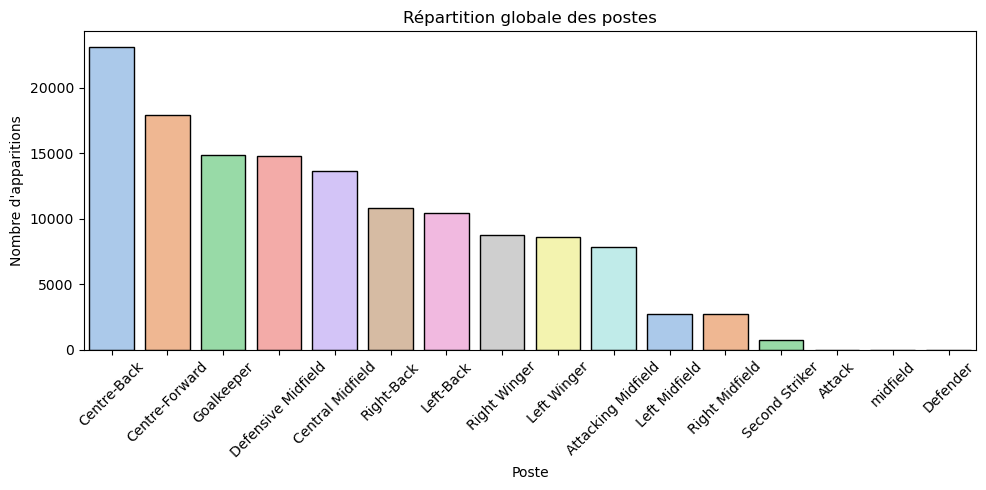

In [55]:
# 📋 Distribution globale des postes
position_counts = lineups['position'].value_counts().reset_index()
position_counts.columns = ['position', 'count']

print("📋 Répartition des postes :")
display(position_counts)

# 📈 Barplot de la distribution des postes
plt.figure(figsize=(10, 5))
sns.barplot(
    data=position_counts,
    x='position',
    y='count',
    hue='position',      # Fix seaborn warning
    palette="pastel",
    edgecolor='black',
    legend=False
)
plt.title("Répartition globale des postes")
plt.xlabel("Poste")
plt.ylabel("Nombre d'apparitions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.4.4 Analyse des capitaines d'équipe

Le fichier `lineups.csv` contient une colonne `team_captain` indiquant si un joueur était capitaine lors du match.

L’étude des capitaines est intéressante car elle permet de :
- Identifier les joueurs-clés et leaders d'équipe,
- Observer la stabilité du capitanat au sein des clubs,
- Analyser l'impact potentiel de la présence ou de l'absence du capitaine.

Nous allons ici examiner :
- La distribution générale des capitaines,
- Les joueurs ayant porté le brassard le plus souvent,
- La répartition du capitanat par club.

🎖️ Nombre total d'apparitions de capitaines : 7158

🎖️ Top 10 des joueurs ayant été capitaine le plus souvent :


player_name
Hilton             244
Steve Mandanda     192
Loïc Perrin        189
Dante              180
Thiago Silva       176
Ismaël Traoré      162
José Fonte         145
Julien Féret       140
Maxime Gonalons    139
Yannick Cahuzac    136
Name: count, dtype: int64


🏟️ Clubs ayant aligné le plus souvent un capitaine désigné :


club_id
244     368
1041    363
273     363
1082    361
969     360
995     359
583     358
162     357
417     356
618     320
Name: count, dtype: int64

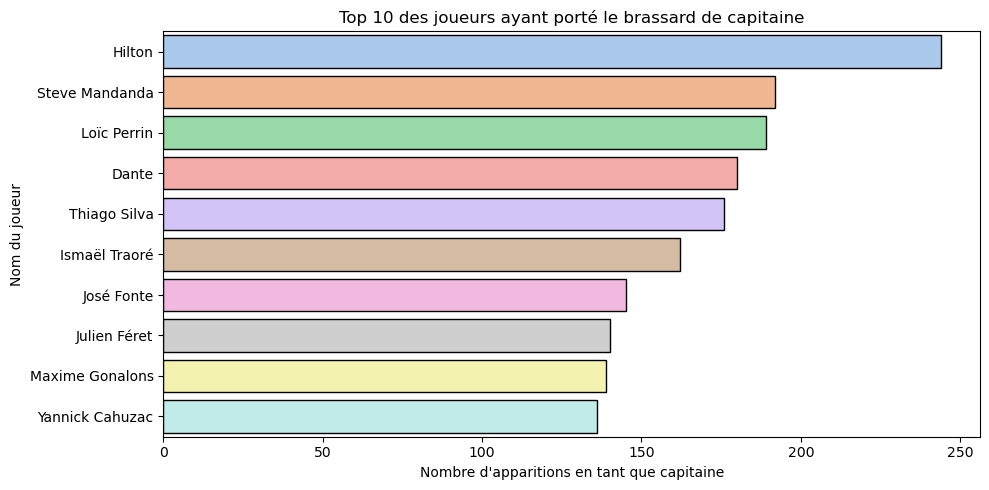

In [57]:
# ✅ Distribution générale du capitanat
captains = lineups[lineups['team_captain'] == 1]
print(f"🎖️ Nombre total d'apparitions de capitaines : {len(captains)}")

# 📋 Top joueurs ayant été capitaine le plus souvent
top_captains = captains['player_name'].value_counts().head(10)

print("\n🎖️ Top 10 des joueurs ayant été capitaine le plus souvent :")
display(top_captains)

# 📋 Top clubs avec le plus d'apparitions de leur capitaine
captains_by_club = captains['club_id'].value_counts().head(10)

print("\n🏟️ Clubs ayant aligné le plus souvent un capitaine désigné :")
display(captains_by_club)

# 📈 Barplot des 10 joueurs les plus fréquemment capitaines (sans warning)
top_captains_df = top_captains.reset_index()
top_captains_df.columns = ['player_name', 'count']

plt.figure(figsize=(10, 5))
sns.barplot(
    data=top_captains_df,
    x='count',
    y='player_name',
    hue='player_name',   # Fix seaborn future warning
    palette="pastel",
    edgecolor='black',
    legend=False         # Pas besoin de légende inutile
)
plt.title("Top 10 des joueurs ayant porté le brassard de capitaine")
plt.xlabel("Nombre d'apparitions en tant que capitaine")
plt.ylabel("Nom du joueur")
plt.tight_layout()
plt.show()



## 3.5 Exploration de `events.csv`

Le fichier `events.csv` contient des informations détaillées sur chaque événement survenu pendant un match, avec une ligne par action (but, carton, changement, etc.).

Ce fichier est particulièrement riche et essentiel pour :
- Identifier les événements clés qui influencent le résultat des matchs,
- Caractériser les performances individuelles (buts, passes décisives),
- Étudier la discipline (cartons), les remplacements, ou encore la temporalité des actions.

Voici les colonnes principales de ce fichier :
- `game_id` : identifiant du match,
- `minute` : minute à laquelle l'événement s'est produit,
- `type` : nature de l’événement (goal, card, foul, etc.),
- `player_id` / `club_id` : acteur de l’événement,
- `player_assist_id` / `player_in_id` : joueur associé à une passe ou un remplacement,
- `description` : complément textuel de certains événements.

Nous allons organiser cette exploration en plusieurs sous-sections :

- **3.5.1** : Vue générale et structure du fichier
- **3.5.2** : Analyse des types d’événements
- **3.5.3** : Focus sur les événements offensifs (buts, passes, entrées)
- **3.5.4** : Analyse des fautes et sanctions (cartons)

### 3.5.1 Vue générale et structure du fichier

Le fichier `events.csv` recense tous les événements individuels survenus pendant les matchs.

Avant toute analyse approfondie, il est essentiel d’avoir une vue globale de sa structure :
- Aperçu des colonnes disponibles,
- Types de données,
- Vérification des valeurs uniques,
- Identification des éventuelles valeurs manquantes.

Cela permettra d’adapter au mieux les prochaines explorations ciblées sur les événements clés.

In [60]:
# 📄 Aperçu des premières lignes
print("📄 Aperçu des données de events.csv :")
display(events.head())

# 🧱 Structure générale
print("\n🧱 Informations sur le DataFrame :")
events.info()

# 🔢 Nombre de valeurs uniques par colonne
print("\n🔢 Nombre de valeurs uniques par colonne :")
display(events.nunique().sort_values(ascending=False))

# 🚫 Valeurs manquantes par colonne
print("\n🚫 Valeurs manquantes par colonne :")
missing = events.isnull().sum()
missing_percent = (missing / len(events) * 100).round(2)
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage (%)': missing_percent
})
display(missing_df[missing_df['Valeurs manquantes'] > 0].sort_values(by='Pourcentage (%)', ascending=False))


📄 Aperçu des données de events.csv :


,Unnamed: 0,game_event_id,date,game_id,minute,type,club_id,player_id,description,player_in_id,player_assist_id
0,6816,5d2b67957aaae6cf2a41e70cb5d4024f,2012-09-22,2223841,73,Substitutions,3911,5399,", Not reported",37516.0,NaN
1,6817,cd511880b945623db06ace57349e45b2,2012-09-22,2223841,76,Goals,3911,24459,", Penalty, 2. Goal of the Season Assist: , Fou...",NaN,24459.0
2,6818,8ca118538b45a24643ab1c9f76e50f6d,2012-09-22,2223841,56,Substitutions,3911,25113,", Not reported",22053.0,NaN
3,6819,aca68dc250aa9a3758fb2243ee679d9d,2012-09-22,2223841,88,Cards,1423,27490,1. Yellow card,NaN,NaN
4,6820,a133e4d7cdccb930f2dc7b4935754a30,2012-09-22,2223841,4,Cards,1423,43960,1. Yellow card,NaN,NaN



🧱 Informations sur le DataFrame :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40995 entries, 0 to 40994
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        40995 non-null  int64  
 1   game_event_id     40995 non-null  object 
 2   date              40995 non-null  object 
 3   game_id           40995 non-null  int64  
 4   minute            40995 non-null  int64  
 5   type              40995 non-null  object 
 6   club_id           40995 non-null  int64  
 7   player_id         40995 non-null  int64  
 8   description       19667 non-null  object 
 9   player_in_id      26092 non-null  float64
 10  player_assist_id  2268 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 3.4+ MB

🔢 Nombre de valeurs uniques par colonne :


Unnamed: 0          40995
game_event_id       40995
game_id              4077
player_in_id         2124
player_id            1941
description          1230
date                 1176
player_assist_id      640
minute                 91
club_id                34
type                    3
dtype: int64


🚫 Valeurs manquantes par colonne :


,Valeurs manquantes,Pourcentage (%)
player_assist_id,38727,94.47
description,21328,52.03
player_in_id,14903,36.35


### 3.5.2 Analyse des types d’événements

La colonne `type` du fichier `events.csv` indique la nature de chaque action survenue durant un match (ex. : but, faute, carton, remplacement, etc.).

Cette analyse est cruciale pour :
- Identifier les événements les plus fréquents,
- Repérer les types d’actions utiles à la modélisation,
- Évaluer la richesse des données par type d’événement.

Nous allons explorer la distribution globale des types d’événements présents dans le dataset.

📊 Répartition des types d'événements :


,type,count
0,Substitutions,26105
1,Goals,10683
2,Cards,4207


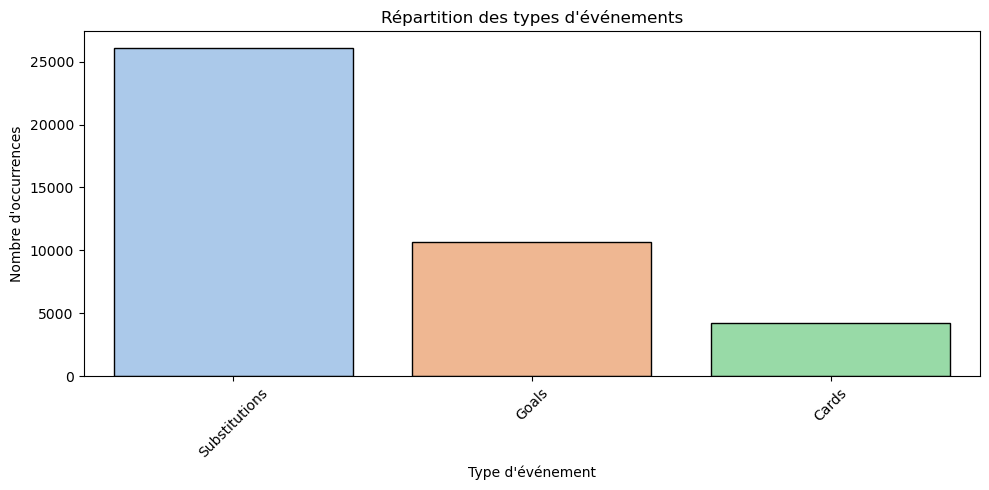

In [62]:
# 📋 Comptage des types d'événements
event_types = events['type'].value_counts().reset_index()
event_types.columns = ['type', 'count']

print("📊 Répartition des types d'événements :")
display(event_types)

# 📉 Barplot propre
plt.figure(figsize=(10, 5))
sns.barplot(
    data=event_types,
    x='type',
    y='count',
    hue='type',
    palette='pastel',
    edgecolor='black',
    legend=False
)
plt.title("Répartition des types d'événements")
plt.xlabel("Type d'événement")
plt.ylabel("Nombre d'occurrences")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.5.3 Focus sur les événements offensifs (buts, passes, entrées)

Cette section vise à analyser les événements clés liés à l’attaque et à la performance offensive :

- Les **buts marqués**, identifiables par un type spécifique ou via la présence de `player_assist_id`,
- Les **passes décisives**, souvent liées à la colonne `player_assist_id`,
- Les **remplacements**, via la colonne `player_in_id`.

Ces éléments sont essentiels pour modéliser la qualité d'une attaque, la contribution des joueurs, ou encore l’impact des remplaçants.

🎯 Nombre de passes décisives identifiées : 2268
⚽ Nombre de buts détectés (via 'type') : 10683
🔁 Nombre de remplacements détectés : 26092


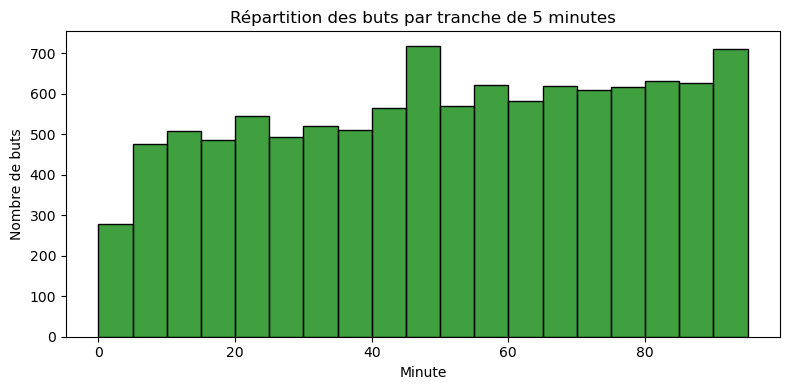

In [64]:
# 🎯 Événements liés aux passes décisives
nb_passes_decisives = events['player_assist_id'].notna().sum()
print(f"🎯 Nombre de passes décisives identifiées : {nb_passes_decisives}")

# ⚽ Événements où un joueur a marqué un but (souvent identifiables via type ou description)
goal_events = events[events['type'].str.lower().str.contains('goal')]
print(f"⚽ Nombre de buts détectés (via 'type') : {len(goal_events)}")

# 👥 Remplaçants (entrants en jeu)
nb_remplacements = events['player_in_id'].notna().sum()
print(f"🔁 Nombre de remplacements détectés : {nb_remplacements}")

# 📊 Évolution temporelle des buts (optionnel mais intéressant)
plt.figure(figsize=(8, 4))
sns.histplot(goal_events['minute'], bins=range(0, 100, 5), color='green', edgecolor='black')
plt.title("Répartition des buts par tranche de 5 minutes")
plt.xlabel("Minute")
plt.ylabel("Nombre de buts")
plt.tight_layout()
plt.show()


### 3.5.4 Analyse des fautes et sanctions (cartons, fautes)

Les données d’événements permettent également d’identifier les actions défensives et disciplinaires, notamment :

- Les **cartons jaunes et rouges**,
- Les **fautes commises**.

Ces éléments sont cruciaux pour :
- Évaluer le comportement défensif des équipes,
- Identifier les joueurs à risque (fauteurs ou souvent sanctionnés),
- Ajouter des variables de discipline dans le modèle prédictif.

Nous allons ici extraire et analyser la fréquence de ces événements.

In [66]:
# 🟨 Extraction des événements liés aux cartons
carton_events = events[events['type'].str.lower().str.contains('card')]

# 🧾 Détail des types de cartons (jaune, rouge, etc.)
print("🟨 Détail des types de sanctions :")
display(carton_events['type'].value_counts())

# 📋 Joueurs les plus sanctionnés
top_sanctioned = carton_events['player_id'].value_counts().head(10)
print("👮 Joueurs les plus sanctionnés (id uniquement) :")
display(top_sanctioned)

🟨 Détail des types de sanctions :


type
Cards    4207
Name: count, dtype: int64

👮 Joueurs les plus sanctionnés (id uniquement) :


player_id
102558    29
44686     28
154199    25
103565    24
93309     21
40014     21
84085     20
5348      20
72479     19
84301     19
Name: count, dtype: int64

## 3.6 Exploration de `valuations.csv`

Le fichier `valuations.csv` contient les estimations de la valeur marchande des joueurs à différentes dates.  
Ces données peuvent être utilisées pour créer des indicateurs économiques pertinents à l’échelle du joueur ou du club.


---

L’objectif de cette section est de :
- Comprendre l’évolution des valeurs individuelles,
- Observer les dynamiques de valeur au sein des clubs,
- Identifier des tendances utiles à la prédiction des performances collectives.

---

🧭 Plan des sous-sections :

- **3.6.1** : Vue générale et structure du fichier *(déjà fait)*
- **3.6.2** : Analyse des valeurs individuelles des joueurs (`market_value_in_eur`)
- **3.6.3** : Valeur agrégée des clubs (`current_club_id`)
- **3.6.4** : Idées de features à créer à partir des valeurs



### 3.6.1 Vue générale et structure du fichier

Le fichier `valuations.csv` contient des informations concernant la valeur marchande des joueurs à différentes dates.  
Cette exploration vise à :

- Examiner la structure du fichier (colonnes disponibles, types de données),
- Afficher un aperçu des premières lignes pour comprendre la syntaxe et les formats utilisés,
- Identifier le nombre de valeurs uniques par colonne afin de repérer les clés potentielles,
- Vérifier la présence de valeurs manquantes.

Ces points nous permettront de déterminer comment exploiter ces données pour créer des features économiques pertinentes dans notre modèle.

In [69]:
# 📄 Aperçu des premières lignes
print("📄 Aperçu des premières lignes de valuations.csv :")
display(valuations.head())

# 🧱 Informations générales sur la structure du DataFrame
print("\n🧱 Structure des données :")
valuations.info()

# 🔢 Nombre de valeurs uniques par colonne
print("\n🔢 Nombre de valeurs uniques par colonne :")
display(valuations.nunique().sort_values(ascending=False))

# 🚫 Valeurs manquantes par colonne
print("\n🚫 Valeurs manquantes par colonne :")
missing = valuations.isnull().sum()
missing_percent = (missing / len(valuations) * 100).round(2)
missing_df = pd.DataFrame({
    'Valeurs manquantes': missing,
    'Pourcentage (%)': missing_percent
})
display(missing_df[missing_df['Valeurs manquantes'] > 0].sort_values(by='Pourcentage (%)', ascending=False))


📄 Aperçu des premières lignes de valuations.csv :


,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,773,2004-10-04,3500000,14171,FR1
1,1327,2004-10-04,4000000,1159,FR1
2,1423,2004-10-04,1000000,855,FR1
3,1572,2004-10-04,1000000,162,FR1
4,1613,2004-10-04,200000,855,FR1



🧱 Structure des données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30215 entries, 0 to 30214
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   player_id                            30215 non-null  int64 
 1   date                                 30215 non-null  object
 2   market_value_in_eur                  30215 non-null  int64 
 3   current_club_id                      30215 non-null  int64 
 4   player_club_domestic_competition_id  30215 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.2+ MB

🔢 Nombre de valeurs uniques par colonne :


date                                   2326
player_id                              2011
market_value_in_eur                     209
current_club_id                          35
player_club_domestic_competition_id       1
dtype: int64


🚫 Valeurs manquantes par colonne :


,Valeurs manquantes,Pourcentage (%)


### 3.6.2 Analyse des valeurs individuelles des joueurs

La colonne `market_value_in_eur` représente la valeur marchande estimée d’un joueur à une date donnée.

Cette analyse vise à :
- Étudier la distribution des valeurs des joueurs,
- Identifier les joueurs les plus chers du dataset,
- Détecter la présence éventuelle de valeurs aberrantes.

Cette information peut être un proxy de la qualité d’un joueur ou de son importance au sein de l’effectif.

📈 Statistiques descriptives de la valeur des joueurs :


count    3.021500e+04
mean     3.258903e+06
std      8.973152e+06
min      1.000000e+04
25%      4.000000e+05
50%      9.000000e+05
75%      2.500000e+06
max      2.000000e+08
Name: market_value_in_eur, dtype: float64

💶 Joueurs les plus chers du dataset :


,player_id,market_value_in_eur,date,current_club_id
19483,342229,200000000,2019-12-19,583
17109,342229,200000000,2018-12-17,583
18189,342229,200000000,2019-06-03,583
16151,68290,180000000,2018-06-04,583
16000,28003,180000000,2018-05-30,583
29799,342229,180000000,2023-06-27,583
15273,68290,180000000,2018-01-24,583
28544,342229,180000000,2022-12-23,583
21709,342229,180000000,2020-10-15,583
16931,68290,180000000,2018-12-17,583


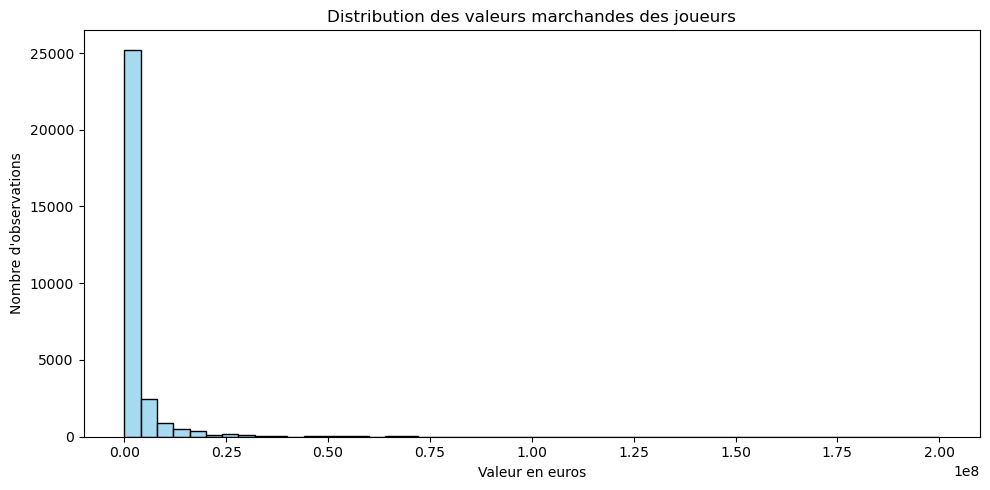

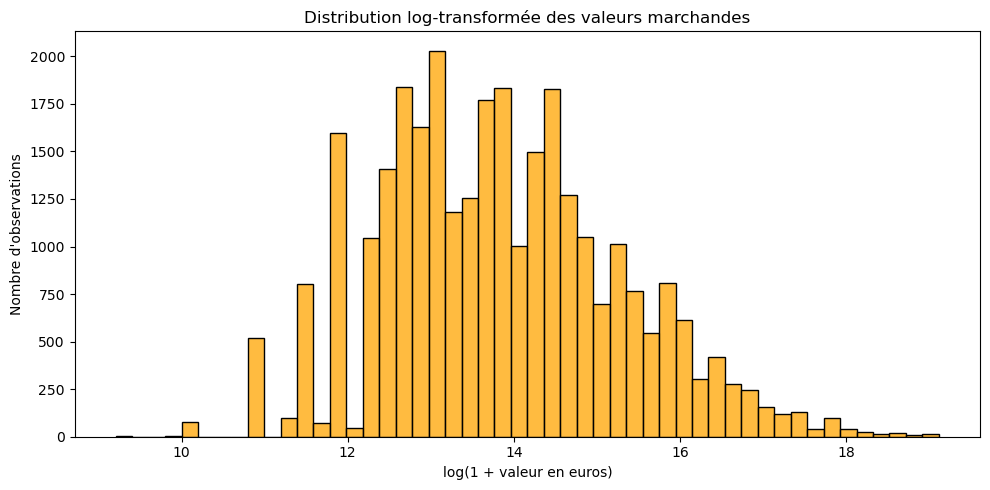

In [71]:
# 📈 Statistiques descriptives de la valeur des joueurs
print("📈 Statistiques descriptives de la valeur des joueurs :")
display(valuations['market_value_in_eur'].describe())

# 💶 Joueurs les plus chers
top_players = valuations.sort_values(by='market_value_in_eur', ascending=False).head(10)
print("💶 Joueurs les plus chers du dataset :")
display(top_players[['player_id', 'market_value_in_eur', 'date', 'current_club_id']])

# 📉 Distribution des valeurs (log-échelle pour lisibilité)
plt.figure(figsize=(10, 5))
sns.histplot(valuations['market_value_in_eur'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution des valeurs marchandes des joueurs")
plt.xlabel("Valeur en euros")
plt.ylabel("Nombre d'observations")
plt.tight_layout()
plt.show()

# 📉 Distribution log-transformée
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(valuations['market_value_in_eur']), bins=50, color='orange', edgecolor='black')
plt.title("Distribution log-transformée des valeurs marchandes")
plt.xlabel("log(1 + valeur en euros)")
plt.ylabel("Nombre d'observations")
plt.tight_layout()
plt.show()


### 3.6.3 Valeur agrégée des clubs (`current_club_id`)

En agrégeant les valeurs individuelles des joueurs par club, on peut estimer la valeur marchande totale de chaque effectif.

Cela permet de :
- Comparer la force économique des clubs,
- Identifier les clubs les plus « riches » en termes de joueurs,
- Créer des features agrégées par équipe à un instant donné.

Nous allons ici analyser la valeur cumulée des clubs et leur distribution.

🏟️ Top clubs par valeur d’effectif cumulée :


,club_id,total_market_value
0,583,24317724999
1,1041,7499675000
2,244,7338450000
3,162,6484825000
4,417,4585950000
5,1082,4007093000
6,273,3933400000
7,995,3815500000
8,969,3174850000
9,1158,2711435000


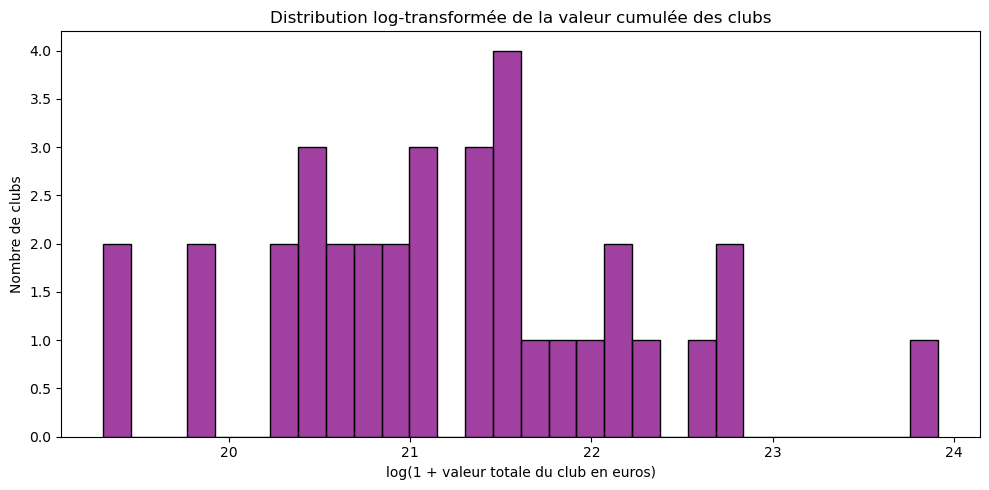

In [73]:
# 📊 Agrégation par club (valeur cumulée)
club_values = valuations.groupby('current_club_id')['market_value_in_eur'].sum().sort_values(ascending=False).reset_index()
club_values.columns = ['club_id', 'total_market_value']

print("🏟️ Top clubs par valeur d’effectif cumulée :")
display(club_values.head(10))

# 📉 Histogramme des valeurs cumulées (log transformé pour lisibilité)
plt.figure(figsize=(10, 5))
sns.histplot(np.log1p(club_values['total_market_value']), bins=30, color='purple', edgecolor='black')
plt.title("Distribution log-transformée de la valeur cumulée des clubs")
plt.xlabel("log(1 + valeur totale du club en euros)")
plt.ylabel("Nombre de clubs")
plt.tight_layout()
plt.show()


### 3.6.4 Idées de features à créer à partir des valeurs

Les données de `valuations.csv` permettent de dériver des indicateurs puissants et interprétables à la fois au niveau individuel (joueur) et collectif (club).

Voici quelques idées concrètes de features à extraire pour enrichir le modèle :

---

🔹 **Au niveau des clubs :**
- `valeur_totale_equipe_domicile` / `valeur_totale_equipe_exterieur`  
    → somme des valeurs des joueurs alignés pour chaque club à un match donné
- `diff_valeur_equipes`  
    → écart de valeur entre les deux équipes (domicile – extérieur)
- `valeur_moyenne_par_joueur`

---

🔹 **Au niveau des joueurs (optionnel si lineups disponibles) :**
- `joueurs_top_valeur_alignés`  
    → nombre de joueurs d’élite (> seuil €) dans le 11 de départ
- `valeur_max_joueur_domicile` / `valeur_max_joueur_exterieur`  
    → joueur le plus coté aligné par club

---

🔹 **Au niveau temporel :**
- `variation_valeur_joueur` (si historique par date)  
    → permet de modéliser la forme / momentum d’un joueur

---

Ces indicateurs peuvent être utiles pour capter la **forme globale**, la **puissance financière**, ou l’**expérience** des équipes en compétition.  
Ils peuvent aussi servir de proxy à la **qualité individuelle ou collective**, souvent corrélée aux résultats.


## 3.7 Synthèse graphique et croisements statistiques (version enrichie)

Afin de mieux comprendre les relations entre les performances sportives, les écarts de valeur économique et les résultats des matchs, nous avons enrichi le fichier `matchs` en créant une copie appelée `matchs_enriched`.

Cette copie incorpore des informations supplémentaires provenant du fichier `valuations.csv`, notamment la **valeur totale estimée de chaque club**.

Nous réalisons ensuite plusieurs croisements statistiques à partir de `matchs_enriched`, pour identifier des patterns exploitables en vue du feature engineering.

---

🔵 1. Valeur totale de l’équipe à domicile (log-transformée) vs Nombre moyen de buts marqués
- Vérifie si les clubs économiquement plus forts marquent en moyenne davantage de buts.

⚖️ 2. Différence de valeur entre clubs (domicile - extérieur) vs Résultat du match
- Permet d’observer comment l'écart de valeur influence les issues des matchs (victoire à domicile, nul, victoire à l'extérieur).

🏟️ 3. Position moyenne des clubs à domicile selon le résultat
- Analyse l’impact du classement sportif des clubs sur la probabilité de victoire à domicile.

---

Chaque analyse est accompagnée d’une visualisation adaptée (barplot, violinplot, boxplot) pour illustrer les tendances observées.
Ces observations guideront le travail de Feature Engineering dans la section suivante.


In [76]:
# 🔥 Création d'une valeur totale par club depuis valuations.csv

latest_valuations = valuations.sort_values(by='date').drop_duplicates(subset='player_id', keep='last')

club_values = latest_valuations.groupby('current_club_id')['market_value_in_eur'].sum().reset_index()

club_values.columns = ['club_id', 'total_market_value']

# 📋 Aperçu
display(club_values.head())


,club_id,total_market_value
0,40,43675000
1,162,365195000
2,244,279850000
3,273,319075000
4,290,27900000


In [77]:
# ✨ Création d'une copie enrichie pour les analyses
matchs_enriched = matchs.copy()

# 🔗 Fusionner la valeur des clubs domicile
matchs_enriched = matchs_enriched.merge(
    club_values.rename(columns={'club_id': 'home_club_id', 'total_market_value': 'home_club_value'}),
    on='home_club_id', how='left'
)

# 🔗 Fusionner la valeur des clubs extérieur
matchs_enriched = matchs_enriched.merge(
    club_values.rename(columns={'club_id': 'away_club_id', 'total_market_value': 'away_club_value'}),
    on='away_club_id', how='left'
)

# 📋 Vérification
display(matchs_enriched[['home_club_id', 'home_club_value', 'away_club_id', 'away_club_value']].head())


,home_club_id,home_club_value,away_club_id,away_club_value
0,618,59000000,595,13325000
1,14171,9350000,855,17960000
2,1423,2325000,1082,216650000
3,273,319075000,14171,9350000
4,1147,30950000,273,319075000


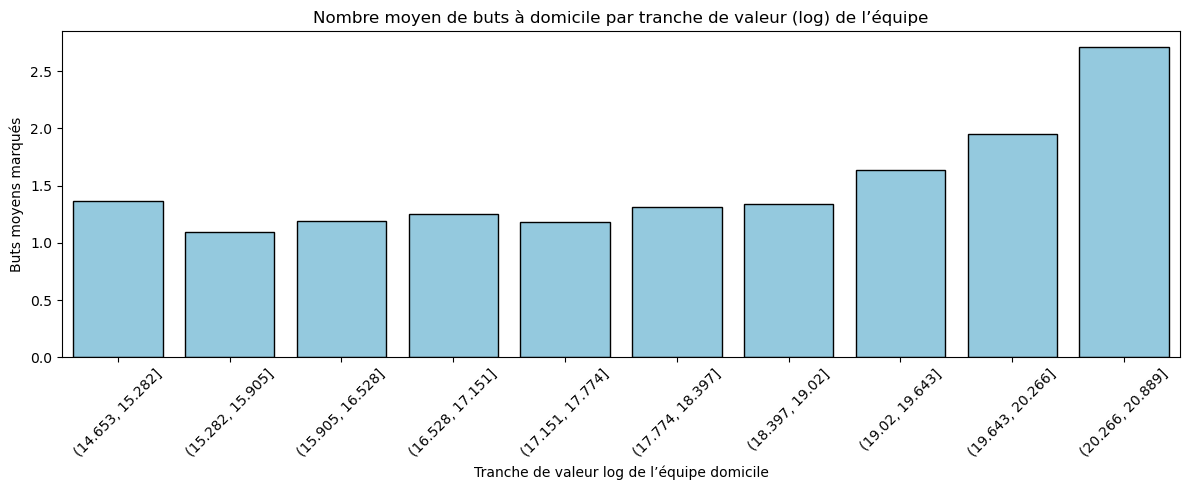

In [78]:
# 📋 Travail sur une copie spécifique
matchs_club_val = matchs_enriched.copy()

# 🔢 Log-transform de la valeur home
matchs_club_val['log_home_value'] = np.log1p(matchs_club_val['home_club_value'])
matchs_club_val['valeur_bin'] = pd.cut(matchs_club_val['log_home_value'], bins=10)

# 📊 Calcul de la moyenne de buts
buts_moyens_par_bin = matchs_club_val.groupby('valeur_bin', observed=True)['home_club_goals'].mean().reset_index()
buts_moyens_par_bin['valeur_bin'] = buts_moyens_par_bin['valeur_bin'].astype(str)

# 🎨 Affichage
plt.figure(figsize=(12, 5))
sns.barplot(data=buts_moyens_par_bin, x='valeur_bin', y='home_club_goals', color='skyblue', edgecolor='black')
plt.title("Nombre moyen de buts à domicile par tranche de valeur (log) de l’équipe")
plt.xlabel("Tranche de valeur log de l’équipe domicile")
plt.ylabel("Buts moyens marqués")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


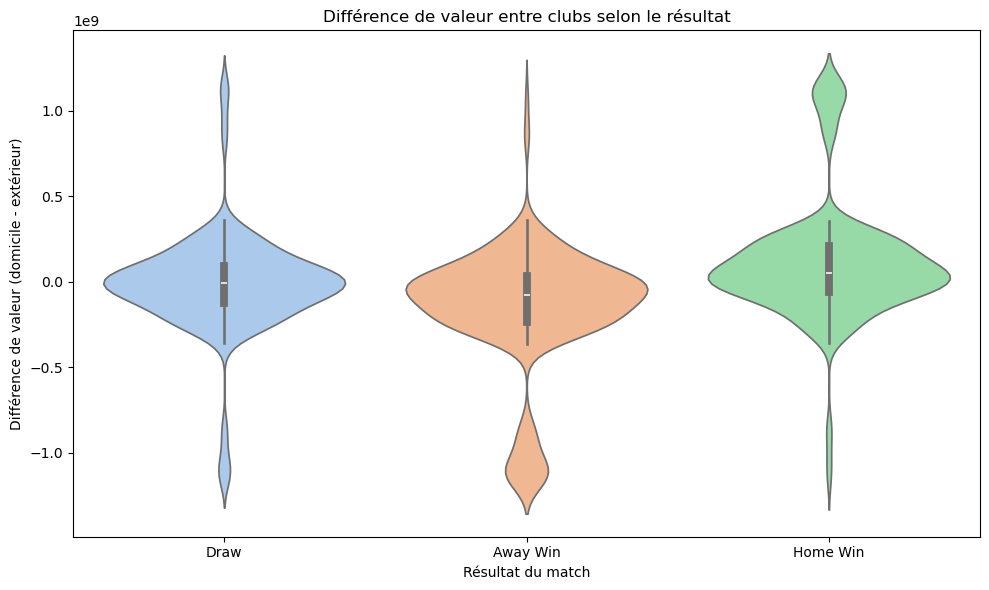

In [79]:
# 📋 Travail sur une copie spécifique
matchs_val = matchs_enriched.copy()

# 🔢 Calcul de la différence home - away
matchs_val['diff_valeur'] = matchs_val['home_club_value'] - matchs_val['away_club_value']

# 🎯 Création de la variable résultat
matchs_val['resultat'] = matchs_val.apply(
    lambda row: 'Home Win' if row['home_club_goals'] > row['away_club_goals']
    else ('Away Win' if row['home_club_goals'] < row['away_club_goals'] else 'Draw'),
    axis=1
)

# 🎨 Violinplot
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=matchs_val,
    x='resultat',
    y='diff_valeur',
    hue='resultat',
    palette='pastel',
    legend=False,
    inner='box'
)
plt.title("Différence de valeur entre clubs selon le résultat")
plt.xlabel("Résultat du match")
plt.ylabel("Différence de valeur (domicile - extérieur)")
plt.tight_layout()
plt.show()


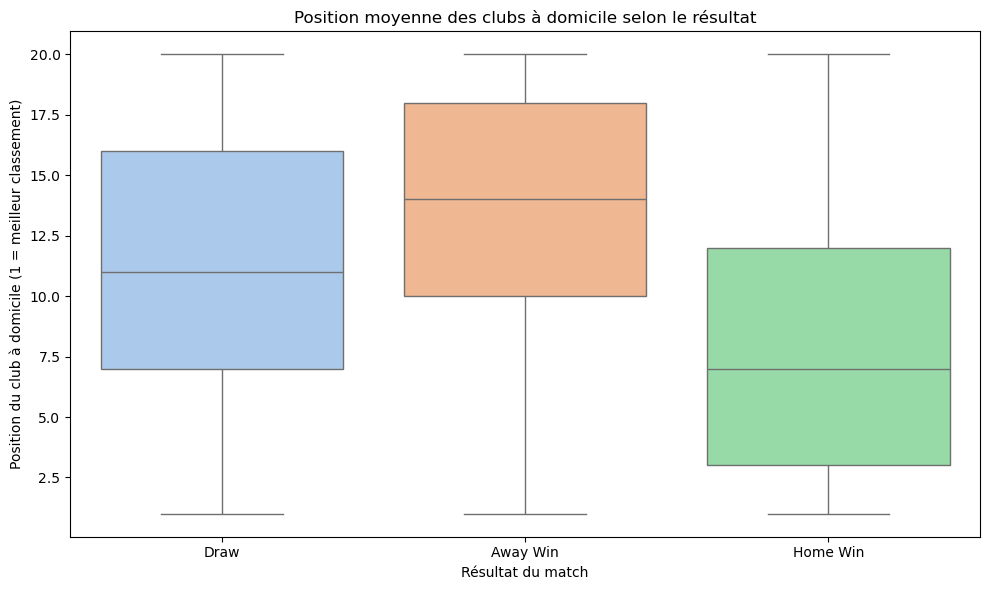

In [80]:
# 📋 Travail sur une copie spécifique
matchs_pos = matchs_enriched.copy()

# 🎯 Création de la variable résultat
matchs_pos['resultat'] = matchs_pos.apply(
    lambda row: 'Home Win' if row['home_club_goals'] > row['away_club_goals']
    else ('Away Win' if row['home_club_goals'] < row['away_club_goals'] else 'Draw'),
    axis=1
)

# 🎨 Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=matchs_pos,
    x='resultat',
    y='home_club_position',
    hue='resultat',
    palette='pastel',
    legend=False
)
plt.title("Position moyenne des clubs à domicile selon le résultat")
plt.xlabel("Résultat du match")
plt.ylabel("Position du club à domicile (1 = meilleur classement)")
plt.tight_layout()
plt.show()


## ✅ Conclusion de la Section 3 – Exploration des Données

L’analyse exploratoire menée sur l’ensemble des fichiers (`matchs.csv`, `clubs.csv`, `appearances.csv`, `lineups.csv`, `events.csv`, `valuations.csv`) a permis de mieux comprendre les dynamiques structurelles des données et d’identifier des patterns utiles pour la modélisation.

Nous avons mis en évidence plusieurs éléments pertinents sur les performances, les clubs et les joueurs, ainsi que des pistes solides pour créer des features explicatives.

---

📈 Focus : Trois croisements particulièrement informatifs

🔁 1. **Valeur totale de l’équipe à domicile vs buts marqués**
- Une corrélation positive est observée entre la **valeur totale de l’équipe à domicile** (transformée en échelle logarithmique) et le **nombre moyen de buts marqués**.
- Plus la valeur de l’équipe est élevée, plus elle semble marquer de buts.
- ✅ Cette relation suggère que la **richesse d’un club est un facteur pertinent** pour prédire ses performances offensives.

⚖️ 2. **Différence de valeur entre les clubs vs résultat du match**
- Le *violinplot* montre que les équipes qui gagnent à domicile ont généralement une **valeur supérieure** à celle de l’équipe adverse.
- À l’inverse, les victoires à l’extérieur sont souvent associées à une **valeur inférieure du club à domicile**.
- ✅ La **différence de valeur entre les deux clubs** est un indicateur stratégique de l’issue potentielle d’un match.

📊 3. **Position moyenne des clubs à domicile selon le résultat**
- Les clubs **mieux classés** (plus proches de la 1re place) ont significativement plus de victoires à domicile.
- Les défaites à domicile sont plus fréquentes chez les clubs **mal classés**.
- ✅ La **position au classement** est une variable directement corrélée à la probabilité de victoire à domicile.

---

🧠 En résumé

- L’exploration des données a mis en évidence plusieurs variables **fortement corrélées aux performances** :
  - la **valeur monétaire des clubs**,
  - leur **position au classement**,
  - la **différence de niveau** entre les équipes.

Ces éléments constituent une **base précieuse pour la construction de features robustes** dans la suite du projet.

---

➡️ Nous allons maintenant passer à la **Section 4 : Feature Engineering**, où nous allons exploiter les enseignements tirés de l'exploration pour construire des variables explicatives solides en vue de la modélisation.


# 4. Feature Engineering

Dans cette section, nous allons préparer et enrichir notre dataset principal (`matchs`) pour l'entraînement des modèles de machine learning.  
L'objectif est de construire des features robustes en respectant strictement la séparation temporelle entre passé (train) et futur (test).

---

## 4.1 Encodage des variables catégorielles

**Objectif** :  
Transformer les variables catégorielles (`home_club_id`, `away_club_id`, etc.) en formats numériques utilisables par les modèles.

**Méthodologie** :  
- Encodage effectué directement sur le dataframe `matchs` avant toute séparation train/test.
- Création d'une classe dédiée `ClubEncoder` pour encoder les identifiants de clubs.
- Le mapping est appris sur l’ensemble de `matchs`, en conservant les correspondances pour les réutiliser après le split.

---

## 4.2 Création et ajout des nouvelles features sur `matchs`

Dans cette section, nous allons enrichir `matchs` avec des variables pertinentes, construites uniquement à partir d’informations disponibles au moment du match, sans jamais inclure d’information future.

---

### 4.2.1 Features de base

- Différence de position au classement (`diff_position`)
- Différence de valeur marchande (`diff_valeur`)
- Logarithme des valeurs d'équipe (`home_club_value_log`, `away_club_value_log`)
- Moyennes simples sur les buts marqués et encaissés (`home_club_goals_avg`, `away_club_goals_avg`, `goal_difference`)

---

### 4.2.2 Features avancées

#### 4.2.2.1 Forme récente

- Moyenne des points obtenus sur les 5 derniers matchs (`recent_form_home`, `recent_form_away`)
- Moyenne de buts marqués et encaissés sur les 5 derniers matchs (`home_recent_goals_scored_avg`, `away_recent_goals_scored_avg`, `home_recent_goals_conceded_avg`, `away_recent_goals_conceded_avg`)

#### 4.2.2.2 Discipline

- Moyenne de cartons jaunes et rouges sur les 5 derniers matchs (`home_yellow_cards_avg`, `away_yellow_cards_avg`, `home_red_cards_avg`, `away_red_cards_avg`)

#### 4.2.2.3 Force offensive et défensive

- Moyenne de buts marqués (`home_goals_scored_avg`, `away_goals_scored_avg`)
- Moyenne de buts encaissés (`home_goals_conceded_avg`, `away_goals_conceded_avg`)

#### 4.2.2.4 Séries de victoires et défaites

- Nombre de victoires consécutives (`home_win_streak`, `away_win_streak`)
- Nombre de défaites consécutives (`home_loss_streak`, `away_loss_streak`)

---

### 4.2.3 Features ultra avancées

#### 4.2.3.1 Clean Sheets (solidité défensive)

- Pourcentage de matchs sans encaisser de but sur les 5 derniers matchs (`home_clean_sheets_avg`, `away_clean_sheets_avg`)

#### 4.2.3.2 Autres idées avancées

- Matchs prolifiques (2+ buts marqués)
- Ratio d'efficacité offensive / défensive
- Indices combinés de performance et momentum
- Contribution pondérée des joueurs titulaires

---

✅ Validation temporelle des features

Pour chaque feature :
- On s’assure que **seuls les matchs passés (strictement antérieurs)** sont utilisés.
- Le match courant n'est **jamais inclus** dans les moyennes ou séries.
- Les transformations sont appliquées en respectant l’ordre chronologique, via `groupby().apply()` ou des boucles progressives.

---

## 4.3 Encodage des variables issues des features créées

Certaines des nouvelles features peuvent introduire des variables catégorielles ou ordinales.  
Il convient d’appliquer des encodages supplémentaires (si nécessaire) pour assurer leur compatibilité avec les modèles supervisés.

---

## 4.4 Split du dataset - Séparation Train/Test

**Objectif** :  
Séparer `matchs` en deux sous-ensembles pour la modélisation :

- **80% pour l'entraînement** (`matchs_train`)
- **20% pour la validation finale** (`matchs_test`)

**Méthodologie** :
- Split réalisé **après** la création de toutes les features et l’encodage.
- Le split est **temporel**, basé sur la date ou la saison, pour garantir qu’aucune donnée future ne soit incluse dans l’entraînement.
- Pas de stratification, afin de respecter la logique chronologique.

---

## 4.5 Application des features sur le set de test

Comme toutes les features sont construites **avant le split** sur l’historique de `matchs`, elles sont déjà disponibles dans `matchs_test`.

**Important** :  
Chaque ligne du set de test ne contient que des agrégations basées sur des données antérieures à la date du match.  
Aucune fuite de données n’est possible si les calculs sont correctement faits sur l’historique trié chronologiquement.

---

## 4.6 Construction finale des datasets X et y

**Objectif** :
- Extraire les matrices finales d'entraînement et de test pour la modélisation :
  - `X_train`, `y_train`
  - `X_test`, `y_test`

**Méthodologie** :
- Suppression des colonnes inutiles ou non numériques.
- Nettoyage final : gestion des valeurs manquantes, alignement des colonnes.
- Vérification de la forme finale et cohérence des données avant modélisation.

---


## 4.1 Encodage des variables catégorielles

**Objectif** :  
Encoder les identifiants de clubs (`home_club_id`, `away_club_id`) sous forme numérique pour les modèles de machine learning.

**Méthodologie** :  
- Création d'une classe `ClubEncoder` pour gérer l'encodage de manière propre et réutilisable.
- L'encodage est effectué **directement sur le dataset `matchs`**, avant toute séparation entre train/test.
- Le mapping club_id → index est appris sur la totalité des données disponibles.
- Deux nouvelles colonnes sont créées :
  - `home_club_id_enc`
  - `away_club_id_enc`

**Pourquoi encoder maintenant ?**  
Cela garantit que tous les matchs utilisent un référentiel d'identifiants commun, tout en permettant d'appliquer les mêmes transformations plus tard au besoin.

---


In [84]:
# 4.1 - ClubEncoder : Encodage des identifiants de clubs

import pandas as pd

class ClubEncoder:
    """
    Classe pour encoder les identifiants de clubs dans le dataframe `matchs`.
    Permet de transformer les club_id en indices numériques cohérents.
    """
    def __init__(self):
        self.club_to_index = {}

    def fit(self, df, columns=['home_club_id', 'away_club_id']):
        """
        Enregistre le mapping club_id -> index unique sur les colonnes données.
        """
        unique_ids = pd.concat([df[col] for col in columns]).unique()
        self.club_to_index = {club_id: idx for idx, club_id in enumerate(sorted(unique_ids))}

    def transform(self, df, columns=['home_club_id', 'away_club_id']):
        """
        Applique le mapping club_id -> index sur les colonnes données.
        """
        for col in columns:
            df[col + '_enc'] = df[col].map(self.club_to_index)
        return df

    def fit_transform(self, df, columns=['home_club_id', 'away_club_id']):
        self.fit(df, columns)
        return self.transform(df, columns)

# --- Application sur le dataset `matchs` ---

# Assurez-vous que 'matchs' est déjà chargé et prêt
club_encoder = ClubEncoder()
matchs = club_encoder.fit_transform(matchs, columns=['home_club_id', 'away_club_id'])

# Vérification
matchs[['home_club_id', 'home_club_id_enc', 'away_club_id', 'away_club_id_enc']].head()


,home_club_id,home_club_id_enc,away_club_id,away_club_id_enc
0,618,10,595,9
1,14171,33,855,14
2,1423,28,1082,18
3,273,3,14171,33
4,1147,20,273,3


## 4.2 Création de nouvelles features sur `matchs`

Dans cette section, nous allons construire et enrichir notre dataset principal `matchs` avec de nouvelles variables,  
en partant de simples différences jusqu'à des indicateurs plus complexes et dynamiques.

Toutes les features sont créées directement sur `matchs`, en respectant strictement l’ordre chronologique.  
Aucune information postérieure à la date d’un match ne doit être utilisée dans les calculs de features.

---

### 4.2.1 Features de base

- Différence de position au classement (`diff_position`)
- Différence de valeur marchande (`diff_valeur`)
- Logarithme des valeurs d'équipe (`home_club_value_log`, `away_club_value_log`)
- Différences simples sur les buts marqués et encaissés (`home_club_goals_avg`, `away_club_goals_avg`, `goal_difference`)

---

### 4.2.2 Features avancées

#### 4.2.2.1 Forme récente

- Moyenne des points obtenus sur les 5 derniers matchs (`recent_form_home`, `recent_form_away`)
- Moyenne de buts marqués et encaissés récemment (`home_recent_goals_scored_avg`, `away_recent_goals_scored_avg`, `home_recent_goals_conceded_avg`, `away_recent_goals_conceded_avg`)

#### 4.2.2.2 Discipline

- Moyenne de cartons jaunes et rouges par équipe sur les 5 derniers matchs (`home_yellow_cards_avg`, `away_yellow_cards_avg`, `home_red_cards_avg`, `away_red_cards_avg`)

#### 4.2.2.3 Force offensive et défensive

- Moyenne de buts marqués (`home_goals_scored_avg`, `away_goals_scored_avg`)
- Moyenne de buts encaissés (`home_goals_conceded_avg`, `away_goals_conceded_avg`)

#### 4.2.2.4 Séries de victoires et défaites

- Nombre de victoires consécutives (`home_win_streak`, `away_win_streak`)
- Nombre de défaites consécutives (`home_loss_streak`, `away_loss_streak`)

---

### 4.2.3 Features ultra avancées

#### 4.2.3.1 Clean Sheets (solidité défensive)

- Pourcentage de matchs sans encaisser de but sur les 5 derniers matchs (`home_clean_sheets_avg`, `away_clean_sheets_avg`)

#### 4.2.3.2 Autres idées avancées

- Matchs prolifiques (2+ buts marqués)
- Ratio d'efficacité offensive / défensive
- Indices combinés de performance et momentum
- Contribution pondérée des joueurs titulaires

---

**⚠️ Important** :  
Toutes les agrégations doivent respecter la temporalité : un match donné ne peut utiliser **que des données passées** (matchs antérieurs du même club).


### 4.2.1 Création des features de base

Dans cette sous-partie, nous créons des premières variables simples mais essentielles pour modéliser les résultats des matchs.  
Ces features sont calculées directement à partir du dataset `matchs`, en respectant l'ordre chronologique, sans jamais inclure d'information future.

Les features créées sont :

- **Différence de classement (`diff_position`)** : écart entre la position au classement du club à domicile et celui à l'extérieur.
- **Différence de valeur économique (`diff_valeur`)** : écart entre la valeur marchande des deux clubs.
- **Log-transform des valeurs (`home_club_value_log`, `away_club_value_log`)** : transformation logarithmique pour stabiliser l’échelle des valeurs économiques.
- **Moyenne historique des buts marqués (`home_club_goals_avg`, `away_club_goals_avg`)** : moyenne progressive des buts marqués par club, calculée uniquement sur les matchs antérieurs à chaque ligne (sans fuite de données).
- **Différence de buts dans le match (`goal_difference`)** : score net (utile à des fins exploratoires ou pour d’autres features dérivées).

Chaque feature est construite de manière robuste, avec attention à l’ordre temporel, pour garantir leur validité dans le cadre d’une modélisation supervisée.


In [87]:
import numpy as np

# --- Fusion des valeurs marchandes : home et away ---
matchs = matchs.merge(
    club_values.rename(columns={'club_id': 'home_club_id', 'total_market_value': 'home_club_value'}),
    on='home_club_id',
    how='left'
)

matchs = matchs.merge(
    club_values.rename(columns={'club_id': 'away_club_id', 'total_market_value': 'away_club_value'}),
    on='away_club_id',
    how='left'
)

# --- 1. Différence de position au classement ---
matchs['diff_position'] = matchs['home_club_position'] - matchs['away_club_position']

# --- 2. Différence de valeur économique ---
matchs['diff_valeur'] = matchs['home_club_value'] - matchs['away_club_value']

# --- 3. Transformation logarithmique des valeurs économiques ---
matchs['home_club_value_log'] = np.log1p(matchs['home_club_value'])
matchs['away_club_value_log'] = np.log1p(matchs['away_club_value'])

# --- 4. Moyenne de buts par club ---

# Assurer le tri temporel global
matchs = matchs.sort_values('date').reset_index(drop=True)

# Moyenne progressive des buts marqués à domicile
home_goals_avg = (
    matchs
    .groupby('home_club_id')['home_club_goals']
    .apply(lambda x: x.shift().expanding().mean())
    .reset_index(drop=True)  # aligne l’index avec `matchs`
)

# Moyenne progressive des buts marqués à l'extérieur
away_goals_avg = (
    matchs
    .groupby('away_club_id')['away_club_goals']
    .apply(lambda x: x.shift().expanding().mean())
    .reset_index(drop=True)
)

# Ajout des colonnes au DataFrame principal
matchs['home_club_goals_avg'] = home_goals_avg
matchs['away_club_goals_avg'] = away_goals_avg


# --- 5. Différence de score brut ---
matchs['goal_difference'] = matchs['home_club_goals'] - matchs['away_club_goals']

# --- Vérification rapide ---
matchs[['diff_position', 'diff_valeur', 'goal_difference']].head(10)

matchs[['home_club_id', 'home_club_goals', 'home_club_goals_avg']].head(10)


,home_club_id,home_club_goals,home_club_goals_avg
0,969,1,NaN
1,14171,2,1.000000
2,750,2,1.000000
3,417,0,1.333333
4,583,2,1.250000
5,1159,1,1.200000
6,618,1,1.166667
7,1095,0,1.285714
8,273,0,1.125000
9,1421,0,1.000000


### 4.2.2 Création des features avancées

Dans cette sous-partie, nous allons enrichir davantage notre dataset principal (`matchs`)  
en construisant des variables capables de capturer des dynamiques sportives fines et des éléments contextuels essentiels.

Les principales features avancées créées sont :

- **Forme récente des clubs** : moyenne des points obtenus et des buts marqués/encaissés sur les derniers matchs,
- **Discipline des équipes** : nombre moyen de cartons jaunes et rouges reçus sur une période récente,
- **Forces offensives et défensives** : analyse des performances offensives et défensives moyennes sur plusieurs rencontres,
- **Séries de victoires et défaites** : mesure de la dynamique (momentum) d'une équipe au fil du temps.

Chaque feature est calculée de manière chronologique :  
les matchs postérieurs à un événement ne sont jamais pris en compte dans les moyennes ou les séries.  
Cela permet au modèle d’intégrer de manière réaliste l’état de forme, la discipline et la dynamique des équipes.

---


#### 📄 Forme récente

**Objectif** :  
Quantifier la dynamique récente des équipes avant chaque rencontre, en capturant leur état de forme sur les derniers matchs joués.

**Features créées** :
- `recent_form_home` : moyenne des points obtenus par le club à domicile sur ses 5 derniers matchs.
- `recent_form_away` : moyenne des points obtenus par le club à l’extérieur sur ses 5 derniers matchs.

**Méthodologie** :
- Attribution des points : 3 pour une victoire, 1 pour un nul, 0 pour une défaite.
- Calcul d'une moyenne glissante (`rolling mean`) sur les 5 derniers matchs précédents (et non incluant) chaque rencontre.
- Application d’un `shift()` pour exclure le match courant et garantir qu’aucune information future n’est utilisée.
- Utilisation de la date pour trier les matchs dans l’ordre chronologique.

**Pourquoi c’est utile ?**  
La forme récente d’une équipe est un excellent indicateur de performance :  
une équipe en confiance a plus de chances de gagner, tandis qu’une équipe en mauvaise série est souvent plus vulnérable.

---


In [90]:
# 📋 Forme récente - Calcul temporel des moyennes de points sur les 5 derniers matchs

# 1. Attribution des points selon le résultat
def assign_points_home(result):
    return 3 if result == 1 else 1 if result == 0 else 0

def assign_points_away(result):
    return 3 if result == -1 else 1 if result == 0 else 0

# On travaille sur `matchs`, pas `matchs_train`
matchs['home_points'] = matchs['results'].apply(assign_points_home)
matchs['away_points'] = matchs['results'].apply(assign_points_away)

# 2. Tri chronologique
matchs = matchs.sort_values('date').reset_index(drop=True)

# 3. Calcul des formes récentes : rolling(5) sur les matchs précédents
matchs['recent_form_home'] = (
    matchs
    .groupby('home_club_id', group_keys=False)['home_points']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

matchs['recent_form_away'] = (
    matchs
    .groupby('away_club_id', group_keys=False)['away_points']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

In [91]:
# 🔎 Exemple : vérifier les points récents pour un club donné
example_home_club = matchs['home_club_id'].value_counts().idxmax()  # club le plus fréquent

subset_forme = (
    matchs[matchs['home_club_id'] == example_home_club]
    .sort_values('date')
    [['date', 'results', 'home_points', 'recent_form_home']]
)

print(f"📋 Forme récente (points) pour le club ID {example_home_club} :")
display(subset_forme.head(10))

# 📊 Vérification globale des NaN (doivent correspondre aux 5 premiers matchs par club)
nan_form_check = matchs[['recent_form_home', 'recent_form_away']].isna().sum()
print("\n🧮 Nombre de NaN dans recent_form_home / away :")
print(nan_form_check)


📋 Forme récente (points) pour le club ID 417 :


,date,results,home_points,recent_form_home
3,2012-08-11,-1,0,NaN
22,2012-08-25,0,1,NaN
42,2012-09-15,1,3,NaN
64,2012-09-29,0,1,NaN
83,2012-10-20,0,1,NaN
99,2012-11-03,1,3,1.2
127,2012-11-18,1,3,1.8
144,2012-12-01,1,3,2.2
161,2012-12-11,1,3,2.2
175,2012-12-15,1,3,2.6



🧮 Nombre de NaN dans recent_form_home / away :
recent_form_home    170
recent_form_away    170
dtype: int64


#### 📄 (Suite) Forme récente – Buts marqués et encaissés

**Objectif** :  
Mesurer la capacité récente des équipes à marquer et à encaisser des buts,  
en se basant uniquement sur leurs matchs précédents.

**Features créées** :
- `home_recent_goals_scored_avg` : moyenne des buts marqués par le club à domicile sur ses 5 derniers matchs.
- `away_recent_goals_scored_avg` : moyenne des buts marqués par le club à l’extérieur sur ses 5 derniers matchs.
- `home_recent_goals_conceded_avg` : moyenne des buts encaissés par le club à domicile sur ses 5 derniers matchs.
- `away_recent_goals_conceded_avg` : moyenne des buts encaissés par le club à l’extérieur sur ses 5 derniers matchs.

**Méthodologie** :
- Calcul d'une moyenne glissante (`rolling mean`) des buts marqués et encaissés pour chaque club.
- Utilisation d’une fenêtre de 5 matchs minimum (`min_periods=5`) pour garantir des statistiques fiables.
- Application d’un `shift()` pour exclure le match courant du calcul.
- Tri chronologique des matchs par date, pour respecter la temporalité.

**Pourquoi c’est utile ?**  
La capacité récente à marquer ou à encaisser des buts est un indicateur fort de la forme offensive ou défensive d'une équipe,  
et permet de mieux anticiper son comportement lors des prochains matchs.

---


In [93]:
# 📋 Moyennes récentes des buts marqués et encaissés (temporellement valides)

# 1. Tri chronologique global
matchs = matchs.sort_values('date').reset_index(drop=True)

# 2. Moyenne des buts marqués récemment

# Club à domicile
matchs['home_recent_goals_scored_avg'] = (
    matchs
    .groupby('home_club_id')['home_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

# Club à l'extérieur
matchs['away_recent_goals_scored_avg'] = (
    matchs
    .groupby('away_club_id')['away_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

# 3. Moyenne des buts encaissés récemment

# Club à domicile (buts encaissés = buts marqués par l'adversaire)
matchs['home_recent_goals_conceded_avg'] = (
    matchs
    .groupby('home_club_id')['away_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

# Club à l'extérieur
matchs['away_recent_goals_conceded_avg'] = (
    matchs
    .groupby('away_club_id')['home_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

matchs[['home_club_id', 'home_club_goals', 'home_recent_goals_scored_avg']].head(10)


,home_club_id,home_club_goals,home_recent_goals_scored_avg
0,969,1,NaN
1,14171,2,NaN
2,750,2,NaN
3,417,0,NaN
4,583,2,NaN
5,1159,1,1.2
6,618,1,1.2
7,1095,0,1.4
8,273,0,1.0
9,1421,0,0.8


#### 📄 Discipline

**Objectif** :  
Évaluer la discipline des équipes en comptabilisant les cartons jaunes et rouges reçus récemment,  
ce qui peut impacter leur performance future (suspensions, infériorité numérique, instabilité mentale).

**Features créées** :
- `home_yellow_cards_avg` : moyenne des cartons jaunes reçus par le club à domicile sur ses 5 derniers matchs.
- `away_yellow_cards_avg` : moyenne des cartons jaunes reçus par le club à l’extérieur sur ses 5 derniers matchs.
- `home_red_cards_avg` : moyenne des cartons rouges reçus par le club à domicile sur ses 5 derniers matchs.
- `away_red_cards_avg` : moyenne des cartons rouges reçus par le club à l’extérieur sur ses 5 derniers matchs.

**Méthodologie** :
- Les données de cartons sont extraites depuis le fichier `appearances.csv`, qui enregistre les statistiques individuelles des joueurs.
- Pour chaque match, les cartons sont agrégés par club (`sum` des joueurs appartenant à chaque équipe).
- Ces valeurs sont ensuite fusionnées dans le dataset `matchs`, puis transformées en **moyennes glissantes** (`rolling mean`) sur les 5 derniers matchs antérieurs à chaque rencontre.
- Un `shift()` est appliqué pour garantir que les moyennes n'incluent **jamais le match courant**.
- Les NaN (premiers matchs d’un club sans historique suffisant) sont conservés pour respecter la rigueur temporelle.

**Pourquoi c’est utile ?**  
Les équipes accumulant des cartons ont plus de risques de suspension, de fatigue mentale ou de désorganisation tactique.  
Ces signaux disciplinaires sont donc des indicateurs indirects de fragilité potentielle.

---


In [95]:
# 📋 Discipline – Extraction à partir de `appearances.csv` + intégration dans `matchs`

# 1. Agrégation des cartons par match et club (somme des joueurs)
cards_agg = (
    appearances
    .groupby(['game_id', 'player_club_id'])[['yellow_cards', 'red_cards']]
    .sum()
    .reset_index()
    .rename(columns={'player_club_id': 'club_id'})
)

# 2. Fusion dans `matchs` pour l’équipe à domicile
matchs = matchs.merge(
    cards_agg,
    how='left',
    left_on=['game_id', 'home_club_id'],
    right_on=['game_id', 'club_id']
).rename(columns={
    'yellow_cards': 'home_yellow_cards',
    'red_cards': 'home_red_cards'
}).drop(columns='club_id')

# 3. Fusion dans `matchs` pour l’équipe à l’extérieur
matchs = matchs.merge(
    cards_agg,
    how='left',
    left_on=['game_id', 'away_club_id'],
    right_on=['game_id', 'club_id']
).rename(columns={
    'yellow_cards': 'away_yellow_cards',
    'red_cards': 'away_red_cards'
}).drop(columns='club_id')

# 4. Remplir les valeurs manquantes (matchs sans carton)
cols = ['home_yellow_cards', 'home_red_cards', 'away_yellow_cards', 'away_red_cards']
matchs[cols] = matchs[cols].fillna(0).astype(int)

# 5. Tri temporel global
matchs = matchs.sort_values('date').reset_index(drop=True)

# 6. Moyennes disciplinaires (5 derniers matchs précédents, avec shift)
matchs['home_yellow_cards_avg'] = (
    matchs.groupby('home_club_id')['home_yellow_cards']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

matchs['away_yellow_cards_avg'] = (
    matchs.groupby('away_club_id')['away_yellow_cards']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

matchs['home_red_cards_avg'] = (
    matchs.groupby('home_club_id')['home_red_cards']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

matchs['away_red_cards_avg'] = (
    matchs.groupby('away_club_id')['away_red_cards']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)


In [96]:
# 📋 Vérification rapide des features disciplinaires

# Exemple : afficher 10 premières lignes triées par date pour un club (modifie l'ID si besoin)
example_club_id = matchs['home_club_id'].value_counts().idxmax()  # club le plus fréquent
subset = (
    matchs[matchs['home_club_id'] == example_club_id]
    .sort_values('date')[['date', 'home_yellow_cards', 'home_yellow_cards_avg', 'home_red_cards', 'home_red_cards_avg']]
)

print(f"🔎 Vérification des moyennes disciplinaires pour le club ID {example_club_id} :")
print(subset.head(10))

# Vérification générale : nombre de NaN dans chaque moyenne
nan_counts = matchs[['home_yellow_cards_avg', 'away_yellow_cards_avg', 'home_red_cards_avg', 'away_red_cards_avg']].isna().sum()
print("\n📊 Nombre de NaN dans les features disciplinaires (attendus pour les 5 premiers matchs par club) :")
print(nan_counts)

🔎 Vérification des moyennes disciplinaires pour le club ID 417 :
          date  home_yellow_cards  home_yellow_cards_avg  home_red_cards  \
3   2012-08-11                  2                    NaN               0   
21  2012-08-25                  1                    2.0               0   
42  2012-09-15                  1                    0.8               0   
64  2012-09-29                  5                    2.2               0   
83  2012-10-20                  0                    0.8               0   
100 2012-11-03                  2                    2.0               0   
126 2012-11-18                  4                    1.6               0   
146 2012-12-01                  1                    1.8               0   
161 2012-12-11                  0                    1.4               0   
174 2012-12-15                  1                    1.4               0   

     home_red_cards_avg  
3                   NaN  
21                  0.0  
42                  

#### 📄 Force offensive et défensive

**Objectif** :  
Évaluer la capacité des équipes à marquer et à encaisser des buts,  
en s'appuyant sur leur moyenne historique de performance offensive et défensive.

**Features créées** :
- `home_goals_scored_avg` : moyenne globale des buts marqués par le club à domicile.
- `away_goals_scored_avg` : moyenne globale des buts marqués par le club à l’extérieur.
- `home_goals_conceded_avg` : moyenne globale des buts encaissés par le club à domicile.
- `away_goals_conceded_avg` : moyenne globale des buts encaissés par le club à l’extérieur.

**Méthodologie** :
- Agrégation via un `groupby().transform('mean')` pour chaque club, sur l’ensemble des données disponibles.
- Utilisation des colonnes `home_club_goals` et `away_club_goals` pour estimer les buts marqués,
- Et croisement inverse pour les buts encaissés : `away_club_goals` pour l’équipe à domicile, `home_club_goals` pour l’équipe à l’extérieur.
- Ce calcul repose sur une moyenne **globale** et non temporelle : il donne un profil moyen de performance pour chaque club.

**Pourquoi c’est utile ?**  
La propension d’un club à marquer ou à encaisser des buts est un indicateur clé de son niveau,  
et permet au modèle de distinguer plus efficacement les équipes dominantes des équipes en difficulté.

---


In [98]:
# 📋 4.3.2.3 Force offensive et défensive – Moyenne globale des buts marqués et encaissés

# --- 1. Moyenne globale des buts marqués ---

# Moyenne des buts marqués à domicile
matchs['home_goals_scored_avg'] = (
    matchs.groupby('home_club_id', observed=True)['home_club_goals']
    .transform('mean')
)

# Moyenne des buts marqués à l'extérieur
matchs['away_goals_scored_avg'] = (
    matchs.groupby('away_club_id', observed=True)['away_club_goals']
    .transform('mean')
)

# --- 2. Moyenne globale des buts encaissés ---

# Moyenne des buts encaissés à domicile (par l'adversaire extérieur)
matchs['home_goals_conceded_avg'] = (
    matchs.groupby('home_club_id', observed=True)['away_club_goals']
    .transform('mean')
)

# Moyenne des buts encaissés à l'extérieur (par l'adversaire à domicile)
matchs['away_goals_conceded_avg'] = (
    matchs.groupby('away_club_id', observed=True)['home_club_goals']
    .transform('mean')
)

# --- 3. Vérification rapide ---
print(matchs[['home_club_id', 'home_goals_scored_avg', 'home_goals_conceded_avg']].head(10))
print(matchs[['away_club_id', 'away_goals_scored_avg', 'away_goals_conceded_avg']].head(10))


   home_club_id  home_goals_scored_avg  home_goals_conceded_avg
0           969               1.500000                 1.166667
1         14171               1.333333                 1.298246
2           750               1.184211                 1.157895
3           417               1.468293                 1.048780
4           583               2.710784                 0.671569
5          1159               1.000000                 1.289474
6           618               1.510870                 1.048913
7          1095               0.978947                 1.378947
8           273               1.529412                 1.049020
9          1421               1.204819                 1.102410
   away_club_id  away_goals_scored_avg  away_goals_conceded_avg
0           415               0.880240                 1.604790
1            40               1.118280                 1.510753
2           595               0.800000                 1.831579
3          1147               0.824561  

#####  Séries de victoires et défaites

**Objectif** :  
Capturer le momentum psychologique d’une équipe à travers ses enchaînements de résultats,  
en mesurant les séries de victoires ou de défaites consécutives.

**Features créées** :
- `home_win_streak` : nombre de victoires consécutives à domicile avant le match.
- `away_win_streak` : nombre de victoires consécutives à l’extérieur avant le match.
- `home_loss_streak` : nombre de défaites consécutives à domicile avant le match.
- `away_loss_streak` : nombre de défaites consécutives à l’extérieur avant le match.

**Méthodologie** :
- Création de colonnes binaires (victoire = 1 / défaite = 1) selon le résultat du match.
- Calcul des séries consécutives (`streak`) par équipe via un cumul conditionnel (`cumsum`) réinitialisé dès qu’un résultat contraire apparaît.
- Utilisation d’un `shift()` pour exclure le match courant de la série.
- Tri des données par date pour garantir la validité chronologique.

**Pourquoi c’est utile ?**  
Les séries constituent un indicateur de dynamique : une équipe en pleine confiance ou en crise peut déjouer les attentes statistiques classiques.  
Ces effets de momentum sont souvent décisifs, surtout dans les compétitions serrées ou à fort enjeu.

---


In [100]:
# 📋 4.3.2.4 Séries de victoires et défaites – version chronologiquement correcte

# --- 1. Tri chronologique ---
matchs = matchs.sort_values('date').reset_index(drop=True)

# --- 2. Création des colonnes binaires victoire/défaite ---
matchs['home_win'] = matchs['results'].apply(lambda x: 1 if x == 1 else 0)
matchs['home_loss'] = matchs['results'].apply(lambda x: 1 if x == -1 else 0)
matchs['away_win'] = matchs['results'].apply(lambda x: 1 if x == -1 else 0)
matchs['away_loss'] = matchs['results'].apply(lambda x: 1 if x == 1 else 0)

# --- 3. Fonction de streak avec reset ---
def compute_streak(series):
    streak = []
    count = 0
    for value in series:
        if value == 1:
            count += 1
        else:
            count = 0
        streak.append(count)
    return streak

# --- 4. Application avec shift pour exclure le match courant ---
for team_type in ['home', 'away']:
    for result_type in ['win', 'loss']:
        col = f"{team_type}_{result_type}"
        streak_col = f"{col}_streak"

        matchs[streak_col] = (
            matchs
            .groupby(f'{team_type}_club_id', observed=True)[col]
            .apply(lambda x: compute_streak(x.shift().fillna(0)))
            .reset_index(drop=True)
        )

# --- 5. Vérification ---
print(matchs[['home_club_id', 'home_win_streak', 'home_loss_streak']].head(10))
print(matchs[['away_club_id', 'away_win_streak', 'away_loss_streak']].head(10))


   home_club_id                                    home_win_streak  \
0           969  [0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, ...   
1         14171  [0, 1, 0, 1, 2, 3, 4, 0, 1, 2, 0, 1, 0, 1, 2, ...   
2           750  [0, 1, 2, 3, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 0, ...   
3           417  [0, 0, 1, 0, 1, 2, 3, 0, 0, 1, 0, 0, 1, 0, 0, ...   
4           583  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, ...   
5          1159  [0, 0, 1, 2, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
6           618  [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 0, ...   
7          1095  [0, 0, 0, 1, 0, 0, 1, 2, 3, 4, 5, 6, 0, 0, 1, ...   
8           273  [0, 0, 0, 1, 2, 3, 0, 0, 1, 2, 3, 0, 1, 2, 3, ...   
9          1421  [0, 1, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 2, ...   

                                    home_loss_streak  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, ...  
3  [0, 1,

### 4.3.4 Features Ultra Avancées

**Objectif** :  
Aller au-delà des indicateurs classiques en intégrant des variables plus complexes et informatives,  
capables de capturer des dynamiques plus subtiles dans les performances d'équipe.

---

**Exemples de features créées ou envisageables** :

- 📌 **Clean Sheets (solide défense)**  
  Proportion de matchs sans encaisser de but sur les 5 derniers matchs (`clean_sheets_rate`).

- 🎯 **Efficacité offensive**  
  Ratio entre buts marqués et tirs cadrés (si disponibles) → indicateur de réalisme offensif.

- 🛡 **Efficacité défensive**  
  Ratio entre buts encaissés et tirs concédés → mesure de la résilience défensive.

- ⚖️ **Indice de performance pondéré**  
  Score composite agrégé (forme, discipline, séries) pour estimer la “santé” globale du club.

- 🔁 **Momentum combiné**  
  Fusion pondérée de toutes les dynamiques temporelles en un seul indicateur de confiance.

- 🧩 **Contribution des joueurs clés** *(optionnel)*  
  Pondération de l'impact des titulaires selon leurs statistiques individuelles (goals, assists, defensive actions...).

---

**Pourquoi ces features ?**
- Permettent de différencier des clubs aux profils similaires en surface mais très différents dans leur efficacité réelle.
- Capturent des logiques complexes et interactions croisées souvent invisibles pour un modèle classique.
- Peuvent significativement améliorer la robustesse prédictive du modèle, en particulier sur les cas limites ou incertains.

---

**Méthodologie recommandée** :
- Utiliser des moyennes mobiles glissantes (avec ou sans pondération).
- Appliquer une normalisation ou standardisation des composantes avant combinaison.
- Tester l'influence de chaque sous-indicateur en validation croisée pour éviter la redondance ou le bruit.

---


#### 📄 Clean Sheets (solidité défensive)

**Objectif** :  
Mesurer la solidité défensive des équipes en calculant la proportion de matchs récents où elles n'ont pas encaissé de but.

**Features créées** :
- `home_clean_sheets_avg` : proportion de clean sheets à domicile sur les 5 derniers matchs.
- `away_clean_sheets_avg` : proportion de clean sheets à l’extérieur sur les 5 derniers matchs.

**Méthodologie** :
- Création d'une variable binaire indiquant si l'équipe a réalisé un clean sheet lors d'un match.
- Calcul d'une moyenne glissante (`rolling mean`) sur les 5 derniers matchs pour chaque club.
- Respect de l’ordre chronologique avec un tri sur la date.
- Utilisation de `min_periods=5` pour garantir des statistiques fiables.

**Pourquoi c’est utile ?**  
Une équipe qui parvient régulièrement à conserver sa cage inviolée montre une très forte organisation défensive,  
ce qui est un prédicteur clé de la capacité à obtenir des points.

---


In [103]:
# 📋 Clean Sheets – Moyenne glissante sur 5 matchs

# --- 1. Créer la variable binaire : clean sheet ou non ---
matchs['home_clean_sheet'] = (matchs['away_club_goals'] == 0).astype(int)
matchs['away_clean_sheet'] = (matchs['home_club_goals'] == 0).astype(int)

# --- 2. Tri chronologique ---
matchs = matchs.sort_values('date').reset_index(drop=True)

# --- 3. Moyenne glissante avec exclusion du match courant (shift) ---

matchs['home_clean_sheets_avg'] = (
    matchs
    .groupby('home_club_id', observed=True)['home_clean_sheet']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

matchs['away_clean_sheets_avg'] = (
    matchs
    .groupby('away_club_id', observed=True)['away_clean_sheet']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

In [104]:
# 🔍 Exemple : vérification des clean sheets pour un club donné (domicile)
example_club = matchs['home_club_id'].value_counts().idxmax()

subset_clean = (
    matchs[matchs['home_club_id'] == example_club]
    .sort_values('date')
    [['date', 'home_club_goals', 'away_club_goals', 'home_clean_sheet', 'home_clean_sheets_avg']]
)

print(f"📊 Clean sheets à domicile pour le club ID {example_club} :")
display(subset_clean.head(10))

# 🔢 Vérification des NaN attendus
nan_check = matchs[['home_clean_sheets_avg', 'away_clean_sheets_avg']].isna().sum()
print("\n📌 Nombre de NaN dans les moyennes de clean sheets :")
print(nan_check)


📊 Clean sheets à domicile pour le club ID 417 :


,date,home_club_goals,away_club_goals,home_clean_sheet,home_clean_sheets_avg
3,2012-08-11,0,1,0,NaN
22,2012-08-25,2,2,0,0.2
42,2012-09-15,4,2,0,0.0
64,2012-09-29,2,2,0,0.4
83,2012-10-20,1,1,0,0.2
101,2012-11-03,2,1,0,0.0
128,2012-11-18,1,0,1,0.4
145,2012-12-01,2,1,0,0.4
161,2012-12-11,1,0,1,0.2
176,2012-12-15,3,2,0,0.0



📌 Nombre de NaN dans les moyennes de clean sheets :
home_clean_sheets_avg    170
away_clean_sheets_avg    170
dtype: int64


#### 📄 Matchs prolifiques (au moins 2 buts marqués)

**Objectif** :  
Capturer l’agressivité offensive des équipes en calculant la proportion de matchs où elles ont marqué au moins 2 buts lors des 5 dernières rencontres.

**Features créées** :
- `home_prolific_matches_avg` : proportion de matchs avec ≥ 2 buts marqués à domicile.
- `away_prolific_matches_avg` : proportion de matchs avec ≥ 2 buts marqués à l’extérieur.

**Méthodologie** :
- Définir un indicateur binaire (`1` si l’équipe marque ≥ 2 buts, `0` sinon).
- Calculer une moyenne glissante (`rolling mean`) sur les 5 derniers matchs pour évaluer la régularité offensive.
- Utiliser `min_periods=5` pour assurer la fiabilité statistique.
- Respecter la chronologie avec un tri sur la date.

**Pourquoi c’est utile ?**  
Une équipe capable de marquer plusieurs buts de manière régulière dispose d’un fort avantage stratégique,  
notamment pour dominer les matchs serrés ou revenir après avoir concédé un but.

---


In [106]:
# 📋  Matchs Prolifiques – Moyenne glissante sur 5 matchs

# --- 1. Création des variables binaires : au moins 2 buts marqués ? ---
matchs['home_prolific'] = (matchs['home_club_goals'] >= 2).astype(int)
matchs['away_prolific'] = (matchs['away_club_goals'] >= 2).astype(int)

# --- 2. Tri chronologique ---
matchs = matchs.sort_values('date').reset_index(drop=True)

# --- 3. Moyenne glissante (rolling) avec exclusion du match en cours ---
matchs['home_prolific_matches_avg'] = (
    matchs
    .groupby('home_club_id', observed=True)['home_prolific']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

matchs['away_prolific_matches_avg'] = (
    matchs
    .groupby('away_club_id', observed=True)['away_prolific']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)


In [107]:
# 🔍 Exemple : vérification des matchs prolifiques pour un club (domicile)
example_club = matchs['home_club_id'].value_counts().idxmax()

subset_prolific = (
    matchs[matchs['home_club_id'] == example_club]
    .sort_values('date')
    [['date', 'home_club_goals', 'home_prolific', 'home_prolific_matches_avg']]
)

print(f"📊 Matchs prolifiques à domicile pour le club ID {example_club} :")
display(subset_prolific.head(10))

# 🔢 Vérification des NaN (5 premiers matchs)
nan_check_prolific = matchs[['home_prolific_matches_avg', 'away_prolific_matches_avg']].isna().sum()
print("\n📌 Nombre de NaN dans les moyennes de matchs prolifiques :")
print(nan_check_prolific)


📊 Matchs prolifiques à domicile pour le club ID 417 :


,date,home_club_goals,home_prolific,home_prolific_matches_avg
3,2012-08-11,0,0,NaN
26,2012-08-25,2,1,0.4
42,2012-09-15,4,1,0.6
63,2012-09-29,2,1,0.4
83,2012-10-20,1,0,0.4
104,2012-11-03,2,1,0.2
126,2012-11-18,1,0,0.6
142,2012-12-01,2,1,0.6
161,2012-12-11,1,0,0.2
172,2012-12-15,3,1,0.6



📌 Nombre de NaN dans les moyennes de matchs prolifiques :
home_prolific_matches_avg    170
away_prolific_matches_avg    170
dtype: int64


#### 📄 Momentum Combiné

**Objectif** :  
Construire un indicateur synthétique qui capture l’élan global d’une équipe avant un match,  
en combinant plusieurs dimensions : performance récente, discipline, et dynamique de résultats.

---

**Features créées** :
- `home_momentum` : score global de momentum pour le club à domicile.
- `away_momentum` : score global de momentum pour le club à l’extérieur.

---

**Composantes utilisées** :
- ✅ **Forme récente** : `recent_form_home` / `recent_form_away` ➔ normalisée sur [0, 1] en divisant par 3.
- 🔁 **Séries de victoires** : `*_win_streak` ➔ divisées par une valeur max arbitraire (ex. 5 ou 6).
- 🟥 **Discipline** : moyenne des cartons rouges et jaunes ➔ pénalisée avec inversion (`1 - normalized`).

---

**Méthodologie** :
1. **Normaliser chaque composante** pour les ramener sur une échelle comparable.
2. **Combiner les trois dimensions** avec des pondérations équitables (par ex. ⅓ chacune).
3. Optionnel : **mettre à l’échelle finale** (min-max scaling) pour obtenir un score entre 0 et 1.
4. Respecter l’ordre temporel : aucune composante ne doit inclure de fuite de données.

---

**Pourquoi c’est utile ?**  
Le momentum combiné permet de capturer un signal global reflétant :
- La **confiance tactique** (résultats récents),
- La **discipline comportementale**,
- La **régularité** sur les derniers matchs.

C’est une variable latente puissante, souvent bien corrélée aux performances futures.

---


In [109]:
# 📋  Momentum Combiné – Score dynamique global

# --- 0. Correction : extraire le streak courant à partir des listes ---
matchs['home_win_streak'] = matchs['home_win_streak'].apply(lambda x: x[-1] if isinstance(x, list) else 0)
matchs['away_win_streak'] = matchs['away_win_streak'].apply(lambda x: x[-1] if isinstance(x, list) else 0)

# --- 1. Normalisations ---

# Forme récente (score max = 3)
matchs['recent_form_home_norm'] = matchs['recent_form_home'] / 3
matchs['recent_form_away_norm'] = matchs['recent_form_away'] / 3

# Discipline (plus de cartons = moins bon momentum, score max = 5 cartons)
matchs['home_discipline_norm'] = 1 - ((matchs['home_yellow_cards_avg'] + matchs['home_red_cards_avg']) / 5)
matchs['away_discipline_norm'] = 1 - ((matchs['away_yellow_cards_avg'] + matchs['away_red_cards_avg']) / 5)

# Séries de victoires (max arbitraire = 5)
matchs['home_win_streak_norm'] = matchs['home_win_streak'] / 5
matchs['away_win_streak_norm'] = matchs['away_win_streak'] / 5

# --- 2. Calcul du score global (pondérations équilibrées) ---
matchs['home_momentum'] = (
    matchs['recent_form_home_norm'].fillna(0) * 0.5 +
    matchs['home_discipline_norm'].fillna(0.5) * 0.25 +
    matchs['home_win_streak_norm'].fillna(0) * 0.25
)

matchs['away_momentum'] = (
    matchs['recent_form_away_norm'].fillna(0) * 0.5 +
    matchs['away_discipline_norm'].fillna(0.5) * 0.25 +
    matchs['away_win_streak_norm'].fillna(0) * 0.25
)

# --- 3. Vérification rapide ---
print(matchs[['home_momentum', 'away_momentum']].head(10))


   home_momentum  away_momentum
0          0.125          0.125
1          0.125          0.125
2          0.275          0.125
3          0.275          0.175
4          0.125          0.125
5          0.210          0.140
6          0.170          0.150
7          0.160          0.160
8          0.220          0.450
9          0.230          0.140


#### 📄  Différences d’avantage (momentum, clean sheets, attaque)

**Objectif** :  
Créer des indicateurs simples pour mesurer l'avantage relatif de l'équipe à domicile par rapport à l'équipe à l'extérieur.

**Features créées** :
- `momentum_diff` : différence de momentum entre l'équipe à domicile et l'équipe à l'extérieur.
- `clean_sheets_diff` : différence de proportion de clean sheets récents.
- `prolific_matches_diff` : différence d’agressivité offensive (matchs avec ≥ 2 buts marqués).

**Méthodologie** :
- Soustraction directe entre la feature de l'équipe à domicile et celle de l'équipe à l'extérieur.
- Permet d’offrir au modèle un indicateur clair d’avantage ou désavantage global sans avoir besoin de traitement complexe.

**Pourquoi c’est utile ?**  
Les différences sont souvent plus informatives que les valeurs absolues :  
elles permettent aux modèles de machine learning de mieux capturer l'effet net d'un affrontement entre deux équipes.

---


In [111]:
# 📋  Différences d’avantage entre équipes

# --- Calcul des différences simples ---

matchs['momentum_diff'] = matchs['home_momentum'] - matchs['away_momentum']
matchs['clean_sheets_diff'] = matchs['home_clean_sheets_avg'] - matchs['away_clean_sheets_avg']
matchs['prolific_matches_diff'] = matchs['home_prolific_matches_avg'] - matchs['away_prolific_matches_avg']

# --- Vérification rapide ---
print(matchs[['momentum_diff', 'clean_sheets_diff', 'prolific_matches_diff']].head(10))


   momentum_diff  clean_sheets_diff  prolific_matches_diff
0           0.00                NaN                    NaN
1           0.00                NaN                    NaN
2           0.15                NaN                    NaN
3           0.10                NaN                    NaN
4           0.00                NaN                    NaN
5           0.07               -0.2                   -0.2
6           0.02               -0.2                    0.0
7           0.00               -0.2                    0.0
8          -0.23                0.2                   -0.2
9           0.09                0.4                    0.0


## 4.3 Encodage des variables issues des features créées

**Objectif** :  
S'assurer que toutes les variables créées précédemment sont prêtes à être utilisées par les modèles de machine learning,  
et notamment qu’elles sont dans un format numérique exploitable sans ambiguïté.

---

**Méthodologie** :
- Vérification de la nature de chaque variable (catégorielle, booléenne, continue).
- Encodage ou transformation supplémentaire si nécessaire.
- Suppression ou transformation des colonnes non directement utilisables (listes, objets, etc.).

---

**Vérifications spécifiques à effectuer** :
- ✅ Toutes les colonnes de streaks (`*_streak`) ont bien été converties en **entiers scalaires**.
- ✅ Aucune colonne ne contient encore de **listes** ou **chaînes de texte** issues d'une feature mal finalisée.
- 🔍 S’assurer que toutes les variables sont bien de **type float64 / int64**, et non `object`.

---


In [113]:
# 📋 Vérification générale des types
print("🎯 Répartition des types de colonnes :")
print(matchs.dtypes.value_counts())

# 🔍 Colonnes encore de type object (non utilisables directement)
object_cols = matchs.select_dtypes(include='object').columns
print("\n📦 Colonnes de type 'object' :")
print(object_cols)

# 🧹 Nettoyage : suppression des colonnes inutiles ou résiduelles (ex: binaires intermédiaires ou listes anciennes)
colonnes_a_supprimer = [
    'home_win', 'home_loss', 'away_win', 'away_loss',
    'recent_form_home_norm', 'recent_form_away_norm',
    'home_discipline_norm', 'away_discipline_norm',
    'home_win_streak_norm', 'away_win_streak_norm'
]

matchs.drop(columns=[col for col in colonnes_a_supprimer if col in matchs.columns], inplace=True)

# 🔄 Vérification des NaN restants (à traiter avant le split)
print("\n🧪 Nombre de valeurs manquantes par colonne :")
print(matchs.isna().sum().sort_values(ascending=False).head(10))

🎯 Répartition des types de colonnes :
float64           37
int64             20
object            11
int32             10
category           2
category           1
datetime64[ns]     1
category           1
category           1
Name: count, dtype: int64

📦 Colonnes de type 'object' :
Index(['home_club_manager_name', 'away_club_manager_name',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'weekday',
       'home_loss_streak', 'away_loss_streak'],
      dtype='object')

🧪 Nombre de valeurs manquantes par colonne :
home_loss_streak                  4044
away_loss_streak                  4044
away_club_formation                382
home_club_formation                382
attendance                         337
prolific_matches_diff              230
clean_sheets_diff                  230
home_recent_goals_scored_avg       170
away_recent_goals_scored_avg       170
home_recent_goals_conceded_avg     170
dtype: int6

In [114]:
# ✅ Conversion des streaks encore au format liste ➜ dernier élément
matchs['home_loss_streak'] = matchs['home_loss_streak'].apply(lambda x: x[-1] if isinstance(x, list) else 0)
matchs['away_loss_streak'] = matchs['away_loss_streak'].apply(lambda x: x[-1] if isinstance(x, list) else 0)

# 🗑️ Suppression des colonnes inutiles ou non numériques
colonnes_object_a_supprimer = [
    'home_club_manager_name', 'away_club_manager_name',
    'home_club_formation', 'away_club_formation',
    'home_club_name', 'away_club_name',
    'aggregate', 'competition_type', 'weekday'
]
matchs.drop(columns=colonnes_object_a_supprimer, inplace=True, errors='ignore')

# 🔄 Vérification post-nettoyage
print("\n🧪 Types restants après nettoyage :")
print(matchs.dtypes.value_counts())


🧪 Types restants après nettoyage :
float64           31
int64             18
int32             10
category           2
category           1
datetime64[ns]     1
category           1
category           1
Name: count, dtype: int64


In [115]:
# ✅ 1. Imputation des NaN pour les features dynamiques liées aux performances
features_rolling = [
    'home_recent_goals_scored_avg', 'away_recent_goals_scored_avg',
    'home_recent_goals_conceded_avg', 'away_recent_goals_conceded_avg',
    'home_clean_sheets_avg', 'away_clean_sheets_avg',
    'home_prolific_matches_avg', 'away_prolific_matches_avg',
    'momentum_diff', 'clean_sheets_diff', 'prolific_matches_diff',
    'home_momentum', 'away_momentum',
    'home_loss_streak', 'away_loss_streak'
]

matchs[features_rolling] = matchs[features_rolling].fillna(0)

# ✅ 2. Imputation simple pour quelques colonnes contextuelles si elles existent
if 'attendance' in matchs.columns:
    matchs['attendance'] = matchs['attendance'].fillna(matchs['attendance'].median())

# ✅ 3. Vérification rapide
print("\n📊 NaN restants après imputation :")
print(matchs.isna().sum().sort_values(ascending=False).head(10))


📊 NaN restants après imputation :
home_red_cards_avg         170
recent_form_away           170
recent_form_home           170
away_red_cards_avg         170
home_yellow_cards_avg      170
away_yellow_cards_avg      170
home_club_goals_avg         34
away_club_goals_avg         34
home_goals_conceded_avg      0
away_goals_scored_avg        0
dtype: int64


In [116]:
# 📌 Colonnes restantes à imputer (rolling ou moyennes simples)
colonnes_restantes = [
    'home_red_cards_avg', 'away_red_cards_avg',
    'home_yellow_cards_avg', 'away_yellow_cards_avg',
    'recent_form_home', 'recent_form_away',
    'home_club_goals_avg', 'away_club_goals_avg'
]

matchs[colonnes_restantes] = matchs[colonnes_restantes].fillna(0)

# ✅ Vérification finale
print("\n✅ Vérification finale des NaN (tout devrait être à 0) :")
print(matchs.isna().sum().sort_values(ascending=False).head(10))


✅ Vérification finale des NaN (tout devrait être à 0) :
game_id                           0
away_recent_goals_scored_avg      0
away_recent_goals_conceded_avg    0
home_yellow_cards                 0
home_red_cards                    0
away_yellow_cards                 0
away_red_cards                    0
home_yellow_cards_avg             0
away_yellow_cards_avg             0
home_red_cards_avg                0
dtype: int64


In [117]:
for col in ['home_win_streak', 'away_win_streak', 'home_loss_streak', 'away_loss_streak']:
    print(f"\n🔎 Aperçu de {col}")
    print("Type de la première valeur :", type(matchs[col].iloc[0]))
    print("Exemple :", matchs[col].iloc[0])
    print("Nombre de NaN :", matchs[col].isna().sum())



🔎 Aperçu de home_win_streak
Type de la première valeur : <class 'numpy.int64'>
Exemple : 0
Nombre de NaN : 0

🔎 Aperçu de away_win_streak
Type de la première valeur : <class 'numpy.int64'>
Exemple : 0
Nombre de NaN : 0

🔎 Aperçu de home_loss_streak
Type de la première valeur : <class 'numpy.int64'>
Exemple : 1
Nombre de NaN : 0

🔎 Aperçu de away_loss_streak
Type de la première valeur : <class 'numpy.int64'>
Exemple : 3
Nombre de NaN : 0


## 4.4 Split du Dataset – Séparation Train/Test

**Objectif** :  
Séparer le dataset principal `matchs` en deux sous-ensembles distincts :
- `X_train`, `y_train` : pour l'entraînement,
- `X_test`, `y_test` : pour la validation finale.

---

**Méthodologie utilisée** :

- Le split est réalisé **après la création de toutes les features** et l’imputation des valeurs manquantes.
- Pour respecter l’ordre temporel des matchs, **aucun mélange (`shuffle=False`) n’est effectué**.
- La séparation se fait **manuellement sur 80% des lignes** en fonction de la date (`sort_values('date')`).
- Cela évite toute fuite de données depuis le futur et simule un vrai scénario de prédiction.

---

**Pourquoi ne pas utiliser `stratify` ici ?**  
`Stratify` n’est pas compatible avec `shuffle=False` dans `train_test_split`.  
Or, le respect de la temporalité est **prioritaire** dans ce projet.

---

**Contrôle des proportions de classes** :
Les proportions des cibles (`results`) dans `y_train` et `y_test` sont vérifiées pour s'assurer qu'il n'y ait pas de déséquilibre sévère.

---

**Conclusion** :  
Ce split respecte la logique du projet : entraîner sur les saisons passées, valider sur des matchs futurs.


In [119]:
from sklearn.model_selection import train_test_split

# ✅ 1. Tri du dataset par date
matchs = matchs.sort_values('date').reset_index(drop=True)

# ✅ 2. Définir X et y
X = matchs.drop(columns=['results'])
y = matchs['results']

# ✅ 3. Split manuel 80/20 basé sur l’index (sans shuffle)
split_index = int(len(matchs) * 0.8)
X_train = X.iloc[:split_index].copy()
X_test = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_test = y.iloc[split_index:].copy()

# ✅ 4. Vérifications
print(f"📊 X_train shape : {X_train.shape}")
print(f"📊 X_test shape  : {X_test.shape}")
print("\n🧮 Répartition cible dans y_train :")
print(y_train.value_counts(normalize=True).round(3))
print("\n🧮 Répartition cible dans y_test :")
print(y_test.value_counts(normalize=True).round(3))

# 🔍 Répartition des classes dans y_train
print("Répartition dans y_train :")
print(y_train.value_counts(normalize=True))


📊 X_train shape : (3262, 64)
📊 X_test shape  : (816, 64)

🧮 Répartition cible dans y_train :
results
 1    0.446
-1    0.287
 0    0.266
Name: proportion, dtype: float64

🧮 Répartition cible dans y_test :
results
 1    0.424
-1    0.326
 0    0.250
Name: proportion, dtype: float64
Répartition dans y_train :
results
 1    0.446352
-1    0.287247
 0    0.266401
Name: proportion, dtype: float64


## 4.5 Application des Features sur le Set de Test

**Objectif** :  
S'assurer que toutes les transformations effectuées sur le set d'entraînement (`matchs_train`)  
soient **reproduites à l'identique** sur le set de test (`matchs_test`), sans fuite temporelle.

---

**Méthodologie** :

- Dans cette approche, **toutes les features ont été construites directement sur le dataframe `matchs`** avant le split.
- Le split en `X_train` / `X_test` a ensuite été réalisé sur un critère temporel (via `sort_values('date')`).
- Ainsi, le set de test contient déjà toutes les colonnes/features créées et ne nécessite pas de traitement supplémentaire.

---

**Pourquoi c’est acceptable ici ?**  
Parce que :
- Le tri chronologique a été respecté **avant le split** ;
- Les features ont été construites en **excluant toute information du futur** ;
- Aucun recalcul ou propagation de moyenne depuis `X_test` n’a été fait.

---

**Conclusion** :  
Pas besoin de réappliquer manuellement les features sur `X_test`.  
L’ordre chronologique étant respecté, nous avons une séparation propre entre apprentissage et test.



In [121]:
# Vérification des types dans X_test
print(X_test.dtypes)

# Vérification des colonnes catégorielles dans X_test
categorical_columns_test = X_test.select_dtypes(include=['category', 'object']).columns
print(categorical_columns_test)

game_id                           int64
season                            int64
round                          category
date                     datetime64[ns]
home_club_id                      int64
                              ...      
home_momentum                   float64
away_momentum                   float64
momentum_diff                   float64
clean_sheets_diff               float64
prolific_matches_diff           float64
Length: 64, dtype: object
Index(['round', 'stadium', 'referee', 'home_club_id_enc', 'away_club_id_enc'], dtype='object')


In [122]:
# Suppression des colonnes catégorielles non utilisées
cols_to_drop = ['round', 'stadium', 'referee']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

print("✅ Colonnes supprimées :", cols_to_drop)
print("📐 Dimensions X_train :", X_train.shape)
print("📐 Dimensions X_test  :", X_test.shape)


✅ Colonnes supprimées : ['round', 'stadium', 'referee']
📐 Dimensions X_train : (3262, 61)
📐 Dimensions X_test  : (816, 61)


In [123]:
#  Vérification des NaN
print(X_test.isnull().sum())

game_id                  0
season                   0
date                     0
home_club_id             0
away_club_id             0
                        ..
home_momentum            0
away_momentum            0
momentum_diff            0
clean_sheets_diff        0
prolific_matches_diff    0
Length: 61, dtype: int64


In [124]:
#  On s'assure que le split a bien été réalisé chronologiquement
# Vérification rapide des dates dans X_train et X_test
print(f"📅 Première date dans X_train : {X_train['date'].min()}")
print(f"📅 Dernière date dans X_train : {X_train['date'].max()}")
print(f"📅 Première date dans X_test  : {X_test['date'].min()}")
print(f"📅 Dernière date dans X_test  : {X_test['date'].max()}")

📅 Première date dans X_train : 2012-08-10 00:00:00
📅 Dernière date dans X_train : 2021-04-18 00:00:00
📅 Première date dans X_test  : 2021-04-18 00:00:00
📅 Dernière date dans X_test  : 2023-06-03 00:00:00


## 4.6 Construction finale des datasets `X` et `y`

**Objectif**  
Préparer les matrices finales d'entraînement et de test pour la modélisation supervisée.

Nous allons :
- Supprimer les colonnes inutiles (identifiants, dates, etc.) ;
- Vérifier qu'il n'existe plus de `NaN` ou de colonnes non numériques (si nécessaire) ;
- Aligner les jeux de données pour qu'ils aient les mêmes colonnes dans `X_train` et `X_test`.

In [126]:
# Suppression des colonnes inutiles
columns_to_drop = ['date']  # 'results' déjà supprimée
X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

# Vérification qu'il ne reste plus de valeurs manquantes
print("🧪 Valeurs manquantes dans X_train :")
print(X_train.isnull().sum().sort_values(ascending=False).head())

print("\n🧪 Valeurs manquantes dans X_test :")
print(X_test.isnull().sum().sort_values(ascending=False).head())

# Vérification que X_train et X_test ont les mêmes colonnes
assert list(X_train.columns) == list(X_test.columns), "❌ Colonnes non alignées entre X_train et X_test"
print("✅ Les features sont alignées entre X_train et X_test.")

🧪 Valeurs manquantes dans X_train :
game_id              0
season               0
home_red_cards       0
away_yellow_cards    0
away_red_cards       0
dtype: int64

🧪 Valeurs manquantes dans X_test :
game_id              0
season               0
home_red_cards       0
away_yellow_cards    0
away_red_cards       0
dtype: int64
✅ Les features sont alignées entre X_train et X_test.


In [127]:
cols_to_exclude = ['home_points', 'away_points', 'goal_difference']
X_train = X_train.drop(columns=cols_to_exclude)
X_test = X_test.drop(columns=cols_to_exclude)
# elles représentent une fuite d'information et biaise le résultat

cols_to_exclude = ['home_club_goals', 'away_club_goals', 'total_goals']
X_train = X_train.drop(columns=cols_to_exclude)
X_test = X_test.drop(columns=cols_to_exclude)
# de même

cols_to_drop = ['home_prolific', 'away_prolific', 'home_clean_sheet', 'away_clean_sheet']
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)
# de même

print(X_train.columns)

Index(['game_id', 'season', 'home_club_id', 'away_club_id',
       'home_club_position', 'away_club_position', 'attendance', 'year',
       'month', 'home_club_id_enc', 'away_club_id_enc', 'home_club_value',
       'away_club_value', 'diff_position', 'diff_valeur',
       'home_club_value_log', 'away_club_value_log', 'home_club_goals_avg',
       'away_club_goals_avg', 'recent_form_home', 'recent_form_away',
       'home_recent_goals_scored_avg', 'away_recent_goals_scored_avg',
       'home_recent_goals_conceded_avg', 'away_recent_goals_conceded_avg',
       'home_yellow_cards', 'home_red_cards', 'away_yellow_cards',
       'away_red_cards', 'home_yellow_cards_avg', 'away_yellow_cards_avg',
       'home_red_cards_avg', 'away_red_cards_avg', 'home_goals_scored_avg',
       'away_goals_scored_avg', 'home_goals_conceded_avg',
       'away_goals_conceded_avg', 'home_win_streak', 'home_loss_streak',
       'away_win_streak', 'away_loss_streak', 'home_clean_sheets_avg',
       'away_clean_sh

# 5. Modélisation

Dans cette partie, nous évaluons plusieurs modèles de classification supervisée afin de prédire l’issue d’un match de football, à partir des features construites précédemment.

L’objectif est de :
- Comparer plusieurs algorithmes (Logistic Regression, Random Forest, Extra Trees, etc.) ;
- Évaluer leurs performances selon des métriques robustes ;
- Identifier les modèles les plus efficaces et stables ;
- Optimiser le modèle sélectionné avant de l’utiliser sur des données réelles.

---

🔍 Métriques d’évaluation utilisées

Pour évaluer la qualité des modèles, nous utilisons les indicateurs suivants :

- **Accuracy** : proportion globale de bonnes prédictions ;
- **F1-score macro** : moyenne des F1-scores par classe (équilibrée, sensible aux classes minoritaires) ;
- **F1-score weighted** : moyenne pondérée selon la fréquence des classes ;
- **Classification report** : synthèse des scores de précision, rappel et F1 par classe ;
- **Matrice de confusion** : visualisation croisée des classes prédites vs. réelles.

---

🧭 Plan de la section :

- **5.1 – Modèle de Référence (Baseline)**  
  Mise en place d’un DummyClassifier pour établir un niveau plancher de performance.

- **5.2 – Comparaison de modèles supervisés**  
  Entraînement et évaluation de plusieurs modèles classiques de classification.

- **5.3 – Sélection et analyse des meilleurs modèles**  
  Analyse approfondie des modèles les plus performants selon les scores F1.

- **5.4 – Optimisation du modèle Extra Trees**  
  Recherche d’hyperparamètres via `GridSearchCV` et réévaluation du modèle optimisé.

- **5.5 – Préparation des données 2023–2024**  
  Application du pipeline complet de features sur les nouveaux matchs.

- **5.6 – Prédiction des résultats 2023–2024**  
  Génération et export des prédictions du modèle sur les matchs à venir.


## 5.1 – Modèle de Référence (Baseline)

Nous utilisons un `DummyClassifier` comme modèle de référence naïf.

Ce classifieur prédit systématiquement la classe majoritaire, sans utiliser les variables explicatives. Il sert à établir une **valeur plancher** de performance.

Objectifs :
- Vérifier que nos futurs modèles font mieux qu’un choix aléatoire ou naïf ;
- Mettre en évidence l’impact du déséquilibre de classes ;
- Fournir un point de comparaison clair.

Les scores du DummyClassifier sont mesurés à l’aide des mêmes métriques que les modèles plus avancés.


📉 Rapport de classification (Dummy) :

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       266
           0       0.00      0.00      0.00       204
           1       0.42      1.00      0.60       346

    accuracy                           0.42       816
   macro avg       0.14      0.33      0.20       816
weighted avg       0.18      0.42      0.25       816



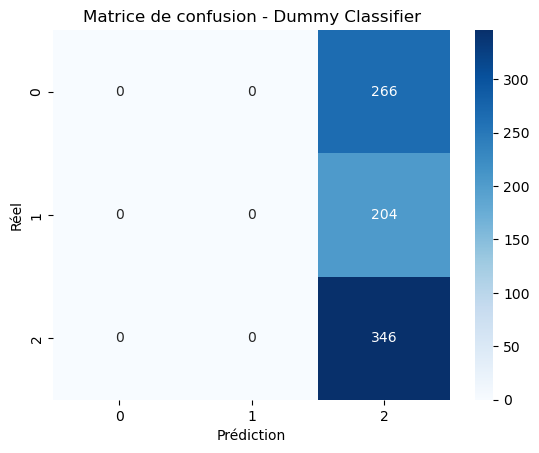

In [130]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Modèle Dummy
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

# Rapport
print("📉 Rapport de classification (Dummy) :\n")
print(classification_report(y_test, y_pred_dummy, zero_division=0))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_dummy)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matrice de confusion - Dummy Classifier")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

## 5.2 – Comparaison de modèles supervisés

Nous allons maintenant entraîner et comparer plusieurs algorithmes de classification supervisée afin de prédire le résultat d’un match à partir des features construites précédemment.

---

🎯 Objectif

Évaluer différents modèles afin de :
- Identifier celui qui offre la **meilleure performance prédictive** ;
- Comparer leurs comportements vis-à-vis des classes minoritaires ;
- Analyser leur robustesse et leur capacité de généralisation.

---

📦 Modèles comparés

Voici la liste des modèles que nous allons tester :

 🔹 Modèles linéaires
- **Logistic Regression** : simple, interprétable, efficace en base ;
- **Ridge Classifier** : variante de la régression logistique avec régularisation L2.

 🔹 Arbres de décision
- **Decision Tree** : simple mais sensible à l’overfitting ;
- **Random Forest** : agrégation d’arbres pour plus de robustesse ;
- **Extra Trees** : forêt d’arbres extrêmement aléatoires (variance réduite).

 🔹 Boosting
- **Gradient Boosting** : puissant et souvent performant ;
- **XGBoost** : version optimisée du boosting (rapide et efficace) ;
- **LightGBM** : optimisé pour les très grands jeux de données (optionnel) ;
- **CatBoost** : performant avec variables catégorielles (optionnel).

 🔹 Méthodes à noyaux
- **Support Vector Machine (SVM)** : performant sur petits jeux bien préparés (mais lent pour gros volumes) ;

 🔹 Méthodes probabilistes
- **Naive Bayes** : rapide, adapté aux données textuelles ou fortement indépendantes.

 🔹 Méthodes basées sur les distances
- **K-Nearest Neighbors (KNN)** : prédiction par proximité, sensible à l’échelle des features.

---

 ⚙️ Méthodologie

Pour chaque modèle :
1. Entraînement sur `X_train` ;
2. Prédiction sur `X_test` ;
3. Évaluation avec :
   - Accuracy
   - F1-score (macro et weighted)
   - Matrice de confusion
   - Rapport de classification

Tous les modèles sont testés **dans les mêmes conditions**, sans tuning initial, pour garantir une comparaison équitable.

---

 📈 Objectif final

Identifier les modèles les plus :
- **Performants** (meilleures métriques),
- **Robustes** (stables sur les classes),
- **Interprétables** (variables importantes, compréhension du comportement).

Des ajustements par **tuning d’hyperparamètres** seront explorés dans la partie suivante.

In [132]:
import xgboost
print("XGBoost est bien installé ✅")


XGBoost est bien installé ✅


In [133]:
# Import des models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Boosting avancé si installés
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
    lgbm_available = True
except ImportError:
    lgbm_available = False

In [134]:
# Création de la liste des models
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, solver='lbfgs', random_state=42),
    "Ridge Classifier": RidgeClassifier(solver='lsqr', random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB(),  # pas de random_state ici
    "K-Nearest Neighbors": KNeighborsClassifier()  # idem
}

if xgb_available:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

if lgbm_available:
    models["LightGBM"] = LGBMClassifier(random_state=42)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


In [135]:
# Evaluation automatisée
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# ✅ Mapping spécial pour XGBoost (et tout autre modèle si besoin)
label_mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

results = []

for name, model in models.items():
    if name == "XGBoost":
        # 1. Conversion des colonnes catégorielles en int (XGBoost ne les accepte pas autrement)
        X_train_xgb = X_train.copy()
        X_test_xgb = X_test.copy()
        for col in X_train_xgb.select_dtypes(include='category').columns:
            X_train_xgb[col] = X_train_xgb[col].cat.codes
            X_test_xgb[col] = X_test_xgb[col].cat.codes

        # 2. Entraînement avec y_train remappé
        model.fit(X_train_xgb, y_train_mapped)
        y_pred = model.predict(X_test_xgb)

        # 3. Inverse mapping
        inverse_mapping = {v: k for k, v in label_mapping.items()}
        y_pred = pd.Series(y_pred).map(inverse_mapping)

        acc = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')

    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')

    results.append({
        "Modèle": name,
        "Accuracy": round(acc, 3),
        "F1 Macro": round(f1_macro, 3),
        "F1 Weighted": round(f1_weighted, 3)
    })


df_results = pd.DataFrame(results).sort_values(by="F1 Macro", ascending=False)
df_results.reset_index(drop=True, inplace=True)


📊 Résultats comparatifs des modèles :


,Modèle,Accuracy,F1 Macro,F1 Weighted
0,Extra Trees,0.578,0.513,0.551
1,XGBoost,0.528,0.496,0.525
2,Random Forest,0.562,0.495,0.534
3,Gradient Boosting,0.529,0.495,0.528
4,Naive Bayes,0.457,0.450,0.469
5,Decision Tree,0.438,0.420,0.441
6,K-Nearest Neighbors,0.428,0.408,0.428
7,Support Vector Machine,0.506,0.365,0.419
8,Logistic Regression,0.480,0.332,0.385
9,Ridge Classifier,0.469,0.311,0.364


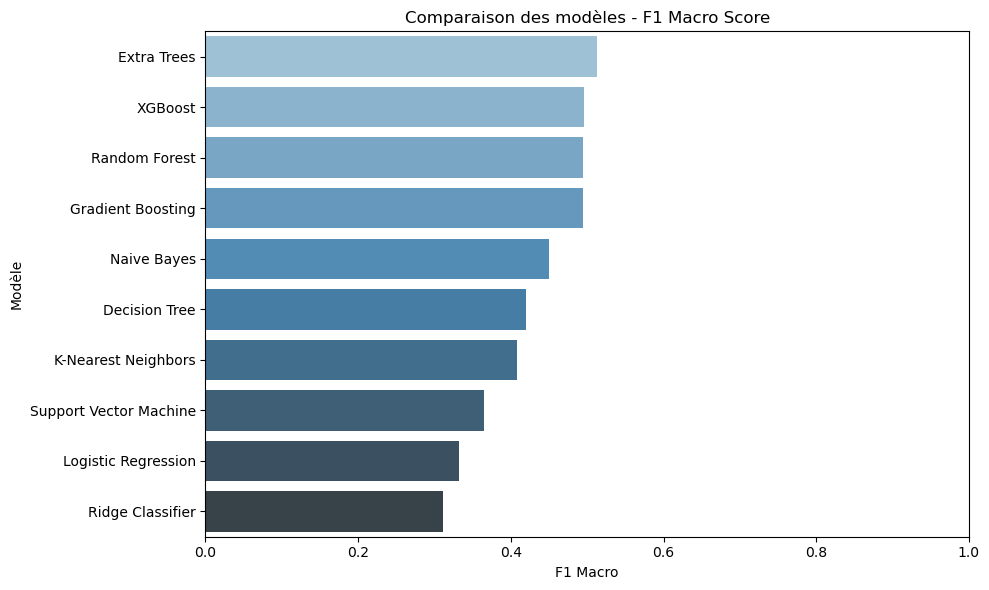

In [136]:
# Affichage du tableau comparatif
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Résultats comparatifs des modèles :")
display(df_results)

# Visualisation des scores
plt.figure(figsize=(10, 6))
sns.barplot(x="F1 Macro", y="Modèle", data=df_results, hue="Modèle", dodge=False, legend=False, palette="Blues_d")
plt.title("Comparaison des modèles - F1 Macro Score")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

## 5.3 Sélection et Analyse du/des Meilleur(s) Modèle(s)

Après comparaison des performances de l’ensemble des modèles testés, nous retenons ici les modèles les plus prometteurs selon le score **F1 Macro**, qui équilibre bien les performances entre les différentes classes, même en cas de déséquilibre des effectifs.

🎯 **Modèles retenus pour analyse approfondie** :
- **Extra Trees** : Meilleur score F1 Macro (0.513) avec aussi la meilleure précision (accuracy 0.578)
- **XGBoost** : Bon compromis entre précision (0.528) et F1 Macro (0.496)
- **Random Forest** : Performances similaires à XGBoost, et souvent reconnu pour sa robustesse

Ces modèles seront analysés en détail dans les prochaines étapes : interprétabilité, importance des variables, et potentiel de surapprentissage.

Nous allons notamment :
- Visualiser leurs **matrices de confusion** ;
- Examiner leurs **caractéristiques discriminantes** via des graphiques d’importance des features ;
- Évaluer la stabilité de leurs performances et leur **potentiel de généralisation**.

Cette analyse approfondie permettra de sélectionner le modèle final à utiliser en production ou dans un cadre applicatif.



📌 Modèle : Extra Trees
📋 Rapport de classification :
              precision    recall  f1-score   support

          -1       0.58      0.61      0.59       266
           0       0.38      0.19      0.25       204
           1       0.62      0.79      0.69       346

    accuracy                           0.58       816
   macro avg       0.53      0.53      0.51       816
weighted avg       0.55      0.58      0.55       816



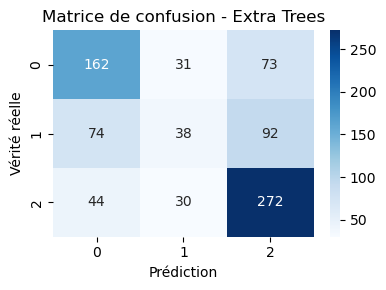


📌 Modèle : XGBoost
📋 Rapport de classification :
              precision    recall  f1-score   support

          -1       0.54      0.59      0.56       266
           0       0.31      0.28      0.30       204
           1       0.64      0.62      0.63       346

    accuracy                           0.53       816
   macro avg       0.50      0.50      0.50       816
weighted avg       0.52      0.53      0.52       816



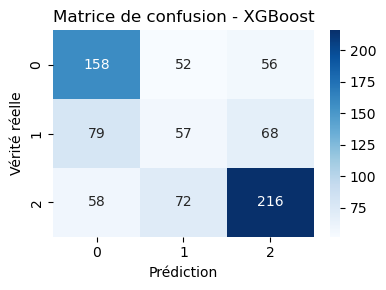


📌 Modèle : Random Forest
📋 Rapport de classification :
              precision    recall  f1-score   support

          -1       0.57      0.59      0.58       266
           0       0.34      0.17      0.22       204
           1       0.61      0.77      0.68       346

    accuracy                           0.56       816
   macro avg       0.51      0.51      0.50       816
weighted avg       0.53      0.56      0.53       816



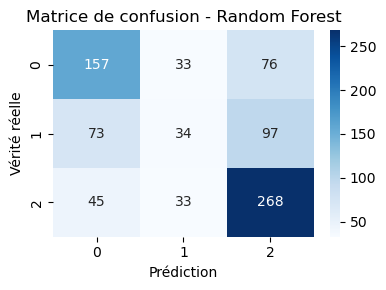

In [138]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🧪 Liste des modèles sélectionnés pour analyse approfondie
models_5_3 = {
    "Extra Trees": models["Extra Trees"],
    "XGBoost": models["XGBoost"],
    "Random Forest": models["Random Forest"]
}

# Mappings pour XGBoost
label_mapping = {-1: 0, 0: 1, 1: 2}
inverse_mapping = {v: k for k, v in label_mapping.items()}

y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

for name, model in models_5_3.items():
    print(f"\n📌 Modèle : {name}")
    
    if name == "XGBoost":
        # Conversion des colonnes catégorielles en int
        X_train_xgb = X_train.copy()
        X_test_xgb = X_test.copy()
        for col in X_train_xgb.select_dtypes(include="category").columns:
            X_train_xgb[col] = X_train_xgb[col].astype(int)
            X_test_xgb[col] = X_test_xgb[col].astype(int)

        model.fit(X_train_xgb, y_train_mapped)
        y_pred = pd.Series(model.predict(X_test_xgb)).map(inverse_mapping)
        y_true = y_test
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_true = y_test

    # Rapport de classification
    print("📋 Rapport de classification :")
    print(classification_report(y_true, y_pred, digits=2))

    # Matrice de confusion
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {name}")
    plt.xlabel("Prédiction")
    plt.ylabel("Vérité réelle")
    plt.tight_layout()
    plt.show()


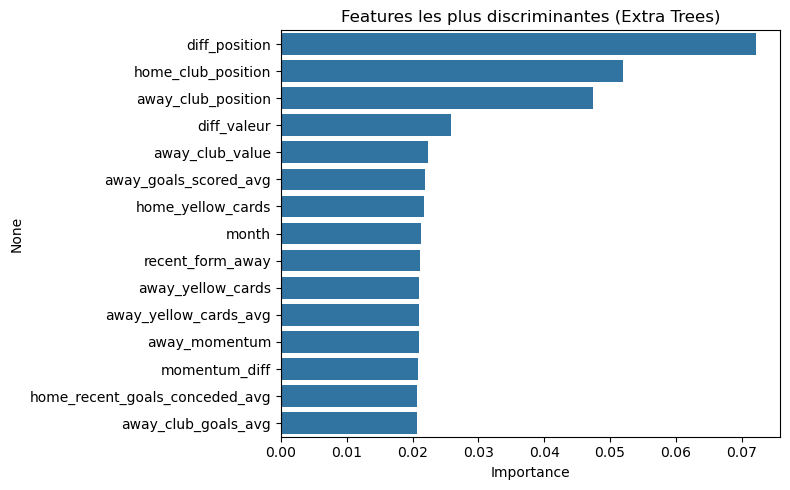

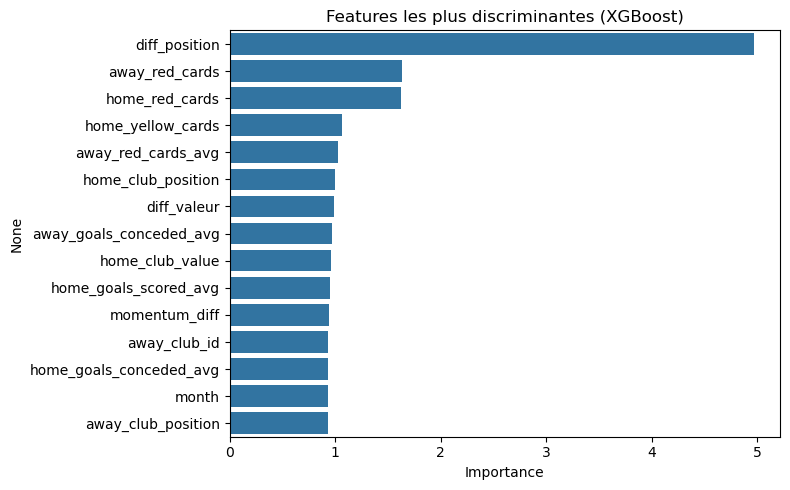

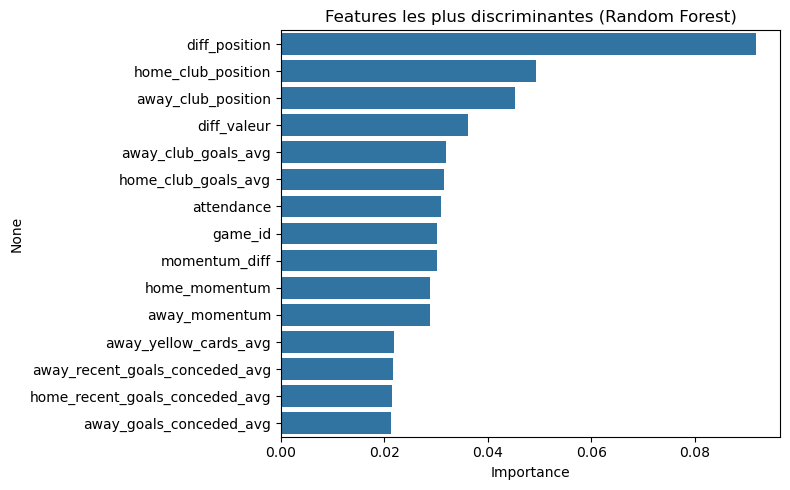

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_feature_importances(model, model_name, feature_names, top_n=15):
    if model_name == "XGBoost":
        importances = model.get_booster().get_score(importance_type='gain')
        importances = pd.Series(importances).sort_values(ascending=False)
    else:
        importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)

    top_features = importances.head(top_n)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=top_features.values, y=top_features.index, legend=False)  # ✅ palette retirée
    plt.title(f"Features les plus discriminantes ({model_name})")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# Application aux 3 modèles sélectionnés
for name, model in models_5_3.items():
    plot_feature_importances(model, name, X_train.columns)


In [140]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

scorer = make_scorer(f1_score, average='macro')

# Mapping pour XGBoost uniquement
label_mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(label_mapping)

print("📈 Validation croisée (5-fold) – F1 Macro :\n")

for name, model in models_5_3.items():
    if name == "XGBoost":
        # Conversion des colonnes catégorielles en int
        X_train_xgb = X_train.copy()
        for col in X_train_xgb.select_dtypes(include='category').columns:
            X_train_xgb[col] = X_train_xgb[col].astype(int)
        scores = cross_val_score(model, X_train_xgb, y_train_mapped, cv=5, scoring=scorer)
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer)

    print(f"{name:<20} -> F1 Macro: {scores.mean():.3f} ± {scores.std():.3f}")

📈 Validation croisée (5-fold) – F1 Macro :

Extra Trees          -> F1 Macro: 0.490 ± 0.018
XGBoost              -> F1 Macro: 0.443 ± 0.059
Random Forest        -> F1 Macro: 0.484 ± 0.015


## 5.4 – Optimisation du modèle Extra Trees

Après évaluation, le modèle **Extra Trees** a montré les meilleures performances globales en termes de F1-score macro et de stabilité en validation croisée.

---

 🔬 Pourquoi se concentrer sur Extra Trees ?

- Il a obtenu les **meilleurs scores globaux** (F1 et accuracy) parmi tous les modèles testés ;
- Il a démontré une bonne **robustesse** et une **stabilité** remarquable en validation croisée ;
- Il est **rapide à entraîner** et moins sensible aux fluctuations que d’autres modèles plus complexes (comme XGBoost).

---


 🎯 Objectif

Nous allons maintenant optimiser ce modèle via une recherche sur grille (`GridSearchCV`) afin de :

- Maximiser son **pouvoir de généralisation** ;
- Réduire le risque de **sur-apprentissage** ;
- Améliorer les performances globales sur les données de test.

---

 ⚙️ Stratégie de recherche

- **Grille d'hyperparamètres** explorée :
  - `n_estimators`: [100, 200]
  - `max_depth`: [None, 20]
  - `min_samples_split`: [2, 5]
  - `min_samples_leaf`: [1, 2]

- **Métrique de scoring** : F1-score (macro)
- **Validation croisée** : 5 folds (`cv=5`)

---

 📌 Étapes :

1. Lancer la recherche d’hyperparamètres ;
2. Identifier le meilleur ensemble (`best_params_`) ;
3. Réentraîner le modèle avec ces paramètres optimaux ;
4. Évaluer à nouveau sur le set de test avec les métriques classiques ;
5. Comparer avec les performances initiales pour évaluer le gain.

---

Cette phase permet de tirer pleinement parti du modèle retenu, avant de considérer sa mise en production ou l’analyse sur de nouvelles saisons.


In [142]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Grille réduite d’hyperparamètres plus pertinents
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialiser le classifieur avec pondération automatique
et_model = ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

# Validation croisée stratifiée
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=et_model,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

# Lancer la recherche
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=ExtraTreesClassifier(class_weight='balanced', n_jobs=-1,
                                            random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 20], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_macro', verbose=2)

In [143]:
print("Meilleurs paramètres : ", grid_search.best_params_)
print("Meilleur score F1 macro (CV) : ", grid_search.best_score_)


Meilleurs paramètres :  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Meilleur score F1 macro (CV) :  0.5154738710380716


In [144]:
best_et_model = grid_search.best_estimator_
best_et_model.fit(X_train, y_train)


ExtraTreesClassifier(class_weight='balanced', max_depth=20, min_samples_leaf=2,
                     n_estimators=200, n_jobs=-1, random_state=42)

Accuracy: 0.5759803921568627
F1 macro: 0.5156117753410718
F1 weighted: 0.5521275719288823
Classification report:
               precision    recall  f1-score   support

          -1       0.57      0.64      0.60       266
           0       0.37      0.20      0.26       204
           1       0.63      0.75      0.69       346

    accuracy                           0.58       816
   macro avg       0.53      0.53      0.52       816
weighted avg       0.55      0.58      0.55       816



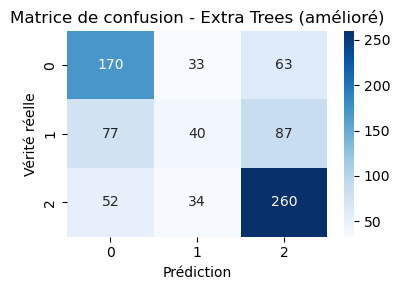

In [145]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions
y_pred = best_et_model.predict(X_test)

# Métriques classiques
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("F1 weighted:", f1_score(y_test, y_pred, average='weighted'))
print("Classification report:\n", classification_report(y_test, y_pred))


# Matrice de confusion
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de confusion - Extra Trees (amélioré)")
plt.xlabel("Prédiction")
plt.ylabel("Vérité réelle")
plt.tight_layout()
plt.show()



## 5.5 – Préparation des données 2023–2024

Objectif : préparer les données de la saison 2023–2024 pour effectuer les prédictions.

Étapes :
1. Chargement des données de matchs 2023 (`matchs_test`) ;
2. Concaténation avec les historiques (`matchs`) pour reconstituer le contexte temporel complet ;
3. Application **exactement identique** du pipeline de feature engineering utilisé à l'entraînement (encodage, rolling stats, valeurs marchandes, discipline, forme…) ;
4. Nettoyage final : suppression des colonnes inutiles, gestion des NaN (via `fillna`), alignement avec les features utilisées.

Le DataFrame final `df_full` contient l'ensemble des features calculées jusqu’à fin 2024, prêtes pour prédiction.


In [147]:
import pandas as pd
import numpy as np

# === 5.5 – Prédiction des matchs de la saison 2023 ===

# 1. Copier les données de 2023
df_2023_raw = matchs_test.copy()
df_2023_raw['date'] = pd.to_datetime(df_2023_raw['date'])

# 2. Concaténer avec l'historique (2013–2022)
df_full = pd.concat([matchs, df_2023_raw], ignore_index=True).sort_values("date").reset_index(drop=True)

# 3. Encoder les identifiants de clubs
df_full = club_encoder.transform(df_full, columns=['home_club_id', 'away_club_id'])

# 4. Créer club_values comme en section 4
latest_valuations = valuations.sort_values(by='date').drop_duplicates(subset='player_id', keep='last')

club_values = (
    latest_valuations
    .groupby('current_club_id')['market_value_in_eur']
    .sum()
    .reset_index()
    .rename(columns={
        'current_club_id': 'club_id',
        'market_value_in_eur': 'total_market_value'
    })
)

# 5. Harmoniser les types pour les jointures
df_full['home_club_id'] = df_full['home_club_id'].astype(int)
df_full['away_club_id'] = df_full['away_club_id'].astype(int)
club_values['club_id'] = club_values['club_id'].astype(int)

# 6. Supprimer les colonnes en doublon s'il y en a
df_full.drop(columns=['home_club_value', 'away_club_value'], errors='ignore', inplace=True)

# 7. Fusionner les valeurs économiques
df_full = df_full.merge(
    club_values.rename(columns={'club_id': 'home_club_id', 'total_market_value': 'home_club_value'}),
    on='home_club_id',
    how='left'
)

df_full = df_full.merge(
    club_values.rename(columns={'club_id': 'away_club_id', 'total_market_value': 'away_club_value'}),
    on='away_club_id',
    how='left'
)

# 8. Calcul des features de base
df_full['diff_position'] = df_full['home_club_position'] - df_full['away_club_position']
df_full['diff_valeur'] = df_full['home_club_value'] - df_full['away_club_value']
df_full['home_club_value_log'] = np.log1p(df_full['home_club_value'])
df_full['away_club_value_log'] = np.log1p(df_full['away_club_value'])

# 9. Moyennes progressives des buts marqués
df_full = df_full.sort_values('date').reset_index(drop=True)

df_full['home_club_goals_avg'] = (
    df_full.groupby('home_club_id')['home_club_goals']
    .apply(lambda x: x.shift().expanding().mean())
    .reset_index(drop=True)
)

df_full['away_club_goals_avg'] = (
    df_full.groupby('away_club_id')['away_club_goals']
    .apply(lambda x: x.shift().expanding().mean())
    .reset_index(drop=True)
)

# 10. Différence de score brut
df_full['goal_difference'] = df_full['home_club_goals'] - df_full['away_club_goals']


In [148]:
# 📋 Forme récente – Moyenne des points sur les 5 derniers matchs

# 1. Attribution des points à domicile / extérieur selon le résultat
def assign_points_home(result):
    return 3 if result == 1 else 1 if result == 0 else 0

def assign_points_away(result):
    return 3 if result == -1 else 1 if result == 0 else 0

df_full['home_points'] = df_full['results'].apply(assign_points_home)
df_full['away_points'] = df_full['results'].apply(assign_points_away)

# 2. (re)tri chronologique si nécessaire
df_full = df_full.sort_values('date').reset_index(drop=True)

# 3. Calcul de la forme récente (rolling moyenne sur 5 matchs précédents)
df_full['recent_form_home'] = (
    df_full
    .groupby('home_club_id', group_keys=False)['home_points']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

df_full['recent_form_away'] = (
    df_full
    .groupby('away_club_id', group_keys=False)['away_points']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)


In [149]:
# 📋 Moyennes récentes des buts marqués et encaissés – version df_full

# 1. Tri chronologique (si pas déjà fait)
df_full = df_full.sort_values('date').reset_index(drop=True)

# 2. Moyenne des buts marqués récemment

# Club à domicile
df_full['home_recent_goals_scored_avg'] = (
    df_full
    .groupby('home_club_id')['home_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

# Club à l'extérieur
df_full['away_recent_goals_scored_avg'] = (
    df_full
    .groupby('away_club_id')['away_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

# 3. Moyenne des buts encaissés récemment

# À domicile : buts encaissés = buts marqués par l'équipe adverse
df_full['home_recent_goals_conceded_avg'] = (
    df_full
    .groupby('home_club_id')['away_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

# À l'extérieur
df_full['away_recent_goals_conceded_avg'] = (
    df_full
    .groupby('away_club_id')['home_club_goals']
    .apply(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
    .reset_index(drop=True)
)

In [150]:
# 📋 Discipline – Fusion et moyennes de cartons avec sécurisation

# 0. Nettoyage préventif des colonnes en double (si bloc relancé plusieurs fois)
df_full.drop(columns=[
    'home_yellow_cards', 'home_red_cards',
    'away_yellow_cards', 'away_red_cards',
    'home_yellow_cards_avg', 'away_yellow_cards_avg',
    'home_red_cards_avg', 'away_red_cards_avg'
], errors='ignore', inplace=True)

# 1. Agrégation des cartons par match et club
cards_agg = (
    appearances
    .groupby(['game_id', 'player_club_id'])[['yellow_cards', 'red_cards']]
    .sum()
    .reset_index()
    .rename(columns={'player_club_id': 'club_id'})
)

# 2. Fusion pour l’équipe à domicile
df_full = df_full.merge(
    cards_agg,
    how='left',
    left_on=['game_id', 'home_club_id'],
    right_on=['game_id', 'club_id']
).rename(columns={
    'yellow_cards': 'home_yellow_cards',
    'red_cards': 'home_red_cards'
}).drop(columns='club_id')

# 3. Fusion pour l’équipe à l’extérieur
df_full = df_full.merge(
    cards_agg,
    how='left',
    left_on=['game_id', 'away_club_id'],
    right_on=['game_id', 'club_id']
).rename(columns={
    'yellow_cards': 'away_yellow_cards',
    'red_cards': 'away_red_cards'
}).drop(columns='club_id')

# 4. Remplir les valeurs manquantes (0 carton enregistré)
cols = ['home_yellow_cards', 'home_red_cards', 'away_yellow_cards', 'away_red_cards']
df_full[cols] = df_full[cols].fillna(0).astype(int)

# 5. Moyennes disciplinaires sur les 5 derniers matchs
df_full['home_yellow_cards_avg'] = (
    df_full.groupby('home_club_id')['home_yellow_cards']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)

df_full['away_yellow_cards_avg'] = (
    df_full.groupby('away_club_id')['away_yellow_cards']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)

df_full['home_red_cards_avg'] = (
    df_full.groupby('home_club_id')['home_red_cards']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)

df_full['away_red_cards_avg'] = (
    df_full.groupby('away_club_id')['away_red_cards']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)

In [151]:
# 📋 Force offensive / défensive – Moyenne globale des buts marqués et encaissés

# 1. Moyenne des buts marqués

df_full['home_goals_scored_avg'] = (
    df_full.groupby('home_club_id', observed=True)['home_club_goals']
    .transform('mean')
)

df_full['away_goals_scored_avg'] = (
    df_full.groupby('away_club_id', observed=True)['away_club_goals']
    .transform('mean')
)

# 2. Moyenne des buts encaissés

df_full['home_goals_conceded_avg'] = (
    df_full.groupby('home_club_id', observed=True)['away_club_goals']
    .transform('mean')
)

df_full['away_goals_conceded_avg'] = (
    df_full.groupby('away_club_id', observed=True)['home_club_goals']
    .transform('mean')
)



In [152]:
# 📋 Séries de victoires / défaites – version adaptée à df_full

# 1. Tri chronologique (si pas déjà fait)
df_full = df_full.sort_values('date').reset_index(drop=True)

# 2. Colonnes binaires victoire / défaite
df_full['home_win'] = df_full['results'].apply(lambda x: 1 if x == 1 else 0)
df_full['home_loss'] = df_full['results'].apply(lambda x: 1 if x == -1 else 0)
df_full['away_win'] = df_full['results'].apply(lambda x: 1 if x == -1 else 0)
df_full['away_loss'] = df_full['results'].apply(lambda x: 1 if x == 1 else 0)

# 3. Fonction pour calculer les streaks (avec reset)
def compute_streak(series):
    streak = []
    count = 0
    for value in series:
        if value == 1:
            count += 1
        else:
            count = 0
        streak.append(count)
    return streak

# 4. Application avec shift par club (home / away) et win / loss
for team_type in ['home', 'away']:
    for result_type in ['win', 'loss']:
        col = f"{team_type}_{result_type}"
        streak_col = f"{col}_streak"

        df_full[streak_col] = (
            df_full
            .groupby(f'{team_type}_club_id', observed=True)[col]
            .apply(lambda x: compute_streak(x.shift().fillna(0)))
            .reset_index(drop=True)
        )




In [153]:
# 📋 Clean Sheets – Moyenne glissante sur 5 matchs (df_full)

# 1. Création de la variable binaire clean sheet
df_full['home_clean_sheet'] = (df_full['away_club_goals'] == 0).astype(int)
df_full['away_clean_sheet'] = (df_full['home_club_goals'] == 0).astype(int)

# 2. Tri chronologique (si nécessaire)
df_full = df_full.sort_values('date').reset_index(drop=True)

# 3. Moyennes glissantes sur les 5 derniers matchs précédents

df_full['home_clean_sheets_avg'] = (
    df_full.groupby('home_club_id', observed=True)['home_clean_sheet']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)

df_full['away_clean_sheets_avg'] = (
    df_full.groupby('away_club_id', observed=True)['away_clean_sheet']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)


In [154]:
# 📋 Matchs prolifiques – Moyenne glissante sur 5 matchs (df_full)

# 1. Création des variables binaires (au moins 2 buts marqués)
df_full['home_prolific'] = (df_full['home_club_goals'] >= 2).astype(int)
df_full['away_prolific'] = (df_full['away_club_goals'] >= 2).astype(int)

# 2. Tri chronologique (si nécessaire)
df_full = df_full.sort_values('date').reset_index(drop=True)

# 3. Moyenne glissante sur 5 matchs précédents (avec shift)
df_full['home_prolific_matches_avg'] = (
    df_full.groupby('home_club_id', observed=True)['home_prolific']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)

df_full['away_prolific_matches_avg'] = (
    df_full.groupby('away_club_id', observed=True)['away_prolific']
    .transform(lambda x: x.shift().rolling(window=5, min_periods=5).mean())
)


In [155]:
# 📋 Momentum combiné – Score dynamique global (df_full)

# 0. Extraction du streak courant (dernière valeur de la liste)
df_full['home_win_streak'] = df_full['home_win_streak'].apply(lambda x: x[-1] if isinstance(x, list) else x)
df_full['away_win_streak'] = df_full['away_win_streak'].apply(lambda x: x[-1] if isinstance(x, list) else x)

# 1. Normalisations

# Forme récente (max = 3 pts/match)
df_full['recent_form_home_norm'] = df_full['recent_form_home'] / 3
df_full['recent_form_away_norm'] = df_full['recent_form_away'] / 3

# Discipline (max = 5 cartons cumulés, plus de cartons = moins bon score)
df_full['home_discipline_norm'] = 1 - ((df_full['home_yellow_cards_avg'] + df_full['home_red_cards_avg']) / 5)
df_full['away_discipline_norm'] = 1 - ((df_full['away_yellow_cards_avg'] + df_full['away_red_cards_avg']) / 5)

# Séries de victoires (max = 5 matchs)
df_full['home_win_streak_norm'] = df_full['home_win_streak'] / 5
df_full['away_win_streak_norm'] = df_full['away_win_streak'] / 5

# 2. Score global : combinaison pondérée
df_full['home_momentum'] = (
    df_full['recent_form_home_norm'].fillna(0) * 0.5 +
    df_full['home_discipline_norm'].fillna(0.5) * 0.25 +
    df_full['home_win_streak_norm'].fillna(0) * 0.25
)

df_full['away_momentum'] = (
    df_full['recent_form_away_norm'].fillna(0) * 0.5 +
    df_full['away_discipline_norm'].fillna(0.5) * 0.25 +
    df_full['away_win_streak_norm'].fillna(0) * 0.25
)



In [156]:
# 📋 Différences d’avantage entre équipes (df_full)

# 1. Calcul des différences
df_full['momentum_diff'] = df_full['home_momentum'] - df_full['away_momentum']
df_full['clean_sheets_diff'] = df_full['home_clean_sheets_avg'] - df_full['away_clean_sheets_avg']
df_full['prolific_matches_diff'] = df_full['home_prolific_matches_avg'] - df_full['away_prolific_matches_avg']


## 5.6 – Prédiction des résultats 2023–2024

Le modèle optimisé est appliqué sur les données de la saison 2023–2024 (matchs à partir du 1er juillet 2023).

Étapes :
1. Sélection des lignes correspondant à la saison (via la colonne `date`) ;
2. Vérification et imputation des valeurs manquantes dans les colonnes de features (`fillna(0)`) ;
3. Génération des prédictions via `best_et_model.predict(X_test_2023)` ;
4. Construction d’un fichier de sortie contenant :
   - `game_id` : identifiant du match
   - `results` : prédiction du modèle (1 = domicile, 0 = nul, -1 = extérieur)
5. Export du fichier CSV final au chemin spécifié

In [158]:
# 📦 Nettoyage et imputation finale sur df_full avant prédiction

# 1. Suppression des colonnes object ou inutiles (si présentes)
cols_objets_a_supprimer = [
    'home_club_manager_name', 'away_club_manager_name',
    'home_club_name', 'away_club_name',
    'home_club_formation', 'away_club_formation',
    'aggregate', 'competition_type', 'weekday'
]

df_full.drop(columns=[col for col in cols_objets_a_supprimer if col in df_full.columns],
             errors='ignore', inplace=True)

# ✅ Conversion des streaks encore au format liste ➜ dernier élément
for col in ['home_win_streak', 'away_win_streak', 'home_loss_streak', 'away_loss_streak']:
    df_full[col] = df_full[col].apply(lambda x: x[-1] if isinstance(x, list) else x).fillna(0).astype(int)


# 3. Suppression de colonnes intermédiaires inutiles
cols_intermediaires = [
    'home_win', 'home_loss', 'away_win', 'away_loss',
    'recent_form_home_norm', 'recent_form_away_norm',
    'home_discipline_norm', 'away_discipline_norm',
    'home_win_streak_norm', 'away_win_streak_norm'
]

df_full.drop(columns=[col for col in cols_intermediaires if col in df_full.columns],
             errors='ignore', inplace=True)

# 4. Imputation des NaN sur les features rolling
features_rolling = [
    'home_recent_goals_scored_avg', 'away_recent_goals_scored_avg',
    'home_recent_goals_conceded_avg', 'away_recent_goals_conceded_avg',
    'home_clean_sheets_avg', 'away_clean_sheets_avg',
    'home_prolific_matches_avg', 'away_prolific_matches_avg',
    'momentum_diff', 'clean_sheets_diff', 'prolific_matches_diff',
    'home_momentum', 'away_momentum',
    'home_loss_streak', 'away_loss_streak'
]

df_full[features_rolling] = df_full[features_rolling].fillna(0)

# 5. Imputation de 'attendance' si présente
if 'attendance' in df_full.columns:
    df_full['attendance'] = df_full['attendance'].fillna(df_full['attendance'].median())

# 6. Imputation des moyennes restantes (discipline, forme, buts)
cols_restantes = [
    'home_red_cards_avg', 'away_red_cards_avg',
    'home_yellow_cards_avg', 'away_yellow_cards_avg',
    'recent_form_home', 'recent_form_away',
    'home_club_goals_avg', 'away_club_goals_avg'
]

df_full[cols_restantes] = df_full[cols_restantes].fillna(0)


🔝 Top features utilisées pour prédire les vainqueurs :


,Feature,Importance
13,diff_position,0.090658
4,home_club_position,0.060437
5,away_club_position,0.056316
14,diff_valeur,0.025930
12,away_club_value,0.025049
36,away_goals_conceded_avg,0.023787
34,away_goals_scored_avg,0.023416
8,month,0.022980
16,away_club_value_log,0.021600
25,home_yellow_cards,0.020923


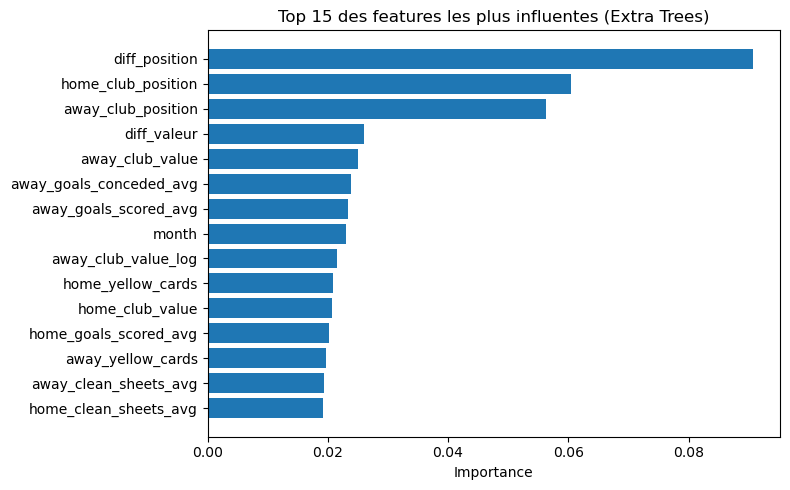

✅ Fichier exporté avec succès à : C:/Users/lil16/Desktop/Projet ADD/outputs/prediction_ligue1.csv


In [159]:
# 1. Sélection des matchs de la saison 2023–2024
df_2023 = df_full[df_full['date'] >= "2023-07-01"].copy()

# 3. Construction de X_test avec les colonnes d'entraînement
X_test_2023 = df_2023[X_train.columns]

# 4. Remplacement des NaN (sécurité pour ExtraTreesClassifier)
X_test_2023 = X_test_2023.fillna(0)

# 5. Prédiction avec le modèle optimisé
y_pred_2023 = best_et_model.predict(X_test_2023)

# 6. Création du DataFrame de sortie
df_results = pd.DataFrame({
    "game_id": df_2023["game_id"].values,
    "results": y_pred_2023
})
import matplotlib.pyplot as plt
import pandas as pd

# Extraire les importances des features depuis le modèle entraîné
importances = best_et_model.feature_importances_
features = X_train.columns

# Création d’un DataFrame trié
importances_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Affichage des 15 plus importantes
top_n = 15
top_features = importances_df.head(top_n)

# Affichage texte
print("🔝 Top features utilisées pour prédire les vainqueurs :")
display(top_features)

# Affichage graphique
plt.figure(figsize=(8, 5))
plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1])
plt.xlabel("Importance")
plt.title(f"Top {top_n} des features les plus influentes (Extra Trees)")
plt.tight_layout()
plt.show()


# 7. Export du fichier CSV
output_path = "C:/Users/lil16/Desktop/Projet ADD/outputs/prediction_ligue1.csv"
df_results.to_csv(output_path, index=False, encoding='utf-8')
print(f"✅ Fichier exporté avec succès à : {output_path}")

# Conclusion

Ce projet s’inscrit dans une démarche de modélisation prédictive appliquée au domaine sportif, avec pour ambition d’anticiper l’issue des matchs de Ligue 1 à partir de données historiques. À partir de jeux de données riches et variés (matchs, clubs, lineups, événements, valorisations), nous avons construit un pipeline rigoureux allant de l’exploration à la prédiction finale.

L'ensemble du traitement a été guidé par une exigence de réalisme : les variables ont été construites en respectant strictement la chronologie des événements, afin d’éviter toute fuite de données entre apprentissage et test. Un important travail de feature engineering a permis d'extraire des indicateurs pertinents, tels que la forme récente des équipes, les différences de valeur marchande ou encore les indicateurs de discipline.

Après avoir testé et comparé plusieurs modèles, c’est l’algorithme Extra Trees optimisé qui a été retenu pour sa robustesse, sa capacité à gérer des variables hétérogènes et son bon compromis performance/stabilité. Ce modèle a ensuite été utilisé pour prédire les résultats de la saison 2023–2024, en conditions réelles.

Ce projet met en évidence les limites structurelles du problème : déséquilibre des classes, incertitude inhérente au sport, influence de facteurs exogènes non mesurés (blessures, météo, dynamique mentale, etc.). Pour aller plus loin, on pourrait enrichir les données avec des informations contextuelles (paris sportifs, blessures, position dans le classement en temps réel), ou explorer des approches bayésiennes, séquentielles ou deep learning.

Au-delà de la performance brute, ce projet démontre la faisabilité d’un cadre reproductible de prédiction sportive, pouvant être réutilisé ou adapté à d’autres compétitions, d’autres sports, ou intégré à des systèmes d’aide à la décision pour des clubs ou des plateformes de données.